In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp

In [2]:
#function for removing collinear tables by threshold
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        print('processed: ' + X[cols[variables]].columns[maxloc])
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [3]:
train_df = pd.read_csv("final_dataset_new.csv", header=0)

#lets sample out of the dataset so we can train quickly
train_df = train_df.sample(frac=0.05, random_state=786)

#impute nans
train_df = train_df.fillna(0)

In [4]:
train_df.shape

(2999, 8090)

In [5]:
#aggregate labels
target_category_to_set = 'OTHER'
genres_to_aggregate = []

#lets get genre counts
genre_count = train_df.groupby('genre')['genre'].count()

#aggregate sparse genres for list
for index, value in genre_count.items():
    #if value <= percent_to_aggregate_to_other * total_rows:
    if value <= 10: 
        genres_to_aggregate.append(index)

#iterate all rows, and all aggregation genres, and set to new category
#when needed
for index, row in train_df.iterrows():
    for genre in genres_to_aggregate:
        if row['genre'] == genre:
            train_df.loc[index, 'genre'] = target_category_to_set

In [6]:
labels = train_df["genre"].values
train_df.drop(["genre"], inplace=True, axis=1)

In [7]:
#these columns have high VIF
drop_vif_columns_list = ['lowlevel_barkbands_flatness_db_mean'
,'lowlevel_barkbands_flatness_db_median'
,'lowlevel_barkbands_kurtosis_dmean'
,'lowlevel_barkbands_kurtosis_dmean2'
,'lowlevel_barkbands_kurtosis_dvar'
,'lowlevel_barkbands_kurtosis_dvar2'
,'lowlevel_barkbands_kurtosis_max'
,'lowlevel_barkbands_kurtosis_mean'
,'lowlevel_barkbands_kurtosis_median'
,'lowlevel_barkbands_kurtosis_stdev'
,'lowlevel_barkbands_kurtosis_var'
,'lowlevel_barkbands_skewness_dmean'
,'lowlevel_barkbands_skewness_dmean2'
,'lowlevel_barkbands_skewness_dvar'
,'lowlevel_barkbands_skewness_dvar2'
,'lowlevel_barkbands_skewness_mean'
,'lowlevel_barkbands_skewness_median'
,'lowlevel_barkbands_skewness_min'
,'lowlevel_barkbands_skewness_stdev'
,'lowlevel_barkbands_skewness_var'
,'lowlevel_barkbands_spread_dmean'
,'lowlevel_barkbands_spread_dmean2'
,'lowlevel_barkbands_spread_dvar'
,'lowlevel_barkbands_spread_dvar2'
,'lowlevel_barkbands_spread_mean'
,'lowlevel_barkbands_spread_stdev'
,'lowlevel_erbbands_flatness_db_mean'
,'lowlevel_erbbands_flatness_db_median'
,'lowlevel_erbbands_kurtosis_dvar'
,'lowlevel_erbbands_kurtosis_dvar2'
,'lowlevel_erbbands_kurtosis_var'
,'lowlevel_erbbands_skewness_dvar'
,'lowlevel_erbbands_skewness_dvar2'
,'lowlevel_erbbands_skewness_var'
,'lowlevel_erbbands_spread_dmean'
,'lowlevel_erbbands_spread_dmean2'
,'lowlevel_erbbands_spread_dvar'
,'lowlevel_erbbands_spread_dvar2'
,'lowlevel_erbbands_spread_mean'
,'lowlevel_erbbands_spread_stdev'
,'lowlevel_hfc_dmean'
,'lowlevel_hfc_dmean2'
,'lowlevel_hfc_dvar'
,'lowlevel_hfc_dvar2'
,'lowlevel_hfc_max'
,'lowlevel_hfc_mean'
,'lowlevel_hfc_stdev'
,'lowlevel_hfc_var'
,'lowlevel_loudness_ebu128_momentary_dvar'
,'lowlevel_loudness_ebu128_momentary_dvar2'
,'lowlevel_loudness_ebu128_momentary_mean'
,'lowlevel_loudness_ebu128_momentary_median'
,'lowlevel_loudness_ebu128_momentary_stdev'
,'lowlevel_loudness_ebu128_momentary_var'
,'lowlevel_loudness_ebu128_short_term_mean'
,'lowlevel_loudness_ebu128_short_term_stdev'
,'lowlevel_melbands_flatness_db_mean'
,'lowlevel_melbands_flatness_db_median'
,'lowlevel_melbands_flatness_db_stdev'
,'lowlevel_melbands_flatness_db_var'
,'lowlevel_melbands_kurtosis_dmean'
,'lowlevel_melbands_kurtosis_dmean2'
,'lowlevel_melbands_kurtosis_dvar'
,'lowlevel_melbands_kurtosis_dvar2'
,'lowlevel_melbands_kurtosis_max'
,'lowlevel_melbands_kurtosis_mean'
,'lowlevel_melbands_kurtosis_median'
,'lowlevel_melbands_kurtosis_stdev'
,'lowlevel_melbands_kurtosis_var'
,'lowlevel_melbands_skewness_dmean'
,'lowlevel_melbands_skewness_dmean2'
,'lowlevel_melbands_skewness_dvar'
,'lowlevel_melbands_skewness_dvar2'
,'lowlevel_melbands_skewness_max'
,'lowlevel_melbands_skewness_mean'
,'lowlevel_melbands_skewness_stdev'
,'lowlevel_melbands_skewness_var'
,'lowlevel_melbands_spread_dmean'
,'lowlevel_melbands_spread_dmean2'
,'lowlevel_melbands_spread_dvar'
,'lowlevel_melbands_spread_dvar2'
,'lowlevel_melbands_spread_mean'
,'lowlevel_melbands_spread_median'
,'lowlevel_melbands_spread_stdev'
,'lowlevel_melbands_spread_var'
,'lowlevel_silence_rate_60dB_max'
,'lowlevel_spectral_centroid_dmean'
,'lowlevel_spectral_centroid_dmean2'
,'lowlevel_spectral_centroid_dvar'
,'lowlevel_spectral_centroid_dvar2'
,'lowlevel_spectral_centroid_mean'
,'lowlevel_spectral_centroid_median'
,'lowlevel_spectral_centroid_stdev'
,'lowlevel_spectral_centroid_var'
,'lowlevel_spectral_decrease_dvar'
,'lowlevel_spectral_decrease_dvar2'
,'lowlevel_spectral_decrease_mean'
,'lowlevel_spectral_decrease_median'
,'lowlevel_spectral_decrease_stdev'
,'lowlevel_spectral_decrease_var'
,'lowlevel_spectral_energy_dvar'
,'lowlevel_spectral_energy_dvar2'
,'lowlevel_spectral_energy_mean'
,'lowlevel_spectral_energy_median'
,'lowlevel_spectral_energy_stdev'
,'lowlevel_spectral_energy_var'
,'lowlevel_spectral_energyband_high_dmean'
,'lowlevel_spectral_energyband_high_dmean2'
,'lowlevel_spectral_energyband_high_dvar'
,'lowlevel_spectral_energyband_high_dvar2'
,'lowlevel_spectral_energyband_high_max'
,'lowlevel_spectral_energyband_high_mean'
,'lowlevel_spectral_energyband_high_stdev'
,'lowlevel_spectral_energyband_high_var'
,'lowlevel_spectral_energyband_middle_high_dvar'
,'lowlevel_spectral_energyband_middle_high_dvar2'
,'lowlevel_spectral_energyband_middle_high_max'
,'lowlevel_spectral_energyband_middle_high_stdev'
,'lowlevel_spectral_energyband_middle_high_var'
,'lowlevel_spectral_energyband_middle_low_dvar'
,'lowlevel_spectral_energyband_middle_low_dvar2'
,'lowlevel_spectral_energyband_middle_low_max'
,'lowlevel_spectral_energyband_middle_low_stdev'
,'lowlevel_spectral_energyband_middle_low_var'
,'lowlevel_spectral_entropy_max'
,'lowlevel_spectral_entropy_mean'
,'lowlevel_spectral_entropy_median'
,'lowlevel_spectral_entropy_stdev'
,'lowlevel_spectral_flux_dvar'
,'lowlevel_spectral_flux_dvar2'
,'lowlevel_spectral_flux_var'
,'lowlevel_spectral_kurtosis_dvar'
,'lowlevel_spectral_kurtosis_dvar2'
,'lowlevel_spectral_kurtosis_stdev'
,'lowlevel_spectral_kurtosis_var'
,'lowlevel_spectral_rms_var'
,'lowlevel_spectral_rolloff_dmean'
,'lowlevel_spectral_rolloff_dmean2'
,'lowlevel_spectral_rolloff_dvar'
,'lowlevel_spectral_rolloff_dvar2'
,'lowlevel_spectral_rolloff_mean'
,'lowlevel_spectral_rolloff_median'
,'lowlevel_spectral_rolloff_stdev'
,'lowlevel_spectral_rolloff_var'
,'lowlevel_spectral_skewness_dmean2'
,'lowlevel_spectral_skewness_dvar'
,'lowlevel_spectral_skewness_dvar2'
,'lowlevel_spectral_skewness_max'
,'lowlevel_spectral_skewness_stdev'
,'lowlevel_spectral_skewness_var'
,'lowlevel_spectral_spread_dmean'
,'lowlevel_spectral_spread_dmean2'
,'lowlevel_spectral_spread_dvar'
,'lowlevel_spectral_spread_dvar2'
,'lowlevel_spectral_spread_mean'
,'lowlevel_spectral_spread_median'
,'lowlevel_spectral_spread_stdev'
,'lowlevel_spectral_spread_var'
,'lowlevel_spectral_strongpeak_dvar'
,'lowlevel_spectral_strongpeak_dvar2'
,'lowlevel_spectral_strongpeak_var'
,'lowlevel_zerocrossingrate_dmean'
,'lowlevel_zerocrossingrate_dmean2'
,'lowlevel_zerocrossingrate_dvar'
,'lowlevel_zerocrossingrate_dvar2'
,'lowlevel_zerocrossingrate_mean'
,'lowlevel_zerocrossingrate_median'
,'lowlevel_zerocrossingrate_stdev'
,'lowlevel_zerocrossingrate_var'
,'lowlevel_barkbands_dmean_0'
,'lowlevel_barkbands_dmean_25'
,'lowlevel_barkbands_dmean_26'
,'lowlevel_barkbands_dmean2_22'
,'lowlevel_barkbands_dmean2_26'
,'lowlevel_barkbands_dvar_0'
,'lowlevel_barkbands_dvar_2'
,'lowlevel_barkbands_dvar_3'
,'lowlevel_barkbands_dvar_4'
,'lowlevel_barkbands_dvar_5'
,'lowlevel_barkbands_dvar_6'
,'lowlevel_barkbands_dvar_7'
,'lowlevel_barkbands_dvar_8'
,'lowlevel_barkbands_dvar_9'
,'lowlevel_barkbands_dvar_10'
,'lowlevel_barkbands_dvar_11'
,'lowlevel_barkbands_dvar_12'
,'lowlevel_barkbands_dvar_13'
,'lowlevel_barkbands_dvar_15'
,'lowlevel_barkbands_dvar_16'
,'lowlevel_barkbands_dvar_17'
,'lowlevel_barkbands_dvar_18'
,'lowlevel_barkbands_dvar_19'
,'lowlevel_barkbands_dvar_20'
,'lowlevel_barkbands_dvar_21'
,'lowlevel_barkbands_dvar_22'
,'lowlevel_barkbands_dvar_23'
,'lowlevel_barkbands_dvar_24'
,'lowlevel_barkbands_dvar_25'
,'lowlevel_barkbands_dvar_26'
,'lowlevel_barkbands_dvar2_0'
,'lowlevel_barkbands_dvar2_2'
,'lowlevel_barkbands_dvar2_3'
,'lowlevel_barkbands_dvar2_4'
,'lowlevel_barkbands_dvar2_5'
,'lowlevel_barkbands_dvar2_6'
,'lowlevel_barkbands_dvar2_7'
,'lowlevel_barkbands_dvar2_8'
,'lowlevel_barkbands_dvar2_9'
,'lowlevel_barkbands_dvar2_11'
,'lowlevel_barkbands_dvar2_12'
,'lowlevel_barkbands_dvar2_13'
,'lowlevel_barkbands_dvar2_15'
,'lowlevel_barkbands_dvar2_16'
,'lowlevel_barkbands_dvar2_17'
,'lowlevel_barkbands_dvar2_18'
,'lowlevel_barkbands_dvar2_19'
,'lowlevel_barkbands_dvar2_20'
,'lowlevel_barkbands_dvar2_21'
,'lowlevel_barkbands_dvar2_22'
,'lowlevel_barkbands_dvar2_23'
,'lowlevel_barkbands_dvar2_24'
,'lowlevel_barkbands_dvar2_25'
,'lowlevel_barkbands_dvar2_26'
,'lowlevel_barkbands_max_4'
,'lowlevel_barkbands_max_5'
,'lowlevel_barkbands_max_6'
,'lowlevel_barkbands_max_7'
,'lowlevel_barkbands_max_8'
,'lowlevel_barkbands_max_9'
,'lowlevel_barkbands_max_10'
,'lowlevel_barkbands_max_11'
,'lowlevel_barkbands_max_12'
,'lowlevel_barkbands_max_13'
,'lowlevel_barkbands_max_14'
,'lowlevel_barkbands_max_15'
,'lowlevel_barkbands_max_16'
,'lowlevel_barkbands_max_17'
,'lowlevel_barkbands_max_18'
,'lowlevel_barkbands_max_19'
,'lowlevel_barkbands_max_20'
,'lowlevel_barkbands_max_21'
,'lowlevel_barkbands_max_22'
,'lowlevel_barkbands_max_23'
,'lowlevel_barkbands_max_24'
,'lowlevel_barkbands_max_25'
,'lowlevel_barkbands_mean_0'
,'lowlevel_barkbands_mean_22'
,'lowlevel_barkbands_mean_23'
,'lowlevel_barkbands_mean_24'
,'lowlevel_barkbands_mean_25'
,'lowlevel_barkbands_median_0'
,'lowlevel_barkbands_median_26'
,'lowlevel_barkbands_stdev_0'
,'lowlevel_barkbands_stdev_17'
,'lowlevel_barkbands_stdev_18'
,'lowlevel_barkbands_stdev_20'
,'lowlevel_barkbands_stdev_21'
,'lowlevel_barkbands_stdev_22'
,'lowlevel_barkbands_stdev_23'
,'lowlevel_barkbands_stdev_24'
,'lowlevel_barkbands_stdev_25'
,'lowlevel_barkbands_stdev_26'
,'lowlevel_barkbands_var_0'
,'lowlevel_barkbands_var_2'
,'lowlevel_barkbands_var_4'
,'lowlevel_barkbands_var_5'
,'lowlevel_barkbands_var_6'
,'lowlevel_barkbands_var_7'
,'lowlevel_barkbands_var_8'
,'lowlevel_barkbands_var_9'
,'lowlevel_barkbands_var_10'
,'lowlevel_barkbands_var_11'
,'lowlevel_barkbands_var_12'
,'lowlevel_barkbands_var_13'
,'lowlevel_barkbands_var_14'
,'lowlevel_barkbands_var_15'
,'lowlevel_barkbands_var_16'
,'lowlevel_barkbands_var_17'
,'lowlevel_barkbands_var_18'
,'lowlevel_barkbands_var_19'
,'lowlevel_barkbands_var_20'
,'lowlevel_barkbands_var_21'
,'lowlevel_barkbands_var_22'
,'lowlevel_barkbands_var_23'
,'lowlevel_barkbands_var_24'
,'lowlevel_barkbands_var_25'
,'lowlevel_barkbands_var_26'
,'lowlevel_erbbands_dmean_30'
,'lowlevel_erbbands_dmean_34'
,'lowlevel_erbbands_dmean_35'
,'lowlevel_erbbands_dmean_38'
,'lowlevel_erbbands_dmean2_30'
,'lowlevel_erbbands_dmean2_35'
,'lowlevel_erbbands_dmean2_37'
,'lowlevel_erbbands_dmean2_38'
,'lowlevel_erbbands_dvar_1'
,'lowlevel_erbbands_dvar_2'
,'lowlevel_erbbands_dvar_3'
,'lowlevel_erbbands_dvar_4'
,'lowlevel_erbbands_dvar_5'
,'lowlevel_erbbands_dvar_6'
,'lowlevel_erbbands_dvar_7'
,'lowlevel_erbbands_dvar_8'
,'lowlevel_erbbands_dvar_9'
,'lowlevel_erbbands_dvar_10'
,'lowlevel_erbbands_dvar_11'
,'lowlevel_erbbands_dvar_12'
,'lowlevel_erbbands_dvar_13'
,'lowlevel_erbbands_dvar_14'
,'lowlevel_erbbands_dvar_15'
,'lowlevel_erbbands_dvar_16'
,'lowlevel_erbbands_dvar_17'
,'lowlevel_erbbands_dvar_18'
,'lowlevel_erbbands_dvar_19'
,'lowlevel_erbbands_dvar_20'
,'lowlevel_erbbands_dvar_21'
,'lowlevel_erbbands_dvar_22'
,'lowlevel_erbbands_dvar_23'
,'lowlevel_erbbands_dvar_24'
,'lowlevel_erbbands_dvar_25'
,'lowlevel_erbbands_dvar_26'
,'lowlevel_erbbands_dvar_27'
,'lowlevel_erbbands_dvar_28'
,'lowlevel_erbbands_dvar_29'
,'lowlevel_erbbands_dvar_30'
,'lowlevel_erbbands_dvar_31'
,'lowlevel_erbbands_dvar_32'
,'lowlevel_erbbands_dvar_33'
,'lowlevel_erbbands_dvar_34'
,'lowlevel_erbbands_dvar_35'
,'lowlevel_erbbands_dvar_36'
,'lowlevel_erbbands_dvar_37'
,'lowlevel_erbbands_dvar_38'
,'lowlevel_erbbands_dvar_39'
,'lowlevel_erbbands_dvar2_2'
,'lowlevel_erbbands_dvar2_3'
,'lowlevel_erbbands_dvar2_4'
,'lowlevel_erbbands_dvar2_5'
,'lowlevel_erbbands_dvar2_6'
,'lowlevel_erbbands_dvar2_7'
,'lowlevel_erbbands_dvar2_8'
,'lowlevel_erbbands_dvar2_9'
,'lowlevel_erbbands_dvar2_10'
,'lowlevel_erbbands_dvar2_11'
,'lowlevel_erbbands_dvar2_12'
,'lowlevel_erbbands_dvar2_13'
,'lowlevel_erbbands_dvar2_14'
,'lowlevel_erbbands_dvar2_15'
,'lowlevel_erbbands_dvar2_16'
,'lowlevel_erbbands_dvar2_17'
,'lowlevel_erbbands_dvar2_18'
,'lowlevel_erbbands_dvar2_19'
,'lowlevel_erbbands_dvar2_20'
,'lowlevel_erbbands_dvar2_21'
,'lowlevel_erbbands_dvar2_22'
,'lowlevel_erbbands_dvar2_23'
,'lowlevel_erbbands_dvar2_24'
,'lowlevel_erbbands_dvar2_25'
,'lowlevel_erbbands_dvar2_26'
,'lowlevel_erbbands_dvar2_27'
,'lowlevel_erbbands_dvar2_28'
,'lowlevel_erbbands_dvar2_29'
,'lowlevel_erbbands_dvar2_30'
,'lowlevel_erbbands_dvar2_31'
,'lowlevel_erbbands_dvar2_32'
,'lowlevel_erbbands_dvar2_33'
,'lowlevel_erbbands_dvar2_34'
,'lowlevel_erbbands_dvar2_35'
,'lowlevel_erbbands_dvar2_36'
,'lowlevel_erbbands_dvar2_37'
,'lowlevel_erbbands_dvar2_38'
,'lowlevel_erbbands_dvar2_39'
,'lowlevel_erbbands_max_12'
,'lowlevel_erbbands_max_19'
,'lowlevel_erbbands_max_20'
,'lowlevel_erbbands_max_23'
,'lowlevel_erbbands_max_24'
,'lowlevel_erbbands_max_25'
,'lowlevel_erbbands_max_26'
,'lowlevel_erbbands_max_27'
,'lowlevel_erbbands_max_28'
,'lowlevel_erbbands_max_29'
,'lowlevel_erbbands_max_30'
,'lowlevel_erbbands_max_31'
,'lowlevel_erbbands_max_32'
,'lowlevel_erbbands_max_33'
,'lowlevel_erbbands_max_34'
,'lowlevel_erbbands_max_35'
,'lowlevel_erbbands_mean_30'
,'lowlevel_erbbands_mean_31'
,'lowlevel_erbbands_mean_34'
,'lowlevel_erbbands_mean_35'
,'lowlevel_erbbands_mean_39'
,'lowlevel_erbbands_median_38'
,'lowlevel_erbbands_stdev_3'
,'lowlevel_erbbands_stdev_4'
,'lowlevel_erbbands_stdev_6'
,'lowlevel_erbbands_stdev_7'
,'lowlevel_erbbands_stdev_15'
,'lowlevel_erbbands_stdev_19'
,'lowlevel_erbbands_stdev_20'
,'lowlevel_erbbands_stdev_22'
,'lowlevel_erbbands_stdev_23'
,'lowlevel_erbbands_stdev_24'
,'lowlevel_erbbands_stdev_26'
,'lowlevel_erbbands_stdev_27'
,'lowlevel_erbbands_stdev_28'
,'lowlevel_erbbands_stdev_29'
,'lowlevel_erbbands_stdev_30'
,'lowlevel_erbbands_stdev_31'
,'lowlevel_erbbands_stdev_32'
,'lowlevel_erbbands_stdev_33'
,'lowlevel_erbbands_stdev_34'
,'lowlevel_erbbands_stdev_35'
,'lowlevel_erbbands_stdev_37'
,'lowlevel_erbbands_var_10'
,'lowlevel_erbbands_var_12'
,'lowlevel_erbbands_var_13'
,'lowlevel_erbbands_var_16'
,'lowlevel_erbbands_var_17'
,'lowlevel_erbbands_var_18'
,'lowlevel_erbbands_var_19'
,'lowlevel_erbbands_var_20'
,'lowlevel_erbbands_var_22'
,'lowlevel_erbbands_var_23'
,'lowlevel_erbbands_var_24'
,'lowlevel_erbbands_var_26'
,'lowlevel_erbbands_var_27'
,'lowlevel_erbbands_var_28'
,'lowlevel_erbbands_var_29'
,'lowlevel_erbbands_var_30'
,'lowlevel_erbbands_var_31'
,'lowlevel_erbbands_var_32'
,'lowlevel_erbbands_var_33'
,'lowlevel_erbbands_var_34'
,'lowlevel_erbbands_var_35'
,'lowlevel_erbbands_var_36'
,'lowlevel_erbbands_var_37'
,'lowlevel_erbbands_var_38'
,'lowlevel_erbbands_var_39'
,'lowlevel_gfcc_mean_0'
,'lowlevel_gfcc_mean_1'
,'lowlevel_gfcc_cov_0_0'
,'lowlevel_gfcc_cov_0_1'
,'lowlevel_gfcc_cov_0_2'
,'lowlevel_gfcc_cov_0_3'
,'lowlevel_gfcc_cov_0_4'
,'lowlevel_gfcc_cov_0_5'
,'lowlevel_gfcc_cov_0_6'
,'lowlevel_gfcc_cov_0_7'
,'lowlevel_gfcc_cov_0_8'
,'lowlevel_gfcc_cov_0_9'
,'lowlevel_gfcc_cov_0_10'
,'lowlevel_gfcc_cov_0_11'
,'lowlevel_gfcc_cov_0_12'
,'lowlevel_gfcc_cov_1_0'
,'lowlevel_gfcc_cov_1_1'
,'lowlevel_gfcc_cov_1_2'
,'lowlevel_gfcc_cov_1_3'
,'lowlevel_gfcc_cov_1_4'
,'lowlevel_gfcc_cov_1_5'
,'lowlevel_gfcc_cov_1_6'
,'lowlevel_gfcc_cov_1_7'
,'lowlevel_gfcc_cov_1_8'
,'lowlevel_gfcc_cov_1_9'
,'lowlevel_gfcc_cov_1_10'
,'lowlevel_gfcc_cov_1_11'
,'lowlevel_gfcc_cov_1_12'
,'lowlevel_gfcc_cov_2_0'
,'lowlevel_gfcc_cov_2_1'
,'lowlevel_gfcc_cov_2_2'
,'lowlevel_gfcc_cov_2_3'
,'lowlevel_gfcc_cov_2_4'
,'lowlevel_gfcc_cov_2_5'
,'lowlevel_gfcc_cov_2_6'
,'lowlevel_gfcc_cov_2_7'
,'lowlevel_gfcc_cov_2_8'
,'lowlevel_gfcc_cov_2_9'
,'lowlevel_gfcc_cov_2_10'
,'lowlevel_gfcc_cov_3_0'
,'lowlevel_gfcc_cov_3_1'
,'lowlevel_gfcc_cov_3_2'
,'lowlevel_gfcc_cov_3_3'
,'lowlevel_gfcc_cov_3_4'
,'lowlevel_gfcc_cov_3_5'
,'lowlevel_gfcc_cov_3_6'
,'lowlevel_gfcc_cov_3_7'
,'lowlevel_gfcc_cov_4_0'
,'lowlevel_gfcc_cov_4_1'
,'lowlevel_gfcc_cov_4_2'
,'lowlevel_gfcc_cov_4_3'
,'lowlevel_gfcc_cov_4_4'
,'lowlevel_gfcc_cov_4_5'
,'lowlevel_gfcc_cov_4_6'
,'lowlevel_gfcc_cov_4_7'
,'lowlevel_gfcc_cov_5_0'
,'lowlevel_gfcc_cov_5_1'
,'lowlevel_gfcc_cov_5_2'
,'lowlevel_gfcc_cov_5_3'
,'lowlevel_gfcc_cov_5_4'
,'lowlevel_gfcc_cov_5_5'
,'lowlevel_gfcc_cov_5_6'
,'lowlevel_gfcc_cov_6_0'
,'lowlevel_gfcc_cov_6_1'
,'lowlevel_gfcc_cov_6_2'
,'lowlevel_gfcc_cov_6_3'
,'lowlevel_gfcc_cov_6_4'
,'lowlevel_gfcc_cov_6_5'
,'lowlevel_gfcc_cov_7_0'
,'lowlevel_gfcc_cov_7_1'
,'lowlevel_gfcc_cov_7_2'
,'lowlevel_gfcc_cov_7_3'
,'lowlevel_gfcc_cov_8_0'
,'lowlevel_gfcc_cov_8_1'
,'lowlevel_gfcc_cov_8_2'
,'lowlevel_gfcc_cov_9_0'
,'lowlevel_gfcc_cov_9_1'
,'lowlevel_gfcc_cov_9_2'
,'lowlevel_gfcc_cov_10_0'
,'lowlevel_gfcc_cov_10_1'
,'lowlevel_gfcc_cov_10_2'
,'lowlevel_gfcc_cov_11_0'
,'lowlevel_gfcc_cov_11_1'
,'lowlevel_gfcc_cov_12_0'
,'lowlevel_gfcc_cov_12_1'
,'lowlevel_gfcc_icov_4_7'
,'lowlevel_gfcc_icov_6_12'
,'lowlevel_gfcc_icov_7_4'
,'lowlevel_gfcc_icov_8_12'
,'lowlevel_gfcc_icov_11_11'
,'lowlevel_gfcc_icov_11_12'
,'lowlevel_gfcc_icov_12_6'
,'lowlevel_gfcc_icov_12_8'
,'lowlevel_gfcc_icov_12_11'
,'lowlevel_melbands_dmean_34'
,'lowlevel_melbands_dmean_35'
,'lowlevel_melbands_dmean2_34'
,'lowlevel_melbands_dmean2_35'
,'lowlevel_melbands_dvar_1'
,'lowlevel_melbands_dvar_2'
,'lowlevel_melbands_dvar_3'
,'lowlevel_melbands_dvar_4'
,'lowlevel_melbands_dvar_5'
,'lowlevel_melbands_dvar_6'
,'lowlevel_melbands_dvar_7'
,'lowlevel_melbands_dvar_8'
,'lowlevel_melbands_dvar_9'
,'lowlevel_melbands_dvar_10'
,'lowlevel_melbands_dvar_11'
,'lowlevel_melbands_dvar_12'
,'lowlevel_melbands_dvar_13'
,'lowlevel_melbands_dvar_16'
,'lowlevel_melbands_dvar_17'
,'lowlevel_melbands_dvar_20'
,'lowlevel_melbands_dvar_21'
,'lowlevel_melbands_dvar_23'
,'lowlevel_melbands_dvar_24'
,'lowlevel_melbands_dvar_27'
,'lowlevel_melbands_dvar_28'
,'lowlevel_melbands_dvar_29'
,'lowlevel_melbands_dvar_30'
,'lowlevel_melbands_dvar_31'
,'lowlevel_melbands_dvar_33'
,'lowlevel_melbands_dvar_34'
,'lowlevel_melbands_dvar_35'
,'lowlevel_melbands_dvar_36'
,'lowlevel_melbands_dvar_37'
,'lowlevel_melbands_dvar_39'
,'lowlevel_melbands_dvar2_1'
,'lowlevel_melbands_dvar2_2'
,'lowlevel_melbands_dvar2_3'
,'lowlevel_melbands_dvar2_4'
,'lowlevel_melbands_dvar2_5'
,'lowlevel_melbands_dvar2_6'
,'lowlevel_melbands_dvar2_7'
,'lowlevel_melbands_dvar2_8'
,'lowlevel_melbands_dvar2_9'
,'lowlevel_melbands_dvar2_10'
,'lowlevel_melbands_dvar2_11'
,'lowlevel_melbands_dvar2_12'
,'lowlevel_melbands_dvar2_13'
,'lowlevel_melbands_dvar2_16'
,'lowlevel_melbands_dvar2_17'
,'lowlevel_melbands_dvar2_20'
,'lowlevel_melbands_dvar2_21'
,'lowlevel_melbands_dvar2_22'
,'lowlevel_melbands_dvar2_23'
,'lowlevel_melbands_dvar2_24'
,'lowlevel_melbands_dvar2_27'
,'lowlevel_melbands_dvar2_28'
,'lowlevel_melbands_dvar2_29'
,'lowlevel_melbands_dvar2_30'
,'lowlevel_melbands_dvar2_31'
,'lowlevel_melbands_dvar2_33'
,'lowlevel_melbands_dvar2_34'
,'lowlevel_melbands_dvar2_35'
,'lowlevel_melbands_dvar2_36'
,'lowlevel_melbands_dvar2_37'
,'lowlevel_melbands_dvar2_39'
,'lowlevel_melbands_max_2'
,'lowlevel_melbands_max_3'
,'lowlevel_melbands_max_4'
,'lowlevel_melbands_max_5'
,'lowlevel_melbands_max_6'
,'lowlevel_melbands_max_7'
,'lowlevel_melbands_max_8'
,'lowlevel_melbands_max_9'
,'lowlevel_melbands_max_10'
,'lowlevel_melbands_max_11'
,'lowlevel_melbands_max_12'
,'lowlevel_melbands_max_13'
,'lowlevel_melbands_max_15'
,'lowlevel_melbands_max_16'
,'lowlevel_melbands_max_17'
,'lowlevel_melbands_max_18'
,'lowlevel_melbands_max_20'
,'lowlevel_melbands_max_21'
,'lowlevel_melbands_max_22'
,'lowlevel_melbands_max_23'
,'lowlevel_melbands_max_24'
,'lowlevel_melbands_max_25'
,'lowlevel_melbands_max_27'
,'lowlevel_melbands_max_28'
,'lowlevel_melbands_max_29'
,'lowlevel_melbands_max_30'
,'lowlevel_melbands_max_31'
,'lowlevel_melbands_max_32'
,'lowlevel_melbands_max_33'
,'lowlevel_melbands_max_34'
,'lowlevel_melbands_max_35'
,'lowlevel_melbands_max_36'
,'lowlevel_melbands_max_37'
,'lowlevel_melbands_max_39'
,'lowlevel_melbands_mean_34'
,'lowlevel_melbands_mean_35'
,'lowlevel_melbands_mean_36'
,'lowlevel_melbands_stdev_1'
,'lowlevel_melbands_stdev_2'
,'lowlevel_melbands_stdev_5'
,'lowlevel_melbands_stdev_20'
,'lowlevel_melbands_stdev_23'
,'lowlevel_melbands_stdev_24'
,'lowlevel_melbands_stdev_25'
,'lowlevel_melbands_stdev_29'
,'lowlevel_melbands_stdev_31'
,'lowlevel_melbands_stdev_32'
,'lowlevel_melbands_stdev_33'
,'lowlevel_melbands_stdev_34'
,'lowlevel_melbands_stdev_35'
,'lowlevel_melbands_stdev_36'
,'lowlevel_melbands_stdev_37'
,'lowlevel_melbands_stdev_39'
,'lowlevel_melbands_var_1'
,'lowlevel_melbands_var_2'
,'lowlevel_melbands_var_3'
,'lowlevel_melbands_var_4'
,'lowlevel_melbands_var_5'
,'lowlevel_melbands_var_6'
,'lowlevel_melbands_var_7'
,'lowlevel_melbands_var_8'
,'lowlevel_melbands_var_9'
,'lowlevel_melbands_var_10'
,'lowlevel_melbands_var_11'
,'lowlevel_melbands_var_12'
,'lowlevel_melbands_var_13'
,'lowlevel_melbands_var_16'
,'lowlevel_melbands_var_17'
,'lowlevel_melbands_var_18'
,'lowlevel_melbands_var_19'
,'lowlevel_melbands_var_20'
,'lowlevel_melbands_var_21'
,'lowlevel_melbands_var_23'
,'lowlevel_melbands_var_24'
,'lowlevel_melbands_var_25'
,'lowlevel_melbands_var_27'
,'lowlevel_melbands_var_28'
,'lowlevel_melbands_var_29'
,'lowlevel_melbands_var_30'
,'lowlevel_melbands_var_31'
,'lowlevel_melbands_var_32'
,'lowlevel_melbands_var_33'
,'lowlevel_melbands_var_34'
,'lowlevel_melbands_var_35'
,'lowlevel_melbands_var_36'
,'lowlevel_melbands_var_37'
,'lowlevel_melbands_var_39'
,'lowlevel_melbands128_dmean_88'
,'lowlevel_melbands128_dmean_89'
,'lowlevel_melbands128_dmean_90'
,'lowlevel_melbands128_dmean_91'
,'lowlevel_melbands128_dmean_92'
,'lowlevel_melbands128_dmean_103'
,'lowlevel_melbands128_dmean_104'
,'lowlevel_melbands128_dmean_108'
,'lowlevel_melbands128_dmean_109'
,'lowlevel_melbands128_dmean_114'
,'lowlevel_melbands128_dmean2_88'
,'lowlevel_melbands128_dmean2_89'
,'lowlevel_melbands128_dmean2_90'
,'lowlevel_melbands128_dmean2_91'
,'lowlevel_melbands128_dmean2_92'
,'lowlevel_melbands128_dmean2_103'
,'lowlevel_melbands128_dmean2_104'
,'lowlevel_melbands128_dmean2_109'
,'lowlevel_melbands128_dmean2_114'
,'lowlevel_melbands128_dvar_0'
,'lowlevel_melbands128_dvar_2'
,'lowlevel_melbands128_dvar_3'
,'lowlevel_melbands128_dvar_4'
,'lowlevel_melbands128_dvar_6'
,'lowlevel_melbands128_dvar_8'
,'lowlevel_melbands128_dvar_10'
,'lowlevel_melbands128_dvar_12'
,'lowlevel_melbands128_dvar_14'
,'lowlevel_melbands128_dvar_17'
,'lowlevel_melbands128_dvar_19'
,'lowlevel_melbands128_dvar_21'
,'lowlevel_melbands128_dvar_22'
,'lowlevel_melbands128_dvar_23'
,'lowlevel_melbands128_dvar_24'
,'lowlevel_melbands128_dvar_25'
,'lowlevel_melbands128_dvar_26'
,'lowlevel_melbands128_dvar_27'
,'lowlevel_melbands128_dvar_34'
,'lowlevel_melbands128_dvar_35'
,'lowlevel_melbands128_dvar_39'
,'lowlevel_melbands128_dvar_42'
,'lowlevel_melbands128_dvar_43'
,'lowlevel_melbands128_dvar_48'
,'lowlevel_melbands128_dvar_52'
,'lowlevel_melbands128_dvar_54'
,'lowlevel_melbands128_dvar_55'
,'lowlevel_melbands128_dvar_59'
,'lowlevel_melbands128_dvar_60'
,'lowlevel_melbands128_dvar_61'
,'lowlevel_melbands128_dvar_62'
,'lowlevel_melbands128_dvar_63'
,'lowlevel_melbands128_dvar_72'
,'lowlevel_melbands128_dvar_74'
,'lowlevel_melbands128_dvar_75'
,'lowlevel_melbands128_dvar_76'
,'lowlevel_melbands128_dvar_77'
,'lowlevel_melbands128_dvar_78'
,'lowlevel_melbands128_dvar_80'
,'lowlevel_melbands128_dvar_81'
,'lowlevel_melbands128_dvar_84'
,'lowlevel_melbands128_dvar_86'
,'lowlevel_melbands128_dvar_88'
,'lowlevel_melbands128_dvar_89'
,'lowlevel_melbands128_dvar_90'
,'lowlevel_melbands128_dvar_91'
,'lowlevel_melbands128_dvar_92'
,'lowlevel_melbands128_dvar_94'
,'lowlevel_melbands128_dvar_96'
,'lowlevel_melbands128_dvar_102'
,'lowlevel_melbands128_dvar_103'
,'lowlevel_melbands128_dvar_104'
,'lowlevel_melbands128_dvar_105'
,'lowlevel_melbands128_dvar_106'
,'lowlevel_melbands128_dvar_107'
,'lowlevel_melbands128_dvar_108'
,'lowlevel_melbands128_dvar_109'
,'lowlevel_melbands128_dvar_112'
,'lowlevel_melbands128_dvar_113'
,'lowlevel_melbands128_dvar_114'
,'lowlevel_melbands128_dvar_115'
,'lowlevel_melbands128_dvar_116'
,'lowlevel_melbands128_dvar_117'
,'lowlevel_melbands128_dvar_119'
,'lowlevel_melbands128_dvar_121'
,'lowlevel_melbands128_dvar_122'
,'lowlevel_melbands128_dvar2_0'
,'lowlevel_melbands128_dvar2_3'
,'lowlevel_melbands128_dvar2_4'
,'lowlevel_melbands128_dvar2_5'
,'lowlevel_melbands128_dvar2_6'
,'lowlevel_melbands128_dvar2_8'
,'lowlevel_melbands128_dvar2_10'
,'lowlevel_melbands128_dvar2_12'
,'lowlevel_melbands128_dvar2_14'
,'lowlevel_melbands128_dvar2_17'
,'lowlevel_melbands128_dvar2_19'
,'lowlevel_melbands128_dvar2_21'
,'lowlevel_melbands128_dvar2_22'
,'lowlevel_melbands128_dvar2_23'
,'lowlevel_melbands128_dvar2_24'
,'lowlevel_melbands128_dvar2_25'
,'lowlevel_melbands128_dvar2_26'
,'lowlevel_melbands128_dvar2_27'
,'lowlevel_melbands128_dvar2_34'
,'lowlevel_melbands128_dvar2_35'
,'lowlevel_melbands128_dvar2_39'
,'lowlevel_melbands128_dvar2_42'
,'lowlevel_melbands128_dvar2_43'
,'lowlevel_melbands128_dvar2_48'
,'lowlevel_melbands128_dvar2_52'
,'lowlevel_melbands128_dvar2_54'
,'lowlevel_melbands128_dvar2_55'
,'lowlevel_melbands128_dvar2_58'
,'lowlevel_melbands128_dvar2_59'
,'lowlevel_melbands128_dvar2_60'
,'lowlevel_melbands128_dvar2_61'
,'lowlevel_melbands128_dvar2_62'
,'lowlevel_melbands128_dvar2_63'
,'lowlevel_melbands128_dvar2_74'
,'lowlevel_melbands128_dvar2_75'
,'lowlevel_melbands128_dvar2_76'
,'lowlevel_melbands128_dvar2_77'
,'lowlevel_melbands128_dvar2_78'
,'lowlevel_melbands128_dvar2_80'
,'lowlevel_melbands128_dvar2_81'
,'lowlevel_melbands128_dvar2_84'
,'lowlevel_melbands128_dvar2_86'
,'lowlevel_melbands128_dvar2_88'
,'lowlevel_melbands128_dvar2_89'
,'lowlevel_melbands128_dvar2_90'
,'lowlevel_melbands128_dvar2_91'
,'lowlevel_melbands128_dvar2_92'
,'lowlevel_melbands128_dvar2_93'
,'lowlevel_melbands128_dvar2_94'
,'lowlevel_melbands128_dvar2_96'
,'lowlevel_melbands128_dvar2_102'
,'lowlevel_melbands128_dvar2_103'
,'lowlevel_melbands128_dvar2_104'
,'lowlevel_melbands128_dvar2_105'
,'lowlevel_melbands128_dvar2_106'
,'lowlevel_melbands128_dvar2_107'
,'lowlevel_melbands128_dvar2_108'
,'lowlevel_melbands128_dvar2_109'
,'lowlevel_melbands128_dvar2_112'
,'lowlevel_melbands128_dvar2_113'
,'lowlevel_melbands128_dvar2_114'
,'lowlevel_melbands128_dvar2_115'
,'lowlevel_melbands128_dvar2_116'
,'lowlevel_melbands128_dvar2_117'
,'lowlevel_melbands128_dvar2_118'
,'lowlevel_melbands128_dvar2_119'
,'lowlevel_melbands128_dvar2_121'
,'lowlevel_melbands128_dvar2_122'
,'lowlevel_melbands128_max_8'
,'lowlevel_melbands128_max_10'
,'lowlevel_melbands128_max_12'
,'lowlevel_melbands128_max_14'
,'lowlevel_melbands128_max_17'
,'lowlevel_melbands128_max_19'
,'lowlevel_melbands128_max_22'
,'lowlevel_melbands128_max_24'
,'lowlevel_melbands128_max_27'
,'lowlevel_melbands128_max_30'
,'lowlevel_melbands128_max_32'
,'lowlevel_melbands128_max_33'
,'lowlevel_melbands128_max_39'
,'lowlevel_melbands128_max_42'
,'lowlevel_melbands128_max_45'
,'lowlevel_melbands128_max_48'
,'lowlevel_melbands128_max_49'
,'lowlevel_melbands128_max_52'
,'lowlevel_melbands128_max_55'
,'lowlevel_melbands128_max_59'
,'lowlevel_melbands128_max_61'
,'lowlevel_melbands128_max_62'
,'lowlevel_melbands128_max_63'
,'lowlevel_melbands128_max_65'
,'lowlevel_melbands128_max_66'
,'lowlevel_melbands128_max_70'
,'lowlevel_melbands128_max_74'
,'lowlevel_melbands128_max_76'
,'lowlevel_melbands128_max_77'
,'lowlevel_melbands128_max_78'
,'lowlevel_melbands128_max_81'
,'lowlevel_melbands128_max_83'
,'lowlevel_melbands128_max_84'
,'lowlevel_melbands128_max_85'
,'lowlevel_melbands128_max_86'
,'lowlevel_melbands128_max_88'
,'lowlevel_melbands128_max_92'
,'lowlevel_melbands128_max_96'
,'lowlevel_melbands128_max_97'
,'lowlevel_melbands128_max_102'
,'lowlevel_melbands128_max_103'
,'lowlevel_melbands128_max_104'
,'lowlevel_melbands128_max_105'
,'lowlevel_melbands128_max_107'
,'lowlevel_melbands128_max_109'
,'lowlevel_melbands128_mean_87'
,'lowlevel_melbands128_mean_88'
,'lowlevel_melbands128_mean_89'
,'lowlevel_melbands128_mean_90'
,'lowlevel_melbands128_mean_91'
,'lowlevel_melbands128_mean_92'
,'lowlevel_melbands128_mean_93'
,'lowlevel_melbands128_mean_103'
,'lowlevel_melbands128_mean_104'
,'lowlevel_melbands128_mean_105'
,'lowlevel_melbands128_mean_108'
,'lowlevel_melbands128_mean_109'
,'lowlevel_melbands128_mean_114'
,'lowlevel_melbands128_mean_125'
,'lowlevel_melbands128_mean_126'
,'lowlevel_melbands128_median_0'
,'lowlevel_melbands128_median_88'
,'lowlevel_melbands128_median_90'
,'lowlevel_melbands128_median_120'
,'lowlevel_melbands128_median_121'
,'lowlevel_melbands128_median_122'
,'lowlevel_melbands128_median_125'
,'lowlevel_melbands128_median_126'
,'lowlevel_melbands128_median_127'
,'lowlevel_melbands128_stdev_8'
,'lowlevel_melbands128_stdev_52'
,'lowlevel_melbands128_stdev_59'
,'lowlevel_melbands128_stdev_60'
,'lowlevel_melbands128_stdev_65'
,'lowlevel_melbands128_stdev_76'
,'lowlevel_melbands128_stdev_80'
,'lowlevel_melbands128_stdev_81'
,'lowlevel_melbands128_stdev_84'
,'lowlevel_melbands128_stdev_86'
,'lowlevel_melbands128_stdev_88'
,'lowlevel_melbands128_stdev_89'
,'lowlevel_melbands128_stdev_90'
,'lowlevel_melbands128_stdev_91'
,'lowlevel_melbands128_stdev_96'
,'lowlevel_melbands128_stdev_102'
,'lowlevel_melbands128_stdev_103'
,'lowlevel_melbands128_stdev_104'
,'lowlevel_melbands128_stdev_105'
,'lowlevel_melbands128_stdev_106'
,'lowlevel_melbands128_stdev_107'
,'lowlevel_melbands128_stdev_108'
,'lowlevel_melbands128_stdev_109'
,'lowlevel_melbands128_stdev_114'
,'lowlevel_melbands128_stdev_115'
,'lowlevel_melbands128_var_0'
,'lowlevel_melbands128_var_4'
,'lowlevel_melbands128_var_6'
,'lowlevel_melbands128_var_8'
,'lowlevel_melbands128_var_10'
,'lowlevel_melbands128_var_12'
,'lowlevel_melbands128_var_14'
,'lowlevel_melbands128_var_17'
,'lowlevel_melbands128_var_19'
,'lowlevel_melbands128_var_21'
,'lowlevel_melbands128_var_24'
,'lowlevel_melbands128_var_26'
,'lowlevel_melbands128_var_27'
,'lowlevel_melbands128_var_33'
,'lowlevel_melbands128_var_42'
,'lowlevel_melbands128_var_48'
,'lowlevel_melbands128_var_49'
,'lowlevel_melbands128_var_52'
,'lowlevel_melbands128_var_55'
,'lowlevel_melbands128_var_59'
,'lowlevel_melbands128_var_60'
,'lowlevel_melbands128_var_61'
,'lowlevel_melbands128_var_62'
,'lowlevel_melbands128_var_63'
,'lowlevel_melbands128_var_65'
,'lowlevel_melbands128_var_69'
,'lowlevel_melbands128_var_70'
,'lowlevel_melbands128_var_73'
,'lowlevel_melbands128_var_74'
,'lowlevel_melbands128_var_76'
,'lowlevel_melbands128_var_78'
,'lowlevel_melbands128_var_80'
,'lowlevel_melbands128_var_81'
,'lowlevel_melbands128_var_83'
,'lowlevel_melbands128_var_84'
,'lowlevel_melbands128_var_85'
,'lowlevel_melbands128_var_86'
,'lowlevel_melbands128_var_87'
,'lowlevel_melbands128_var_88'
,'lowlevel_melbands128_var_89'
,'lowlevel_melbands128_var_90'
,'lowlevel_melbands128_var_91'
,'lowlevel_melbands128_var_92'
,'lowlevel_melbands128_var_93'
,'lowlevel_melbands128_var_94'
,'lowlevel_melbands128_var_96'
,'lowlevel_melbands128_var_101'
,'lowlevel_melbands128_var_102'
,'lowlevel_melbands128_var_103'
,'lowlevel_melbands128_var_104'
,'lowlevel_melbands128_var_105'
,'lowlevel_melbands128_var_106'
,'lowlevel_melbands128_var_107'
,'lowlevel_melbands128_var_108'
,'lowlevel_melbands128_var_109'
,'lowlevel_melbands128_var_112'
,'lowlevel_melbands128_var_114'
,'lowlevel_melbands128_var_115'
,'lowlevel_melbands128_var_117'
,'lowlevel_melbands128_var_119'
,'lowlevel_melbands128_var_121'
,'lowlevel_melbands128_var_122'
,'lowlevel_melbands128_var_126'
,'lowlevel_mfcc_mean_0'
,'lowlevel_mfcc_mean_1'
,'lowlevel_mfcc_cov_0_0'
,'lowlevel_mfcc_cov_0_1'
,'lowlevel_mfcc_cov_0_2'
,'lowlevel_mfcc_cov_0_3'
,'lowlevel_mfcc_cov_0_4'
,'lowlevel_mfcc_cov_0_5'
,'lowlevel_mfcc_cov_0_6'
,'lowlevel_mfcc_cov_0_7'
,'lowlevel_mfcc_cov_0_8'
,'lowlevel_mfcc_cov_0_9'
,'lowlevel_mfcc_cov_0_10'
,'lowlevel_mfcc_cov_0_11'
,'lowlevel_mfcc_cov_0_12'
,'lowlevel_mfcc_cov_1_0'
,'lowlevel_mfcc_cov_1_1'
,'lowlevel_mfcc_cov_1_2'
,'lowlevel_mfcc_cov_1_3'
,'lowlevel_mfcc_cov_1_4'
,'lowlevel_mfcc_cov_1_5'
,'lowlevel_mfcc_cov_1_6'
,'lowlevel_mfcc_cov_1_7'
,'lowlevel_mfcc_cov_1_8'
,'lowlevel_mfcc_cov_2_0'
,'lowlevel_mfcc_cov_2_1'
,'lowlevel_mfcc_cov_2_2'
,'lowlevel_mfcc_cov_2_3'
,'lowlevel_mfcc_cov_2_4'
,'lowlevel_mfcc_cov_2_5'
,'lowlevel_mfcc_cov_2_6'
,'lowlevel_mfcc_cov_2_7'
,'lowlevel_mfcc_cov_2_8'
,'lowlevel_mfcc_cov_3_0'
,'lowlevel_mfcc_cov_3_1'
,'lowlevel_mfcc_cov_3_2'
,'lowlevel_mfcc_cov_3_3'
,'lowlevel_mfcc_cov_3_4'
,'lowlevel_mfcc_cov_3_5'
,'lowlevel_mfcc_cov_3_6'
,'lowlevel_mfcc_cov_4_0'
,'lowlevel_mfcc_cov_4_1'
,'lowlevel_mfcc_cov_4_2'
,'lowlevel_mfcc_cov_4_3'
,'lowlevel_mfcc_cov_4_4'
,'lowlevel_mfcc_cov_4_5'
,'lowlevel_mfcc_cov_5_0'
,'lowlevel_mfcc_cov_5_1'
,'lowlevel_mfcc_cov_5_2'
,'lowlevel_mfcc_cov_5_3'
,'lowlevel_mfcc_cov_5_4'
,'lowlevel_mfcc_cov_5_6'
,'lowlevel_mfcc_cov_6_0'
,'lowlevel_mfcc_cov_6_1'
,'lowlevel_mfcc_cov_6_2'
,'lowlevel_mfcc_cov_6_3'
,'lowlevel_mfcc_cov_6_5'
,'lowlevel_mfcc_cov_7_0'
,'lowlevel_mfcc_cov_7_1'
,'lowlevel_mfcc_cov_7_2'
,'lowlevel_mfcc_cov_8_0'
,'lowlevel_mfcc_cov_8_1'
,'lowlevel_mfcc_cov_8_2'
,'lowlevel_mfcc_cov_9_0'
,'lowlevel_mfcc_cov_10_0'
,'lowlevel_mfcc_cov_11_0'
,'lowlevel_mfcc_cov_12_0'
,'lowlevel_mfcc_icov_11_11'
,'lowlevel_mfcc_icov_11_12'
,'lowlevel_mfcc_icov_12_11'
,'lowlevel_mfcc_icov_12_12'
,'lowlevel_spectral_contrast_valleys_dvar_0'
,'lowlevel_spectral_contrast_valleys_dvar_1'
,'lowlevel_spectral_contrast_valleys_dvar_2'
,'lowlevel_spectral_contrast_valleys_dvar_3'
,'lowlevel_spectral_contrast_valleys_dvar_4'
,'lowlevel_spectral_contrast_valleys_mean_3'
,'lowlevel_spectral_contrast_valleys_mean_4'
,'lowlevel_spectral_contrast_valleys_mean_5'
,'lowlevel_spectral_contrast_valleys_median_5'
,'lowlevel_spectral_contrast_valleys_min_0'
,'lowlevel_spectral_contrast_valleys_min_1'
,'lowlevel_spectral_contrast_valleys_min_2'
,'lowlevel_spectral_contrast_valleys_min_3'
,'lowlevel_spectral_contrast_valleys_min_4'
,'lowlevel_spectral_contrast_valleys_min_5'
,'lowlevel_spectral_contrast_valleys_stdev_0'
,'lowlevel_spectral_contrast_valleys_stdev_1'
,'lowlevel_spectral_contrast_valleys_stdev_2'
,'lowlevel_spectral_contrast_valleys_stdev_3'
,'lowlevel_spectral_contrast_valleys_stdev_4'
,'lowlevel_spectral_contrast_valleys_stdev_5'
,'lowlevel_spectral_contrast_valleys_var_0'
,'lowlevel_spectral_contrast_valleys_var_1'
,'lowlevel_spectral_contrast_valleys_var_2'
,'lowlevel_spectral_contrast_valleys_var_3'
,'lowlevel_spectral_contrast_valleys_var_4'
,'lowlevel_spectral_contrast_valleys_var_5'
,'metadata_audio_properties_analysis_length'
,'metadata_audio_properties_length'
,'rhythm_beats_count'
,'rhythm_beats_loudness_dvar'
,'rhythm_beats_loudness_dvar2'
,'rhythm_beats_loudness_mean'
,'rhythm_beats_loudness_median'
,'rhythm_beats_loudness_stdev'
,'rhythm_beats_loudness_var'
,'rhythm_beats_position_148'
,'rhythm_beats_position_149'
,'rhythm_beats_position_150'
,'rhythm_beats_position_151'
,'rhythm_beats_position_152'
,'rhythm_beats_position_153'
,'rhythm_beats_position_154'
,'rhythm_beats_position_155'
,'rhythm_beats_position_156'
,'rhythm_beats_position_157'
,'rhythm_beats_position_158'
,'rhythm_beats_position_159'
,'rhythm_beats_position_160'
,'rhythm_beats_position_161'
,'rhythm_beats_position_162'
,'rhythm_beats_position_163'
,'rhythm_beats_position_164'
,'rhythm_beats_position_165'
,'rhythm_beats_position_166'
,'rhythm_beats_position_167'
,'rhythm_beats_position_168'
,'rhythm_beats_position_169'
,'rhythm_beats_position_170'
,'rhythm_beats_position_171'
,'rhythm_beats_position_172'
,'rhythm_beats_position_173'
,'rhythm_beats_position_174'
,'rhythm_beats_position_175'
,'rhythm_beats_position_176'
,'rhythm_beats_position_177'
,'rhythm_beats_position_178'
,'rhythm_beats_position_179'
,'rhythm_beats_position_180'
,'rhythm_beats_position_181'
,'rhythm_beats_position_182'
,'rhythm_beats_position_183'
,'rhythm_beats_position_184'
,'rhythm_beats_position_185'
,'rhythm_beats_position_186'
,'rhythm_beats_position_187'
,'rhythm_beats_position_188'
,'rhythm_beats_position_189'
,'rhythm_beats_position_190'
,'rhythm_beats_position_191'
,'rhythm_beats_position_192'
,'rhythm_beats_position_193'
,'rhythm_beats_position_194'
,'rhythm_beats_position_195'
,'rhythm_beats_position_196'
,'rhythm_beats_position_197'
,'rhythm_beats_position_198'
,'rhythm_beats_position_199'
,'rhythm_beats_position_200'
,'rhythm_beats_position_201'
,'rhythm_beats_position_202'
,'rhythm_beats_position_203'
,'rhythm_beats_position_204'
,'rhythm_beats_position_205'
,'rhythm_beats_position_206'
,'rhythm_beats_position_207'
,'rhythm_beats_position_208'
,'rhythm_beats_position_209'
,'rhythm_beats_position_210'
,'rhythm_beats_position_211'
,'rhythm_beats_position_212'
,'rhythm_beats_position_213'
,'rhythm_beats_position_214'
,'rhythm_beats_position_215'
,'rhythm_beats_position_216'
,'rhythm_beats_position_217'
,'rhythm_beats_position_218'
,'rhythm_beats_position_219'
,'rhythm_beats_position_220'
,'rhythm_beats_position_221'
,'rhythm_beats_position_222'
,'rhythm_beats_position_223'
,'rhythm_beats_position_224'
,'rhythm_beats_position_225'
,'rhythm_beats_position_226'
,'rhythm_beats_position_227'
,'rhythm_beats_position_228'
,'rhythm_beats_position_229'
,'rhythm_beats_position_230'
,'rhythm_beats_position_231'
,'rhythm_beats_position_232'
,'tonal_chords_strength_var'
,'rhythm_beats_position_233'
,'rhythm_beats_position_234'
,'rhythm_beats_position_235'
,'rhythm_beats_position_236'
,'rhythm_beats_position_237'
,'rhythm_beats_position_238'
,'rhythm_beats_position_239'
,'rhythm_beats_position_240'
,'rhythm_beats_position_241'
,'rhythm_beats_position_242'
,'rhythm_beats_position_243'
,'rhythm_beats_position_244'
,'rhythm_beats_position_245'
,'rhythm_beats_position_246'
,'rhythm_beats_position_247'
,'rhythm_beats_position_248'
,'rhythm_beats_position_249'
,'rhythm_beats_position_250'
,'rhythm_beats_position_251'
,'rhythm_beats_position_252'
,'rhythm_beats_position_253'
,'rhythm_beats_position_254'
,'rhythm_beats_position_255'
,'rhythm_beats_position_256'
,'rhythm_beats_position_257'
,'rhythm_beats_position_258'
,'rhythm_beats_position_259'
,'rhythm_beats_position_260'
,'rhythm_beats_position_261'
,'rhythm_beats_position_262'
,'rhythm_beats_position_263'
,'rhythm_beats_position_264'
,'rhythm_beats_position_265'
,'rhythm_beats_position_266'
,'rhythm_beats_position_267'
,'rhythm_beats_position_268'
,'rhythm_beats_position_269'
,'rhythm_beats_position_270'
,'rhythm_beats_position_271'
,'rhythm_beats_position_272'
,'rhythm_beats_position_273'
,'rhythm_beats_position_274'
,'rhythm_beats_position_275'
,'rhythm_beats_position_276'
,'rhythm_beats_position_277'
,'rhythm_beats_position_278'
,'rhythm_beats_position_279'
,'rhythm_beats_position_280'
,'rhythm_beats_position_281'
,'rhythm_beats_position_282'
,'rhythm_beats_position_283'
,'rhythm_beats_position_284'
,'rhythm_beats_position_285'
,'rhythm_beats_position_286'
,'rhythm_beats_position_287'
,'rhythm_beats_position_288'
,'rhythm_beats_position_289'
,'rhythm_beats_position_290'
,'rhythm_beats_position_291'
,'rhythm_beats_position_292'
,'rhythm_beats_position_293'
,'rhythm_beats_position_294'
,'rhythm_beats_position_295'
,'rhythm_beats_position_296'
,'rhythm_beats_position_297'
,'rhythm_beats_position_298'
,'rhythm_beats_position_299'
,'rhythm_beats_position_300'
,'rhythm_beats_position_301'
,'rhythm_beats_position_302'
,'rhythm_beats_position_303'
,'rhythm_beats_position_304'
,'rhythm_beats_position_305'
,'rhythm_beats_position_306'
,'rhythm_beats_position_307'
,'rhythm_beats_position_308'
,'rhythm_beats_position_309'
,'rhythm_beats_position_310'
,'rhythm_beats_position_311'
,'rhythm_beats_position_312'
,'rhythm_beats_position_313'
,'rhythm_beats_position_314'
,'rhythm_beats_position_315'
,'rhythm_beats_position_316'
,'rhythm_beats_position_317'
,'rhythm_beats_position_318'
,'rhythm_beats_position_319'
,'rhythm_beats_position_320'
,'rhythm_beats_position_321'
,'rhythm_beats_position_322'
,'rhythm_beats_position_323'
,'rhythm_beats_position_324'
,'rhythm_beats_position_325'
,'rhythm_beats_position_326'
,'rhythm_beats_position_327'
,'rhythm_beats_position_328'
,'rhythm_beats_position_329'
,'rhythm_beats_position_330'
,'rhythm_beats_position_331'
,'rhythm_beats_position_332'
,'rhythm_beats_position_333'
,'rhythm_beats_position_334'
,'rhythm_beats_position_335'
,'rhythm_beats_position_336'
,'rhythm_beats_position_337'
,'rhythm_beats_position_338'
,'rhythm_beats_position_339'
,'rhythm_beats_position_340'
,'rhythm_beats_position_341'
,'rhythm_beats_position_342'
,'rhythm_beats_position_343'
,'rhythm_beats_position_344'
,'rhythm_beats_position_345'
,'rhythm_beats_position_346'
,'rhythm_beats_position_347'
,'rhythm_beats_position_348'
,'rhythm_beats_position_349'
,'rhythm_beats_position_350'
,'rhythm_beats_position_351'
,'rhythm_beats_position_352'
,'rhythm_beats_position_353'
,'rhythm_beats_position_354'
,'rhythm_beats_position_355'
,'rhythm_beats_position_356'
,'rhythm_beats_position_357'
,'rhythm_beats_position_358'
,'rhythm_beats_position_359'
,'rhythm_beats_position_360'
,'rhythm_beats_position_361'
,'rhythm_beats_position_362'
,'rhythm_beats_position_363'
,'rhythm_beats_position_364'
,'rhythm_beats_position_365'
,'rhythm_beats_position_366'
,'rhythm_beats_position_367'
,'rhythm_beats_position_368'
,'rhythm_beats_position_369'
,'rhythm_beats_position_370'
,'rhythm_beats_position_371'
,'rhythm_beats_position_372'
,'rhythm_beats_position_373'
,'rhythm_beats_position_374'
,'rhythm_beats_position_375'
,'rhythm_beats_position_376'
,'rhythm_beats_position_377'
,'rhythm_beats_position_378'
,'rhythm_beats_position_379'
,'rhythm_beats_position_380'
,'rhythm_beats_position_381'
,'rhythm_beats_position_382'
,'rhythm_beats_position_383'
,'rhythm_beats_position_384'
,'rhythm_beats_position_385'
,'rhythm_beats_position_386'
,'rhythm_beats_position_387'
,'rhythm_beats_position_388'
,'rhythm_beats_position_389'
,'rhythm_beats_position_390'
,'rhythm_beats_position_391'
,'rhythm_beats_position_392'
,'rhythm_beats_position_393'
,'rhythm_beats_position_394'
,'rhythm_beats_position_395'
,'rhythm_beats_position_396'
,'rhythm_beats_position_397'
,'rhythm_beats_position_398'
,'rhythm_beats_position_399'
,'rhythm_beats_position_400'
,'rhythm_beats_position_401'
,'rhythm_beats_position_402'
,'rhythm_beats_position_403'
,'rhythm_beats_position_404'
,'rhythm_beats_position_405'
,'rhythm_beats_position_406'
,'rhythm_beats_position_407'
,'rhythm_beats_position_408'
,'rhythm_beats_position_409'
,'rhythm_beats_position_410'
,'rhythm_beats_position_411'
,'rhythm_beats_position_412'
,'rhythm_beats_position_413'
,'rhythm_beats_position_414'
,'rhythm_beats_position_415'
,'rhythm_beats_position_416'
,'rhythm_beats_position_417'
,'rhythm_beats_position_418'
,'rhythm_beats_position_419'
,'rhythm_beats_position_420'
,'rhythm_beats_position_421'
,'rhythm_beats_position_422'
,'rhythm_beats_position_423'
,'rhythm_beats_position_424'
,'rhythm_beats_position_425'
,'rhythm_beats_position_426'
,'rhythm_beats_position_427'
,'rhythm_beats_position_428'
,'rhythm_beats_position_429'
,'rhythm_beats_position_430'
,'rhythm_beats_position_431'
,'rhythm_beats_position_432'
,'rhythm_beats_position_433'
,'rhythm_beats_position_434'
,'rhythm_beats_position_435'
,'rhythm_beats_position_436'
,'rhythm_beats_position_437'
,'rhythm_beats_position_438'
,'rhythm_beats_position_439'
,'rhythm_beats_position_440'
,'rhythm_beats_position_441'
,'rhythm_beats_position_442'
,'rhythm_beats_position_443'
,'rhythm_beats_position_444'
,'rhythm_beats_position_445'
,'rhythm_beats_position_446'
,'rhythm_beats_position_447'
,'rhythm_beats_position_448'
,'rhythm_beats_position_449'
,'rhythm_beats_position_450'
,'rhythm_beats_position_451'
,'rhythm_beats_position_452'
,'rhythm_beats_position_453'
,'rhythm_beats_position_454'
,'rhythm_beats_position_455'
,'rhythm_beats_position_456'
,'rhythm_beats_position_457'
,'rhythm_beats_position_458'
,'rhythm_beats_position_459'
,'rhythm_beats_position_460'
,'rhythm_beats_position_461'
,'rhythm_beats_position_462'
,'rhythm_beats_position_463'
,'rhythm_beats_position_464'
,'rhythm_beats_position_465'
,'rhythm_beats_position_466'
,'rhythm_beats_position_467'
,'rhythm_beats_position_468'
,'rhythm_beats_position_469'
,'rhythm_beats_position_470'
,'rhythm_beats_position_471'
,'rhythm_beats_position_472'
,'rhythm_beats_position_473'
,'rhythm_beats_position_474'
,'rhythm_beats_position_475'
,'rhythm_beats_position_476'
,'rhythm_beats_position_477'
,'rhythm_beats_position_478'
,'rhythm_beats_position_479'
,'rhythm_beats_position_480'
,'rhythm_beats_position_481'
,'rhythm_beats_position_482'
,'rhythm_beats_position_483'
,'rhythm_beats_position_484'
,'rhythm_beats_position_485'
,'rhythm_beats_position_486'
,'rhythm_beats_position_487'
,'rhythm_beats_position_488'
,'rhythm_beats_position_489'
,'rhythm_beats_position_490'
,'rhythm_beats_position_491'
,'rhythm_beats_position_492'
,'rhythm_beats_position_493'
,'rhythm_beats_position_494'
,'rhythm_beats_position_495'
,'rhythm_beats_position_496'
,'rhythm_beats_position_497'
,'rhythm_beats_position_498'
,'rhythm_beats_position_499'
,'rhythm_beats_position_500'
,'rhythm_beats_position_501'
,'rhythm_beats_position_502'
,'rhythm_beats_position_503'
,'rhythm_beats_position_504'
,'rhythm_beats_position_505'
,'rhythm_beats_position_506'
,'rhythm_beats_position_507'
,'rhythm_beats_position_508'
,'rhythm_beats_position_509'
,'rhythm_beats_position_510'
,'rhythm_beats_position_511'
,'rhythm_beats_position_512'
,'rhythm_beats_position_513'
,'rhythm_beats_position_514'
,'rhythm_beats_position_515'
,'rhythm_beats_position_516'
,'rhythm_beats_position_517'
,'rhythm_beats_position_518'
,'rhythm_beats_position_519'
,'rhythm_beats_position_520'
,'rhythm_beats_position_521'
,'rhythm_beats_position_522'
,'rhythm_beats_position_523'
,'rhythm_beats_position_524'
,'rhythm_beats_position_525'
,'rhythm_beats_position_526'
,'rhythm_beats_position_527'
,'rhythm_beats_position_528'
,'rhythm_beats_position_529'
,'rhythm_beats_position_530'
,'rhythm_beats_position_531'
,'rhythm_beats_position_532'
,'rhythm_beats_position_533'
,'rhythm_beats_position_534'
,'rhythm_beats_position_535'
,'rhythm_beats_position_536'
,'rhythm_beats_position_537'
,'rhythm_beats_position_538'
,'rhythm_beats_position_539'
,'rhythm_beats_position_540'
,'rhythm_beats_position_541'
,'rhythm_beats_position_542'
,'rhythm_beats_position_543'
,'rhythm_beats_position_544'
,'rhythm_beats_position_545'
,'rhythm_beats_position_546'
,'rhythm_beats_position_547'
,'rhythm_beats_position_548'
,'rhythm_beats_position_549'
,'rhythm_beats_position_550'
,'rhythm_beats_position_551'
,'rhythm_beats_position_552'
,'rhythm_beats_position_553'
,'rhythm_beats_position_554'
,'rhythm_beats_position_555'
,'rhythm_beats_position_556'
,'rhythm_beats_position_557'
,'rhythm_beats_position_558'
,'rhythm_beats_position_559'
,'rhythm_beats_position_560'
,'rhythm_beats_position_561'
,'rhythm_beats_position_562'
,'rhythm_beats_position_563'
,'rhythm_beats_position_564'
,'rhythm_beats_position_565'
,'rhythm_beats_position_566'
,'rhythm_beats_position_567'
,'rhythm_beats_position_568'
,'rhythm_beats_position_569'
,'rhythm_beats_position_570'
,'rhythm_beats_position_571'
,'rhythm_beats_position_572'
,'rhythm_beats_position_573'
,'rhythm_beats_position_574'
,'rhythm_beats_position_575'
,'rhythm_beats_position_576'
,'rhythm_beats_position_577'
,'rhythm_beats_position_578'
,'rhythm_beats_position_579'
,'rhythm_beats_position_580'
,'rhythm_beats_position_581'
,'rhythm_beats_position_582'
,'rhythm_beats_position_583'
,'rhythm_beats_position_584'
,'rhythm_beats_position_585'
,'rhythm_beats_position_586'
,'rhythm_beats_position_587'
,'rhythm_beats_position_588'
,'rhythm_beats_position_589'
,'rhythm_beats_position_590'
,'rhythm_beats_position_591'
,'rhythm_beats_position_592'
,'rhythm_beats_position_593'
,'rhythm_beats_position_594'
,'rhythm_beats_position_595'
,'rhythm_beats_position_596'
,'rhythm_beats_position_597'
,'rhythm_beats_position_598'
,'rhythm_beats_position_599'
,'rhythm_beats_position_600'
,'rhythm_beats_position_601'
,'rhythm_beats_position_602'
,'rhythm_beats_position_603'
,'rhythm_beats_position_604'
,'rhythm_beats_position_605'
,'rhythm_beats_position_606'
,'rhythm_beats_position_607'
,'rhythm_beats_position_608'
,'rhythm_beats_position_609'
,'rhythm_beats_position_610'
,'rhythm_beats_position_611'
,'rhythm_beats_position_612'
,'rhythm_beats_position_613'
,'rhythm_beats_position_614'
,'rhythm_beats_position_615'
,'rhythm_beats_position_616'
,'rhythm_beats_position_617'
,'rhythm_beats_position_618'
,'rhythm_beats_position_619'
,'rhythm_beats_position_620'
,'rhythm_beats_position_621'
,'rhythm_beats_position_622'
,'rhythm_beats_position_623'
,'rhythm_beats_position_624'
,'rhythm_beats_position_625'
,'rhythm_beats_position_626'
,'rhythm_beats_position_627'
,'rhythm_beats_position_628'
,'rhythm_beats_position_629'
,'rhythm_beats_position_630'
,'rhythm_beats_position_631'
,'rhythm_beats_position_632'
,'rhythm_beats_position_633'
,'rhythm_beats_position_634'
,'rhythm_beats_position_635'
,'rhythm_beats_position_636'
,'rhythm_beats_position_637'
,'rhythm_beats_position_638'
,'rhythm_beats_position_639'
,'rhythm_beats_position_640'
,'rhythm_beats_position_641'
,'rhythm_beats_position_642'
,'rhythm_beats_position_643'
,'rhythm_beats_position_644'
,'rhythm_beats_position_645'
,'rhythm_beats_position_646'
,'rhythm_beats_position_647'
,'rhythm_beats_position_648'
,'rhythm_beats_position_649'
,'rhythm_beats_position_650'
,'rhythm_beats_position_651'
,'rhythm_beats_position_652'
,'rhythm_beats_position_653'
,'rhythm_beats_position_654'
,'rhythm_beats_position_655'
,'rhythm_beats_position_656'
,'rhythm_beats_position_657'
,'rhythm_beats_position_658'
,'rhythm_beats_position_659'
,'rhythm_beats_position_660'
,'rhythm_beats_position_661'
,'rhythm_beats_position_662'
,'rhythm_beats_position_663'
,'rhythm_beats_position_664'
,'rhythm_beats_position_665'
,'rhythm_beats_position_666'
,'rhythm_beats_position_667'
,'rhythm_beats_position_668'
,'rhythm_beats_position_669'
,'rhythm_beats_position_670'
,'rhythm_beats_position_671'
,'rhythm_beats_position_672'
,'rhythm_beats_position_673'
,'rhythm_beats_position_674'
,'rhythm_beats_position_675'
,'rhythm_beats_position_676'
,'rhythm_beats_position_677'
,'rhythm_beats_position_678'
,'rhythm_beats_position_679'
,'rhythm_beats_position_680'
,'rhythm_beats_position_681'
,'rhythm_beats_position_682'
,'rhythm_beats_position_683'
,'rhythm_beats_position_684'
,'rhythm_beats_position_685'
,'rhythm_beats_position_686'
,'rhythm_beats_position_687'
,'rhythm_beats_position_688'
,'rhythm_beats_position_689'
,'rhythm_beats_position_690'
,'rhythm_beats_position_691'
,'rhythm_beats_position_692'
,'rhythm_beats_position_693'
,'rhythm_beats_position_694'
,'rhythm_beats_position_695'
,'rhythm_beats_position_696'
,'rhythm_beats_position_697'
,'rhythm_beats_position_698'
,'rhythm_beats_position_699'
,'rhythm_beats_position_700'
,'rhythm_beats_position_701'
,'rhythm_beats_position_702'
,'rhythm_beats_position_703'
,'rhythm_beats_position_704'
,'rhythm_beats_position_705'
,'rhythm_beats_position_706'
,'rhythm_beats_position_707'
,'rhythm_beats_position_708'
,'rhythm_beats_position_709'
,'rhythm_beats_position_710'
,'rhythm_beats_position_711'
,'rhythm_beats_position_712'
,'rhythm_beats_position_713'
,'rhythm_beats_position_714'
,'rhythm_beats_position_715'
,'rhythm_beats_position_716'
,'rhythm_beats_position_717'
,'rhythm_beats_position_718'
,'rhythm_beats_position_719'
,'rhythm_beats_position_720'
,'rhythm_beats_position_721'
,'rhythm_beats_position_722'
,'rhythm_beats_position_723'
,'rhythm_beats_position_724'
,'rhythm_beats_position_725'
,'rhythm_beats_position_726'
,'rhythm_beats_position_727'
,'rhythm_beats_position_728'
,'rhythm_beats_position_729'
,'rhythm_beats_position_730'
,'rhythm_beats_position_731'
,'rhythm_beats_position_732'
,'rhythm_beats_position_733'
,'rhythm_beats_position_734'
,'rhythm_beats_position_735'
,'rhythm_beats_position_736'
,'rhythm_beats_position_737'
,'rhythm_beats_position_738'
,'rhythm_beats_position_739'
,'rhythm_beats_position_740'
,'rhythm_beats_position_741'
,'rhythm_beats_position_742'
,'rhythm_beats_position_743'
,'rhythm_beats_position_744'
,'rhythm_beats_position_745'
,'rhythm_beats_position_746'
,'rhythm_beats_position_747'
,'rhythm_beats_position_748'
,'rhythm_beats_position_749'
,'rhythm_beats_position_750'
,'rhythm_beats_position_751'
,'rhythm_beats_position_752'
,'rhythm_beats_position_753'
,'rhythm_beats_position_754'
,'rhythm_beats_position_755'
,'rhythm_beats_position_756'
,'rhythm_beats_position_757'
,'rhythm_beats_position_758'
,'rhythm_beats_position_759'
,'rhythm_beats_position_760'
,'rhythm_beats_position_761'
,'rhythm_beats_position_762'
,'rhythm_beats_position_763'
,'rhythm_beats_position_764'
,'rhythm_beats_position_765'
,'rhythm_beats_position_766'
,'rhythm_beats_position_767'
,'rhythm_beats_position_768'
,'rhythm_beats_position_769'
,'rhythm_beats_position_770'
,'rhythm_beats_position_771'
,'rhythm_beats_position_772'
,'rhythm_beats_position_773'
,'rhythm_beats_position_774'
,'rhythm_beats_position_775'
,'rhythm_beats_position_776'
,'rhythm_beats_position_777'
,'rhythm_beats_position_778'
,'rhythm_beats_position_779'
,'rhythm_beats_position_780'
,'rhythm_beats_position_781'
,'rhythm_beats_position_782'
,'rhythm_beats_position_783'
,'rhythm_beats_position_784'
,'rhythm_beats_position_785'
,'rhythm_beats_position_786'
,'rhythm_beats_position_787'
,'rhythm_beats_position_788'
,'rhythm_beats_position_789'
,'rhythm_beats_position_790'
,'rhythm_beats_position_791'
,'rhythm_beats_position_792'
,'rhythm_beats_position_793'
,'rhythm_beats_position_794'
,'rhythm_beats_position_795'
,'rhythm_beats_position_796'
,'rhythm_beats_position_797'
,'rhythm_beats_position_798'
,'rhythm_beats_position_799'
,'rhythm_beats_position_800'
,'rhythm_beats_position_801'
,'rhythm_beats_position_802'
,'rhythm_beats_position_803'
,'rhythm_beats_position_804'
,'rhythm_beats_position_805'
,'rhythm_beats_position_806'
,'rhythm_beats_position_807'
,'rhythm_beats_position_808'
,'rhythm_beats_position_809'
,'rhythm_beats_position_810'
,'rhythm_beats_position_811'
,'rhythm_beats_position_812'
,'rhythm_beats_position_813'
,'rhythm_beats_position_814'
,'rhythm_beats_position_815'
,'rhythm_beats_position_816'
,'rhythm_beats_position_817'
,'rhythm_beats_position_818'
,'rhythm_beats_position_819'
,'rhythm_beats_position_820'
,'rhythm_beats_position_821'
,'rhythm_beats_position_822'
,'rhythm_beats_position_823'
,'rhythm_beats_position_824'
,'rhythm_beats_position_825'
,'rhythm_beats_position_826'
,'rhythm_beats_position_827'
,'rhythm_beats_position_828'
,'rhythm_beats_position_829'
,'rhythm_beats_position_830'
,'rhythm_beats_position_831'
,'rhythm_beats_position_832'
,'rhythm_beats_position_833'
,'rhythm_beats_position_834'
,'rhythm_beats_position_835'
,'rhythm_beats_position_836'
,'rhythm_beats_position_837'
,'rhythm_beats_position_838'
,'rhythm_beats_position_839'
,'rhythm_beats_position_840'
,'rhythm_beats_position_841'
,'rhythm_beats_position_842'
,'rhythm_beats_position_843'
,'rhythm_beats_position_844'
,'rhythm_beats_position_845'
,'rhythm_beats_position_846'
,'rhythm_beats_position_847'
,'rhythm_beats_position_848'
,'rhythm_beats_position_849'
,'rhythm_beats_position_850'
,'rhythm_beats_position_851'
,'rhythm_beats_position_852'
,'rhythm_beats_position_853'
,'rhythm_beats_position_854'
,'rhythm_beats_position_855'
,'rhythm_beats_position_856'
,'rhythm_beats_position_857'
,'rhythm_beats_position_858'
,'rhythm_beats_position_859'
,'rhythm_beats_position_860'
,'rhythm_beats_position_861'
,'rhythm_beats_position_862'
,'rhythm_beats_position_863'
,'rhythm_beats_position_864'
,'rhythm_beats_position_865'
,'rhythm_beats_position_866'
,'rhythm_beats_position_867'
,'rhythm_beats_position_868'
,'rhythm_beats_position_869'
,'rhythm_beats_position_870'
,'rhythm_beats_position_871'
,'rhythm_beats_position_872'
,'rhythm_beats_position_873'
,'rhythm_beats_position_874'
,'rhythm_beats_position_875'
,'rhythm_beats_position_876'
,'rhythm_beats_position_877'
,'rhythm_beats_position_878'
,'rhythm_beats_position_879'
,'rhythm_beats_position_880'
,'rhythm_beats_position_881'
,'rhythm_beats_position_882'
,'rhythm_beats_position_883'
,'rhythm_beats_position_884'
,'rhythm_beats_position_885'
,'rhythm_beats_position_886'
,'rhythm_beats_position_887'
,'rhythm_beats_position_888'
,'rhythm_beats_position_889'
,'rhythm_beats_position_890'
,'rhythm_beats_position_891'
,'rhythm_beats_position_892'
,'rhythm_beats_position_893'
,'rhythm_beats_position_894'
,'rhythm_beats_position_895'
,'rhythm_beats_position_896'
,'rhythm_beats_position_897'
,'rhythm_beats_position_898'
,'rhythm_beats_position_899'
,'rhythm_beats_position_900'
,'rhythm_beats_position_901'
,'rhythm_beats_position_902'
,'rhythm_beats_position_903'
,'rhythm_beats_position_904'
,'rhythm_beats_position_905'
,'rhythm_beats_position_906'
,'rhythm_beats_position_907'
,'rhythm_beats_position_908'
,'rhythm_beats_position_909'
,'rhythm_beats_position_910'
,'rhythm_beats_position_911'
,'rhythm_beats_position_912'
,'rhythm_beats_position_913'
,'rhythm_beats_position_914'
,'rhythm_beats_position_915'
,'rhythm_beats_position_916'
,'rhythm_beats_position_917'
,'rhythm_beats_position_918'
,'rhythm_beats_position_919'
,'rhythm_beats_position_920'
,'rhythm_beats_position_921'
,'rhythm_beats_position_922'
,'rhythm_beats_position_923'
,'rhythm_beats_position_924'
,'rhythm_beats_position_925'
,'rhythm_beats_position_926'
,'rhythm_beats_position_927'
,'rhythm_beats_position_928'
,'rhythm_beats_position_929'
,'rhythm_beats_position_930'
,'rhythm_beats_position_931'
,'rhythm_beats_position_932'
,'rhythm_beats_position_933'
,'rhythm_beats_position_934'
,'rhythm_beats_position_935'
,'rhythm_beats_position_936'
,'rhythm_beats_position_937'
,'rhythm_beats_position_938'
,'rhythm_beats_position_939'
,'rhythm_beats_position_940'
,'rhythm_beats_position_941'
,'rhythm_beats_position_942'
,'rhythm_beats_position_943'
,'rhythm_beats_position_944'
,'rhythm_beats_position_945'
,'rhythm_beats_position_946'
,'rhythm_beats_position_947'
,'rhythm_beats_position_948'
,'rhythm_beats_position_949'
,'rhythm_beats_position_950'
,'rhythm_beats_position_951'
,'rhythm_beats_position_952'
,'rhythm_beats_position_953'
,'rhythm_beats_position_954'
,'rhythm_beats_position_955'
,'rhythm_beats_position_956'
,'rhythm_beats_position_957'
,'rhythm_beats_position_958'
,'rhythm_beats_position_959'
,'rhythm_beats_position_960'
,'rhythm_beats_position_961'
,'rhythm_beats_position_962'
,'rhythm_beats_position_963'
,'rhythm_beats_position_964'
,'rhythm_beats_position_965'
,'rhythm_beats_position_966'
,'rhythm_beats_position_967'
,'rhythm_beats_position_968'
,'rhythm_beats_position_969'
,'rhythm_beats_position_970'
,'rhythm_beats_position_971'
,'rhythm_beats_position_972'
,'rhythm_beats_position_973'
,'rhythm_beats_position_974'
,'rhythm_beats_position_975'
,'rhythm_beats_position_976'
,'rhythm_beats_position_977'
,'rhythm_beats_position_978'
,'rhythm_beats_position_979'
,'rhythm_beats_position_980'
,'rhythm_beats_position_981'
,'rhythm_beats_position_982'
,'rhythm_beats_position_983'
,'rhythm_beats_position_984'
,'rhythm_beats_position_985'
,'rhythm_beats_position_986'
,'rhythm_beats_position_987'
,'rhythm_beats_position_988'
,'rhythm_beats_position_989'
,'rhythm_beats_position_990'
,'rhythm_beats_position_991'
,'rhythm_beats_position_992'
,'rhythm_beats_position_993'
,'rhythm_beats_position_994'
,'rhythm_beats_position_995'
,'rhythm_beats_position_996'
,'rhythm_beats_position_997'
,'rhythm_beats_position_998'
,'rhythm_beats_position_999'
,'rhythm_beats_position_1000'
,'rhythm_beats_position_1001'
,'rhythm_beats_position_1002'
,'rhythm_beats_position_1003'
,'rhythm_beats_position_1004'
,'rhythm_beats_position_1005'
,'rhythm_beats_position_1006'
,'rhythm_beats_position_1007'
,'rhythm_beats_position_1008'
,'rhythm_beats_position_1009'
,'rhythm_beats_position_1010'
,'rhythm_beats_position_1011'
,'rhythm_beats_position_1012'
,'rhythm_beats_position_1013'
,'rhythm_beats_position_1014'
,'rhythm_beats_position_1015'
,'rhythm_beats_position_1016'
,'rhythm_beats_position_1017'
,'rhythm_beats_position_1018'
,'rhythm_beats_position_1019'
,'rhythm_beats_position_1020'
,'rhythm_beats_position_1021'
,'rhythm_beats_position_1022'
,'rhythm_beats_position_1023'
,'rhythm_beats_position_1024'
,'rhythm_beats_position_1025'
,'rhythm_beats_position_1026'
,'rhythm_beats_position_1027'
,'rhythm_beats_position_1028'
,'rhythm_beats_position_1029'
,'rhythm_beats_position_1030'
,'rhythm_beats_position_1031'
,'rhythm_beats_position_1032'
,'rhythm_beats_position_1033'
,'rhythm_beats_position_1034'
,'rhythm_beats_position_1035'
,'rhythm_beats_position_1036'
,'rhythm_beats_position_1037'
,'rhythm_beats_position_1038'
,'rhythm_beats_position_1039'
,'rhythm_beats_position_1040'
,'rhythm_beats_position_1041'
,'rhythm_beats_position_1042'
,'rhythm_beats_position_1043'
,'rhythm_beats_position_1044'
,'rhythm_beats_position_1045'
,'rhythm_beats_position_1046'
,'rhythm_beats_position_1047'
,'rhythm_beats_position_1048'
,'rhythm_beats_position_1049'
,'rhythm_beats_position_1050'
,'rhythm_beats_position_1051'
,'rhythm_beats_position_1052'
,'rhythm_beats_position_1053'
,'rhythm_beats_position_1054'
,'rhythm_beats_position_1055'
,'rhythm_beats_position_1056'
,'rhythm_beats_position_1057'
,'rhythm_beats_position_1058'
,'rhythm_beats_position_1059'
,'rhythm_beats_position_1060'
,'rhythm_beats_position_1061'
,'rhythm_beats_position_1062'
,'rhythm_beats_position_1063'
,'rhythm_beats_position_1064'
,'rhythm_beats_position_1065'
,'rhythm_beats_position_1066'
,'rhythm_beats_position_1067'
,'rhythm_beats_position_1068'
,'rhythm_beats_position_1069'
,'rhythm_beats_position_1070'
,'rhythm_beats_position_1071'
,'rhythm_beats_position_1072'
,'rhythm_beats_position_1073'
,'rhythm_beats_position_1074'
,'rhythm_beats_position_1075'
,'rhythm_beats_position_1076'
,'rhythm_beats_position_1077'
,'rhythm_beats_position_1078'
,'rhythm_beats_position_1079'
,'rhythm_beats_position_1080'
,'rhythm_beats_position_1081'
,'rhythm_beats_position_1082'
,'rhythm_beats_position_1083'
,'rhythm_beats_position_1084'
,'rhythm_beats_position_1085'
,'rhythm_beats_position_1086'
,'rhythm_beats_position_1087'
,'rhythm_beats_position_1088'
,'rhythm_beats_position_1089'
,'rhythm_beats_position_1090'
,'rhythm_beats_position_1091'
,'rhythm_beats_position_1092'
,'rhythm_beats_position_1093'
,'rhythm_beats_position_1094'
,'rhythm_beats_position_1095'
,'rhythm_beats_position_1096'
,'rhythm_beats_position_1097'
,'rhythm_beats_position_1098'
,'rhythm_beats_position_1099'
,'rhythm_beats_position_1100'
,'rhythm_beats_position_1101'
,'rhythm_beats_position_1102'
,'rhythm_beats_position_1103'
,'rhythm_beats_position_1104'
,'rhythm_beats_position_1105'
,'rhythm_beats_position_1106'
,'rhythm_beats_position_1107'
,'rhythm_beats_position_1108'
,'rhythm_beats_position_1109'
,'rhythm_beats_position_1110'
,'rhythm_beats_position_1111'
,'rhythm_beats_position_1112'
,'rhythm_beats_position_1113'
,'rhythm_beats_position_1114'
,'rhythm_beats_position_1115'
,'rhythm_beats_position_1116'
,'rhythm_beats_position_1117'
,'rhythm_beats_position_1118'
,'rhythm_beats_position_1119'
,'rhythm_beats_position_1120'
,'rhythm_beats_position_1121'
,'rhythm_beats_position_1122'
,'rhythm_beats_position_1123'
,'rhythm_beats_position_1124'
,'rhythm_beats_position_1125'
,'rhythm_beats_position_1126'
,'rhythm_beats_position_1127'
,'rhythm_beats_position_1128'
,'rhythm_beats_position_1129'
,'rhythm_beats_position_1130'
,'rhythm_beats_position_1131'
,'rhythm_beats_position_1132'
,'rhythm_beats_position_1133'
,'rhythm_beats_position_1134'
,'rhythm_beats_position_1135'
,'rhythm_beats_position_1136'
,'rhythm_beats_position_1137'
,'rhythm_beats_position_1138'
,'rhythm_beats_position_1139'
,'rhythm_beats_position_1140'
,'rhythm_beats_position_1141'
,'rhythm_beats_position_1142'
,'rhythm_beats_position_1143'
,'rhythm_beats_position_1144'
,'rhythm_beats_position_1145'
,'rhythm_beats_position_1146'
,'rhythm_beats_position_1147'
,'rhythm_beats_position_1148'
,'rhythm_beats_position_1149'
,'rhythm_beats_position_1150'
,'rhythm_beats_position_1151'
,'rhythm_beats_position_1152'
,'rhythm_beats_position_1153'
,'rhythm_beats_position_1154'
,'rhythm_beats_position_1155'
,'rhythm_beats_position_1156'
,'rhythm_beats_position_1157'
,'rhythm_beats_position_1158'
,'rhythm_beats_position_1159'
,'rhythm_beats_position_1160'
,'rhythm_beats_position_1161'
,'rhythm_beats_position_1162'
,'rhythm_beats_position_1163'
,'rhythm_beats_position_1164'
,'rhythm_beats_position_1165'
,'rhythm_beats_position_1166'
,'rhythm_beats_position_1167'
,'rhythm_beats_position_1168'
,'rhythm_beats_position_1169'
,'rhythm_beats_position_1170'
,'rhythm_beats_position_1171'
,'rhythm_beats_position_1172'
,'rhythm_beats_position_1173'
,'rhythm_beats_position_1174'
,'rhythm_beats_position_1175'
,'rhythm_beats_position_1176'
,'rhythm_beats_position_1177'
,'rhythm_beats_position_1178'
,'rhythm_beats_position_1179'
,'rhythm_beats_position_1180'
,'rhythm_beats_position_1181'
,'rhythm_beats_position_1182'
,'rhythm_beats_position_1183'
,'rhythm_beats_position_1184'
,'rhythm_beats_position_1185'
,'rhythm_beats_position_1186'
,'rhythm_beats_position_1187'
,'rhythm_beats_position_1188'
,'rhythm_beats_position_1189'
,'rhythm_beats_position_1190'
,'rhythm_beats_position_1191'
,'rhythm_beats_position_1192'
,'rhythm_beats_position_1193'
,'rhythm_beats_position_1194'
,'rhythm_beats_position_1195'
,'rhythm_beats_position_1196'
,'rhythm_beats_position_1197'
,'rhythm_beats_position_1198'
,'rhythm_beats_position_1199'
,'rhythm_beats_position_1200'
,'rhythm_beats_position_1201'
,'rhythm_beats_position_1202'
,'rhythm_beats_position_1203'
,'rhythm_beats_position_1204'
,'rhythm_beats_position_1205'
,'rhythm_beats_position_1206'
,'rhythm_beats_position_1207'
,'rhythm_beats_position_1208'
,'rhythm_beats_position_1209'
,'rhythm_beats_position_1210'
,'rhythm_beats_position_1211'
,'rhythm_beats_position_1212'
,'rhythm_beats_position_1213'
,'rhythm_beats_position_1214'
,'rhythm_beats_position_1215'
,'rhythm_beats_position_1216'
,'rhythm_beats_position_1217'
,'rhythm_beats_position_1218'
,'rhythm_beats_position_1219'
,'rhythm_beats_position_1220'
,'rhythm_beats_position_1221'
,'rhythm_beats_position_1222'
,'rhythm_beats_position_1223'
,'rhythm_beats_position_1224'
,'rhythm_beats_position_1225'
,'rhythm_beats_position_1226'
,'rhythm_beats_position_1227'
,'rhythm_beats_position_1228'
,'rhythm_beats_position_1229'
,'rhythm_beats_position_1230'
,'rhythm_beats_position_1231'
,'rhythm_beats_position_1232'
,'rhythm_beats_position_1233'
,'rhythm_beats_position_1234'
,'rhythm_beats_position_1235'
,'rhythm_beats_position_1236'
,'rhythm_beats_position_1237'
,'rhythm_beats_position_1238'
,'rhythm_beats_position_1239'
,'rhythm_beats_position_1240'
,'rhythm_beats_position_1241'
,'rhythm_beats_position_1242'
,'rhythm_beats_position_1243'
,'rhythm_beats_position_1244'
,'rhythm_beats_position_1245'
,'rhythm_beats_position_1246'
,'rhythm_beats_position_1247'
,'rhythm_beats_position_1248'
,'rhythm_beats_position_1249'
,'rhythm_beats_position_1250'
,'rhythm_beats_position_1251'
,'rhythm_beats_position_1252'
,'rhythm_beats_position_1253'
,'rhythm_beats_position_1254'
,'rhythm_beats_position_1255'
,'rhythm_beats_position_1256'
,'rhythm_beats_position_1257'
,'rhythm_beats_position_1258'
,'rhythm_beats_position_1259'
,'rhythm_beats_position_1260'
,'rhythm_beats_position_1261'
,'rhythm_beats_position_1262'
,'rhythm_beats_position_1263'
,'rhythm_beats_position_1264'
,'rhythm_beats_position_1265'
,'rhythm_beats_position_1266'
,'rhythm_beats_position_1267'
,'rhythm_beats_position_1268'
,'rhythm_beats_position_1269'
,'rhythm_beats_position_1270'
,'rhythm_beats_position_1271'
,'rhythm_beats_position_1272'
,'rhythm_beats_position_1273'
,'rhythm_beats_position_1274'
,'rhythm_beats_position_1275'
,'rhythm_beats_position_1276'
,'rhythm_beats_position_1277'
,'rhythm_beats_position_1278'
,'rhythm_beats_position_1279'
,'rhythm_beats_position_1280'
,'rhythm_beats_position_1281'
,'rhythm_beats_position_1282'
,'rhythm_beats_position_1283'
,'rhythm_beats_position_1284'
,'rhythm_beats_position_1285'
,'rhythm_beats_position_1286'
,'rhythm_beats_position_1287'
,'rhythm_beats_position_1288'
,'rhythm_beats_position_1289'
,'rhythm_beats_position_1290'
,'rhythm_beats_position_1291'
,'rhythm_beats_position_1292'
,'rhythm_beats_position_1293'
,'rhythm_beats_position_1294'
,'rhythm_beats_position_1295'
,'rhythm_beats_position_1296'
,'rhythm_beats_position_1297'
,'rhythm_beats_position_1298'
,'rhythm_beats_position_1299'
,'rhythm_beats_position_1300'
,'rhythm_beats_position_1301'
,'rhythm_beats_position_1302'
,'rhythm_beats_position_1303'
,'rhythm_beats_position_1304'
,'rhythm_beats_position_1305'
,'rhythm_beats_position_1306'
,'rhythm_beats_position_1307'
,'rhythm_beats_position_1308'
,'rhythm_beats_position_1309'
,'rhythm_beats_position_1310'
,'rhythm_beats_position_1311'
,'rhythm_beats_position_1312'
,'rhythm_beats_position_1313'
,'rhythm_beats_position_1314'
,'rhythm_beats_position_1315'
,'rhythm_beats_position_1316'
,'rhythm_beats_position_1317'
,'rhythm_beats_position_1318'
,'rhythm_beats_position_1319'
,'rhythm_beats_position_1320'
,'rhythm_beats_position_1321'
,'rhythm_beats_position_1322'
,'rhythm_beats_position_1323'
,'rhythm_beats_position_1324'
,'rhythm_beats_position_1325'
,'rhythm_beats_position_1326'
,'rhythm_beats_position_1327'
,'rhythm_beats_position_1328'
,'rhythm_beats_position_1329'
,'rhythm_beats_position_1330'
,'rhythm_beats_position_1331'
,'rhythm_beats_position_1332'
,'rhythm_beats_position_1333'
,'rhythm_beats_position_1334'
,'rhythm_beats_position_1335'
,'rhythm_beats_position_1336'
,'rhythm_beats_position_1337'
,'rhythm_beats_position_1338'
,'rhythm_beats_position_1339'
,'rhythm_beats_position_1340'
,'rhythm_beats_position_1341'
,'rhythm_beats_position_1342'
,'rhythm_beats_position_1343'
,'rhythm_beats_position_1344'
,'rhythm_beats_position_1345'
,'rhythm_beats_position_1346'
,'rhythm_beats_position_1347'
,'rhythm_beats_position_1348'
,'rhythm_beats_position_1349'
,'rhythm_beats_position_1350'
,'rhythm_beats_position_1351'
,'rhythm_beats_position_1352'
,'rhythm_beats_position_1353'
,'rhythm_beats_position_1354'
,'rhythm_beats_position_1355'
,'rhythm_beats_position_1356'
,'rhythm_beats_position_1357'
,'rhythm_beats_position_1358'
,'rhythm_beats_position_1359'
,'rhythm_beats_position_1360'
,'rhythm_beats_position_1361'
,'rhythm_beats_position_1362'
,'rhythm_beats_position_1363'
,'rhythm_beats_position_1364'
,'rhythm_beats_position_1365'
,'rhythm_beats_position_1366'
,'rhythm_beats_position_1367'
,'rhythm_beats_position_1368'
,'rhythm_beats_position_1369'
,'rhythm_beats_position_1370'
,'rhythm_beats_position_1371'
,'rhythm_beats_position_1372'
,'rhythm_beats_position_1373'
,'rhythm_beats_position_1374'
,'rhythm_beats_position_1375'
,'rhythm_beats_position_1376'
,'rhythm_beats_position_1377'
,'rhythm_beats_position_1378'
,'rhythm_beats_position_1379'
,'rhythm_beats_position_1380'
,'rhythm_beats_position_1381'
,'rhythm_beats_position_1382'
,'rhythm_beats_position_1383'
,'rhythm_beats_position_1384'
,'rhythm_beats_position_1385'
,'rhythm_beats_position_1386'
,'rhythm_beats_position_1387'
,'rhythm_beats_position_1388'
,'rhythm_beats_position_1389'
,'rhythm_beats_position_1390'
,'rhythm_beats_position_1391'
,'rhythm_beats_position_1392'
,'rhythm_beats_position_1393'
,'rhythm_beats_position_1394'
,'rhythm_beats_position_1395'
,'rhythm_beats_position_1396'
,'rhythm_beats_position_1397'
,'rhythm_beats_position_1398'
,'rhythm_beats_position_1399'
,'rhythm_beats_position_1400'
,'rhythm_beats_position_1401'
,'rhythm_beats_position_1402'
,'rhythm_beats_position_1403'
,'rhythm_beats_position_1404'
,'rhythm_beats_position_1405'
,'rhythm_beats_position_1406'
,'rhythm_beats_position_1407'
,'rhythm_beats_position_1408'
,'rhythm_beats_position_1409'
,'rhythm_beats_position_1410'
,'rhythm_beats_position_1411'
,'rhythm_beats_position_1412'
,'rhythm_beats_position_1413'
,'rhythm_beats_position_1414'
,'rhythm_beats_position_1415'
,'rhythm_beats_position_1416'
,'rhythm_beats_position_1417'
,'rhythm_beats_position_1418'
,'rhythm_beats_position_1419'
,'rhythm_beats_position_1420'
,'rhythm_beats_position_1421'
,'rhythm_beats_position_1422'
,'rhythm_beats_position_1423'
,'rhythm_beats_position_1424'
,'rhythm_beats_position_1425'
,'rhythm_beats_position_1426'
,'rhythm_beats_position_1427'
,'rhythm_beats_position_1428'
,'rhythm_beats_position_1429'
,'rhythm_beats_position_1430'
,'rhythm_beats_position_1431'
,'rhythm_beats_position_1432'
,'rhythm_beats_position_1433'
,'rhythm_beats_position_1434'
,'rhythm_beats_position_1435'
,'rhythm_beats_position_1436'
,'rhythm_beats_position_1437'
,'rhythm_beats_position_1438'
,'rhythm_beats_position_1439'
,'rhythm_beats_position_1440'
,'rhythm_beats_position_1441'
,'rhythm_beats_position_1442'
,'rhythm_beats_position_1443'
,'rhythm_beats_position_1444'
,'rhythm_beats_position_1445'
,'rhythm_beats_position_1446'
,'rhythm_beats_position_1447'
,'rhythm_beats_position_1448'
,'rhythm_beats_position_1449'
,'rhythm_beats_position_1450'
,'rhythm_beats_position_1451'
,'rhythm_beats_position_1452'
,'rhythm_beats_position_1453'
,'rhythm_beats_position_1454'
,'rhythm_beats_position_1455'
,'rhythm_beats_position_1456'
,'rhythm_beats_position_1457'
,'rhythm_beats_position_1458'
,'rhythm_beats_position_1459'
,'rhythm_beats_position_1460'
,'rhythm_beats_position_1461'
,'rhythm_beats_position_1462'
,'rhythm_beats_position_1463'
,'rhythm_beats_position_1464'
,'rhythm_beats_position_1465'
,'rhythm_beats_position_1466'
,'rhythm_beats_position_1467'
,'rhythm_beats_position_1468'
,'rhythm_beats_position_1469'
,'rhythm_beats_position_1470'
,'rhythm_beats_position_1471'
,'rhythm_beats_position_1472'
,'rhythm_beats_position_1473'
,'rhythm_beats_position_1474'
,'rhythm_beats_position_1475'
,'rhythm_beats_position_1476'
,'rhythm_beats_position_1477'
,'rhythm_beats_position_1478'
,'rhythm_beats_position_1479'
,'rhythm_beats_position_1480'
,'rhythm_beats_position_1481'
,'rhythm_beats_position_1482'
,'rhythm_beats_position_1483'
,'rhythm_beats_position_1484'
,'rhythm_beats_position_1485'
,'rhythm_beats_position_1486'
,'rhythm_beats_position_1487'
,'rhythm_beats_position_1488'
,'rhythm_beats_position_1489'
,'rhythm_beats_position_1490'
,'rhythm_beats_position_1491'
,'rhythm_beats_position_1492'
,'rhythm_beats_position_1493'
,'rhythm_beats_position_1494'
,'rhythm_beats_position_1495'
,'rhythm_beats_position_1496'
,'rhythm_beats_position_1497'
,'rhythm_beats_position_1498'
,'rhythm_beats_position_1499'
,'rhythm_beats_position_1500'
,'rhythm_beats_position_1501'
,'rhythm_beats_position_1502'
,'rhythm_beats_position_1503'
,'rhythm_beats_position_1504'
,'rhythm_beats_position_1505'
,'rhythm_beats_position_1506'
,'rhythm_beats_position_1507'
,'rhythm_beats_position_1508'
,'rhythm_beats_position_1509'
,'rhythm_beats_position_1510'
,'rhythm_beats_position_1511'
,'rhythm_beats_position_1512'
,'rhythm_beats_position_1513'
,'rhythm_beats_position_1514'
,'rhythm_beats_position_1515'
,'rhythm_beats_position_1516'
,'rhythm_beats_position_1517'
,'rhythm_beats_position_1518'
,'rhythm_beats_position_1519'
,'rhythm_beats_position_1520'
,'rhythm_beats_position_1521'
,'rhythm_beats_position_1522'
,'rhythm_beats_position_1523'
,'rhythm_beats_position_1524'
,'rhythm_beats_position_1525'
,'rhythm_beats_position_1526'
,'rhythm_beats_position_1527'
,'rhythm_beats_position_1528'
,'rhythm_beats_position_1529'
,'rhythm_beats_position_1530'
,'rhythm_beats_position_1531'
,'rhythm_beats_position_1532'
,'rhythm_beats_position_1533'
,'rhythm_beats_position_1534'
,'rhythm_beats_position_1535'
,'rhythm_beats_position_1536'
,'rhythm_beats_position_1537'
,'rhythm_beats_position_1538'
,'rhythm_beats_position_1539'
,'rhythm_beats_position_1540'
,'rhythm_beats_position_1541'
,'rhythm_beats_position_1542'
,'rhythm_beats_position_1543'
,'rhythm_beats_position_1544'
,'rhythm_beats_position_1545'
,'rhythm_beats_position_1546'
,'rhythm_beats_position_1547'
,'rhythm_beats_position_1548'
,'rhythm_beats_position_1549'
,'rhythm_beats_position_1550'
,'rhythm_beats_position_1551'
,'rhythm_beats_position_1552'
,'rhythm_beats_position_1553'
,'rhythm_beats_position_1554'
,'rhythm_beats_position_1555'
,'rhythm_beats_position_1556'
,'rhythm_beats_position_1557'
,'rhythm_beats_position_1558'
,'rhythm_beats_position_1559'
,'rhythm_beats_position_1560'
,'rhythm_beats_position_1561'
,'rhythm_beats_position_1562'
,'rhythm_beats_position_1563'
,'rhythm_beats_position_1564'
,'rhythm_beats_position_1565'
,'rhythm_beats_position_1566'
,'rhythm_beats_position_1567'
,'rhythm_beats_position_1568'
,'rhythm_beats_position_1569'
,'rhythm_beats_position_1570'
,'rhythm_beats_position_1571'
,'rhythm_beats_position_1572'
,'rhythm_beats_position_1573'
,'rhythm_beats_position_1574'
,'rhythm_beats_position_1575'
,'rhythm_beats_position_1576'
,'rhythm_beats_position_1577'
,'rhythm_beats_position_1578'
,'rhythm_beats_position_1579'
,'rhythm_beats_position_1580'
,'rhythm_beats_position_1581'
,'rhythm_beats_position_1582'
,'rhythm_beats_position_1583'
,'rhythm_beats_position_1584'
,'rhythm_beats_position_1585'
,'rhythm_beats_position_1586'
,'rhythm_beats_position_1587'
,'rhythm_beats_position_1588'
,'rhythm_beats_position_1589'
,'rhythm_beats_position_1590'
,'rhythm_beats_position_1591'
,'rhythm_beats_position_1592'
,'rhythm_beats_position_1593'
,'rhythm_beats_position_1594'
,'rhythm_beats_position_1595'
,'rhythm_beats_position_1596'
,'rhythm_beats_position_1597'
,'rhythm_beats_position_1598'
,'rhythm_beats_position_1599'
,'rhythm_beats_position_1600'
,'rhythm_beats_position_1601'
,'rhythm_beats_position_1602'
,'rhythm_beats_position_1603'
,'rhythm_beats_position_1604'
,'rhythm_beats_position_1605'
,'rhythm_beats_position_1606'
,'rhythm_beats_position_1607'
,'rhythm_beats_position_1608'
,'rhythm_beats_position_1609'
,'rhythm_beats_position_1610'
,'rhythm_beats_position_1611'
,'rhythm_beats_position_1612'
,'rhythm_beats_position_1613'
,'rhythm_beats_position_1614'
,'rhythm_beats_position_1615'
,'rhythm_beats_position_1616'
,'rhythm_beats_position_1617'
,'rhythm_beats_position_1618'
,'rhythm_beats_position_1619'
,'rhythm_beats_position_1620'
,'rhythm_beats_position_1621'
,'rhythm_beats_position_1622'
,'rhythm_beats_position_1623'
,'rhythm_beats_position_1624'
,'rhythm_beats_position_1625'
,'rhythm_beats_position_1626'
,'rhythm_beats_position_1627'
,'rhythm_beats_position_1628'
,'rhythm_beats_position_1629'
,'rhythm_beats_position_1630'
,'rhythm_beats_position_1631'
,'rhythm_beats_position_1632'
,'rhythm_beats_position_1633'
,'rhythm_beats_position_1634'
,'rhythm_beats_position_1635'
,'rhythm_beats_position_1636'
,'rhythm_beats_position_1637'
,'rhythm_beats_position_1638'
,'rhythm_beats_position_1639'
,'rhythm_beats_position_1640'
,'rhythm_beats_position_1641'
,'rhythm_beats_position_1642'
,'rhythm_beats_position_1643'
,'rhythm_beats_position_1644'
,'rhythm_beats_position_1645'
,'rhythm_beats_position_1646'
,'rhythm_beats_position_1647'
,'rhythm_beats_position_1648'
,'rhythm_beats_position_1649'
,'rhythm_beats_position_1650'
,'rhythm_beats_position_1651'
,'rhythm_beats_position_1652'
,'rhythm_beats_position_1653'
,'rhythm_beats_position_1654'
,'rhythm_beats_position_1655'
,'rhythm_beats_position_1656'
,'rhythm_beats_position_1657'
,'rhythm_beats_position_1658'
,'rhythm_beats_position_1659'
,'rhythm_beats_position_1660'
,'rhythm_beats_position_1661'
,'rhythm_beats_position_1662'
,'rhythm_beats_position_1663'
,'rhythm_beats_position_1664'
,'rhythm_beats_position_1665'
,'rhythm_beats_position_1666'
,'rhythm_beats_position_1667'
,'rhythm_beats_position_1668'
,'rhythm_beats_position_1669'
,'rhythm_beats_position_1670'
,'rhythm_beats_position_1671'
,'rhythm_beats_position_1672'
,'rhythm_beats_position_1673'
,'rhythm_beats_position_1674'
,'rhythm_beats_position_1675'
,'rhythm_beats_position_1676'
,'rhythm_beats_position_1677'
,'rhythm_beats_position_1678'
,'rhythm_beats_position_1679'
,'rhythm_beats_position_1680'
,'rhythm_beats_position_1681'
,'rhythm_beats_position_1682'
,'rhythm_beats_position_1683'
,'rhythm_beats_position_1684'
,'rhythm_beats_position_1685'
,'rhythm_beats_position_1686'
,'rhythm_beats_position_1687'
,'rhythm_beats_position_1688'
,'rhythm_beats_position_1689'
,'rhythm_beats_position_1690'
,'rhythm_beats_position_1691'
,'rhythm_beats_position_1692'
,'rhythm_beats_position_1693'
,'rhythm_beats_position_1694'
,'rhythm_beats_position_1695'
,'rhythm_beats_position_1696'
,'rhythm_beats_position_1697'
,'rhythm_beats_position_1698'
,'rhythm_beats_position_1699'
,'rhythm_beats_position_1700'
,'rhythm_beats_position_1701'
,'rhythm_beats_position_1702'
,'rhythm_beats_position_1703'
,'rhythm_beats_position_1704'
,'rhythm_beats_position_1705'
,'rhythm_beats_position_1706'
,'rhythm_beats_position_1707'
,'rhythm_beats_position_1708'
,'rhythm_beats_position_1709'
,'rhythm_beats_position_1710'
,'rhythm_beats_position_1711'
,'rhythm_beats_position_1712'
,'rhythm_beats_position_1713'
,'rhythm_beats_position_1714'
,'rhythm_beats_position_1715'
,'rhythm_beats_position_1716'
,'rhythm_beats_position_1717'
,'rhythm_beats_position_1718'
,'rhythm_beats_position_1719'
,'rhythm_beats_position_1720'
,'rhythm_beats_position_1721'
,'rhythm_beats_position_1722'
,'rhythm_beats_position_1723'
,'rhythm_beats_position_1724'
,'rhythm_beats_position_1725'
,'rhythm_beats_position_1726'
,'rhythm_beats_position_1727'
,'rhythm_beats_position_1728'
,'rhythm_beats_position_1729'
,'rhythm_beats_position_1730'
,'rhythm_beats_position_1731'
,'rhythm_beats_position_1732'
,'rhythm_beats_position_1733'
,'rhythm_beats_position_1734'
,'rhythm_beats_position_1735'
,'rhythm_beats_position_1736'
,'rhythm_beats_position_1737'
,'rhythm_beats_position_1738'
,'rhythm_beats_position_1739'
,'rhythm_beats_position_1740'
,'rhythm_beats_position_1741'
,'rhythm_beats_position_1742'
,'rhythm_beats_position_1743'
,'rhythm_beats_position_1744'
,'rhythm_beats_position_1745'
,'rhythm_beats_position_1746'
,'rhythm_beats_position_1747'
,'rhythm_beats_position_1748'
,'rhythm_beats_position_1749'
,'rhythm_beats_position_1750'
,'rhythm_beats_position_1751'
,'rhythm_beats_position_1752'
,'rhythm_beats_position_1753'
,'rhythm_beats_position_1754'
,'rhythm_beats_position_1755'
,'rhythm_beats_position_1756'
,'rhythm_beats_position_1757'
,'rhythm_beats_position_1758'
,'rhythm_beats_position_1759'
,'rhythm_beats_position_1760'
,'rhythm_beats_position_1761'
,'rhythm_beats_position_1762'
,'rhythm_beats_position_1763'
,'rhythm_beats_position_1764'
,'rhythm_beats_position_1765'
,'rhythm_beats_position_1766'
,'rhythm_beats_position_1767'
,'rhythm_beats_position_1768'
,'rhythm_beats_position_1769'
,'rhythm_beats_position_1770'
,'rhythm_beats_position_1771'
,'rhythm_beats_position_1772'
,'rhythm_beats_position_1773'
,'rhythm_beats_position_1774'
,'rhythm_beats_position_1775'
,'rhythm_beats_position_1776'
,'rhythm_beats_position_1777'
,'rhythm_beats_position_1778'
,'rhythm_beats_position_1779'
,'rhythm_beats_position_1780'
,'rhythm_beats_position_1781'
,'rhythm_beats_position_1782'
,'rhythm_beats_position_1783'
,'rhythm_beats_position_1784'
,'rhythm_beats_position_1785'
,'rhythm_beats_position_1786'
,'rhythm_beats_position_1787'
,'rhythm_beats_position_1788'
,'rhythm_beats_position_1789'
,'rhythm_beats_position_1790'
,'rhythm_beats_position_1791'
,'rhythm_beats_position_1792'
,'rhythm_beats_position_1793'
,'rhythm_beats_position_1794'
,'rhythm_beats_position_1795'
,'rhythm_beats_position_1796'
,'rhythm_beats_position_1797'
,'rhythm_beats_position_1798'
,'rhythm_beats_position_1799'
,'rhythm_beats_position_1800'
,'rhythm_beats_position_1801'
,'rhythm_beats_position_1802'
,'rhythm_beats_position_1803'
,'rhythm_beats_position_1804'
,'rhythm_beats_position_1805'
,'rhythm_beats_position_1806'
,'rhythm_beats_position_1807'
,'rhythm_beats_position_1808'
,'rhythm_beats_position_1809'
,'rhythm_beats_position_1810'
,'rhythm_beats_position_1811'
,'rhythm_beats_position_1812'
,'rhythm_beats_position_1813'
,'rhythm_beats_position_1814'
,'rhythm_beats_position_1815'
,'rhythm_beats_position_1816'
,'rhythm_beats_position_1817'
,'rhythm_beats_position_1818'
,'rhythm_beats_position_1819'
,'rhythm_beats_position_1820'
,'rhythm_beats_position_1821'
,'rhythm_beats_position_1822'
,'rhythm_beats_position_1823'
,'rhythm_beats_position_1824'
,'rhythm_beats_position_1825'
,'rhythm_beats_position_1826'
,'rhythm_beats_position_1827'
,'rhythm_beats_position_1828'
,'rhythm_beats_position_1829'
,'rhythm_beats_position_1830'
,'rhythm_beats_position_1831'
,'rhythm_beats_position_1832'
,'rhythm_beats_position_1833'
,'rhythm_beats_position_1834'
,'rhythm_beats_position_1835'
,'rhythm_beats_position_1836'
,'rhythm_beats_position_1837'
,'rhythm_beats_position_1838'
,'rhythm_beats_position_1839'
,'rhythm_beats_position_1840'
,'rhythm_beats_position_1841'
,'rhythm_beats_position_1842'
,'rhythm_beats_position_1843'
,'rhythm_beats_position_1844'
,'rhythm_beats_position_1845'
,'rhythm_beats_position_1846'
,'rhythm_beats_position_1847'
,'rhythm_beats_position_1848'
,'rhythm_beats_position_1849'
,'rhythm_beats_position_1850'
,'rhythm_beats_position_1851'
,'rhythm_beats_position_1852'
,'rhythm_beats_position_1853'
,'rhythm_beats_position_1854'
,'rhythm_beats_position_1855'
,'rhythm_beats_position_1856'
,'rhythm_beats_position_1857'
,'rhythm_beats_position_1858'
,'rhythm_beats_position_1859'
,'rhythm_beats_position_1860'
,'rhythm_beats_position_1861'
,'rhythm_beats_position_1862'
,'rhythm_beats_position_1863'
,'rhythm_beats_position_1864'
,'rhythm_beats_position_1865'
,'rhythm_beats_position_1866'
,'rhythm_beats_position_1867'
,'rhythm_beats_position_1868'
,'rhythm_beats_position_1869'
,'rhythm_beats_position_1870'
,'rhythm_beats_position_1871'
,'rhythm_beats_position_1872'
,'rhythm_beats_position_1873'
,'rhythm_beats_position_1874'
,'rhythm_beats_position_1875'
,'rhythm_beats_position_1876'
,'rhythm_beats_position_1877'
,'rhythm_beats_position_1878'
,'rhythm_beats_position_1879'
,'rhythm_beats_position_1880'
,'rhythm_beats_position_1881'
,'rhythm_beats_position_1882'
,'rhythm_beats_position_1883'
,'rhythm_beats_position_1884'
,'rhythm_beats_position_1885'
,'rhythm_beats_position_1886'
,'rhythm_beats_position_1887'
,'rhythm_beats_position_1888'
,'rhythm_beats_position_1889'
,'rhythm_beats_position_1890'
,'rhythm_beats_position_1891'
,'rhythm_beats_position_1892'
,'rhythm_beats_position_1893'
,'rhythm_beats_position_1894'
,'rhythm_beats_position_1895'
,'rhythm_beats_position_1896'
,'rhythm_beats_position_1897'
,'rhythm_beats_position_1898'
,'rhythm_beats_position_1899'
,'rhythm_beats_position_1900'
,'rhythm_beats_position_1901'
,'rhythm_beats_position_1902'
,'rhythm_beats_position_1903'
,'rhythm_beats_position_1904'
,'rhythm_beats_position_1905'
,'rhythm_beats_position_1906'
,'rhythm_beats_position_1907'
,'rhythm_beats_position_1908'
,'rhythm_beats_position_1909'
,'rhythm_beats_position_1910'
,'rhythm_beats_position_1911'
,'rhythm_beats_position_1912'
,'rhythm_beats_position_1913'
,'rhythm_beats_position_1914'
,'rhythm_beats_position_1915'
,'rhythm_beats_position_1916'
,'rhythm_beats_position_1917'
,'rhythm_beats_position_1918'
,'rhythm_beats_position_1919'
,'rhythm_beats_position_1920'
,'rhythm_beats_position_1921'
,'rhythm_beats_position_1922'
,'rhythm_beats_position_1923'
,'rhythm_beats_position_1924'
,'rhythm_beats_position_1925'
,'rhythm_beats_position_1926'
,'rhythm_beats_position_1927'
,'rhythm_beats_position_1928'
,'rhythm_beats_position_1929'
,'rhythm_beats_position_1930'
,'rhythm_beats_position_1931'
,'rhythm_beats_position_1932'
,'rhythm_beats_position_1933'
,'rhythm_beats_position_1934'
,'rhythm_beats_position_1935'
,'rhythm_beats_position_1936'
,'rhythm_beats_position_1937'
,'rhythm_beats_position_1938'
,'rhythm_beats_position_1939'
,'rhythm_beats_position_1940'
,'rhythm_beats_position_1941'
,'rhythm_beats_position_1942'
,'rhythm_beats_position_1943'
,'rhythm_beats_position_1944'
,'rhythm_beats_position_1945'
,'rhythm_beats_position_1946'
,'rhythm_beats_position_1947'
,'rhythm_beats_position_1948'
,'rhythm_beats_position_1949'
,'rhythm_beats_position_1950'
,'rhythm_beats_position_1951'
,'rhythm_beats_position_1952'
,'rhythm_beats_position_1953'
,'rhythm_beats_position_1954'
,'rhythm_beats_position_1955'
,'rhythm_beats_position_1956'
,'rhythm_beats_position_1957'
,'rhythm_beats_position_1958'
,'rhythm_beats_position_1959'
,'rhythm_beats_position_1960'
,'rhythm_beats_position_1961'
,'rhythm_beats_position_1962'
,'rhythm_beats_position_1963'
,'rhythm_beats_position_1964'
,'rhythm_beats_position_1965'
,'rhythm_beats_position_1966'
,'rhythm_beats_position_1967'
,'rhythm_beats_position_1968'
,'rhythm_beats_position_1969'
,'rhythm_beats_position_1970'
,'rhythm_beats_position_1971'
,'rhythm_beats_position_1972'
,'rhythm_beats_position_1973'
,'rhythm_beats_position_1974'
,'rhythm_beats_position_1975'
,'rhythm_beats_position_1976'
,'rhythm_beats_position_1977'
,'rhythm_beats_position_1978'
,'rhythm_beats_position_1979'
,'rhythm_beats_position_1980'
,'rhythm_beats_position_1981'
,'rhythm_beats_position_1982'
,'rhythm_beats_position_1983'
,'rhythm_beats_position_1984'
,'rhythm_beats_position_1985'
,'rhythm_beats_position_1986'
,'rhythm_beats_position_1987'
,'rhythm_beats_position_1988'
,'rhythm_beats_position_1989'
,'rhythm_beats_position_1990'
,'rhythm_beats_position_1991'
,'rhythm_beats_position_1992'
,'rhythm_beats_position_1993'
,'rhythm_beats_position_1994'
,'rhythm_beats_position_1995'
,'rhythm_beats_position_1996'
,'rhythm_beats_position_1997'
,'rhythm_beats_position_1998'
,'rhythm_beats_position_1999'
,'rhythm_beats_position_2000'
,'rhythm_beats_position_2001'
,'rhythm_beats_position_2002'
,'rhythm_beats_position_2003'
,'rhythm_beats_position_2004'
,'rhythm_beats_position_2005'
,'rhythm_beats_position_2006'
,'rhythm_beats_position_2007'
,'rhythm_beats_position_2008'
,'rhythm_beats_position_2009'
,'rhythm_beats_position_2010'
,'rhythm_beats_position_2011'
,'rhythm_beats_position_2012'
,'rhythm_beats_position_2013'
,'rhythm_beats_position_2014'
,'rhythm_beats_position_2015'
,'rhythm_beats_position_2016'
,'rhythm_beats_position_2017'
,'rhythm_beats_position_2018'
,'rhythm_beats_position_2019'
,'rhythm_beats_position_2020'
,'rhythm_beats_position_2021'
,'rhythm_beats_position_2022'
,'rhythm_beats_position_2023'
,'rhythm_beats_position_2024'
,'rhythm_beats_position_2025'
,'rhythm_beats_position_2026'
,'rhythm_beats_position_2027'
,'rhythm_beats_position_2028'
,'rhythm_beats_position_2029'
,'rhythm_beats_position_2030'
,'rhythm_beats_position_2031'
,'rhythm_beats_position_2032'
,'rhythm_beats_position_2033'
,'rhythm_beats_position_2034'
,'rhythm_beats_position_2035'
,'rhythm_beats_position_2036'
,'rhythm_beats_position_2037'
,'rhythm_beats_position_2038'
,'rhythm_beats_position_2039'
,'rhythm_beats_position_2040'
,'rhythm_beats_position_2041'
,'rhythm_beats_position_2042'
,'rhythm_beats_position_2043'
,'rhythm_beats_position_2044'
,'rhythm_beats_position_2045'
,'rhythm_beats_position_2046'
,'rhythm_beats_position_2047'
,'rhythm_beats_position_2048'
,'rhythm_beats_position_2049'
,'rhythm_beats_position_2050'
,'rhythm_beats_position_2051'
,'rhythm_beats_position_2052'
,'rhythm_beats_position_2053'
,'rhythm_beats_position_2054'
,'rhythm_beats_position_2055'
,'rhythm_beats_position_2056'
,'rhythm_beats_position_2057'
,'rhythm_beats_position_2058'
,'rhythm_beats_position_2059'
,'rhythm_beats_position_2060'
,'rhythm_beats_position_2061'
,'rhythm_beats_position_2062'
,'rhythm_beats_position_2063'
,'rhythm_beats_position_2064'
,'rhythm_beats_position_2065'
,'rhythm_beats_position_2066'
,'rhythm_beats_position_2067'
,'rhythm_beats_position_2068'
,'rhythm_beats_position_2069'
,'rhythm_beats_position_2070'
,'rhythm_beats_position_2071'
,'rhythm_beats_position_2072'
,'rhythm_beats_position_2073'
,'rhythm_beats_position_2074'
,'rhythm_beats_position_2075'
,'rhythm_beats_position_2076'
,'rhythm_beats_position_2077'
,'rhythm_beats_position_2078'
,'rhythm_beats_position_2079'
,'rhythm_beats_position_2080'
,'rhythm_beats_position_2081'
,'rhythm_beats_position_2082'
,'rhythm_beats_position_2083'
,'rhythm_beats_position_2084'
,'rhythm_beats_position_2085'
,'rhythm_beats_position_2086'
,'rhythm_beats_position_2087'
,'rhythm_beats_position_2088'
,'rhythm_beats_position_2089'
,'rhythm_beats_position_2090'
,'rhythm_beats_position_2091'
,'rhythm_beats_position_2092'
,'rhythm_beats_position_2093'
,'rhythm_beats_position_2094'
,'rhythm_beats_position_2095'
,'rhythm_beats_position_2096'
,'rhythm_beats_position_2097'
,'rhythm_beats_position_2098'
,'rhythm_beats_position_2099'
,'rhythm_beats_position_2100'
,'rhythm_beats_position_2101'
,'rhythm_beats_position_2102'
,'rhythm_beats_position_2103'
,'rhythm_beats_position_2104'
,'rhythm_beats_position_2105'
,'rhythm_beats_position_2106'
,'rhythm_beats_position_2107'
,'rhythm_beats_position_2108'
,'rhythm_beats_position_2109'
,'rhythm_beats_position_2110'
,'rhythm_beats_position_2111'
,'rhythm_beats_position_2112'
,'rhythm_beats_position_2113'
,'rhythm_beats_position_2114'
,'rhythm_beats_position_2115'
,'rhythm_beats_position_2116'
,'rhythm_beats_position_2117'
,'rhythm_beats_position_2118'
,'rhythm_beats_position_2119'
,'rhythm_beats_position_2120'
,'rhythm_beats_position_2121'
,'rhythm_beats_position_2122'
,'rhythm_beats_position_2123'
,'rhythm_beats_position_2124'
,'rhythm_beats_position_2125'
,'rhythm_beats_position_2126'
,'rhythm_beats_position_2127'
,'rhythm_beats_position_2128'
,'rhythm_beats_position_2129'
,'rhythm_beats_position_2130'
,'rhythm_beats_position_2131'
,'rhythm_beats_position_2132'
,'rhythm_beats_position_2133'
,'rhythm_beats_position_2134'
,'rhythm_beats_position_2135'
,'rhythm_beats_position_2136'
,'rhythm_beats_position_2137'
,'rhythm_beats_position_2138'
,'rhythm_beats_position_2139'
,'rhythm_beats_position_2140'
,'rhythm_beats_position_2141'
,'rhythm_beats_position_2142'
,'rhythm_beats_position_2143'
,'rhythm_beats_position_2144'
,'rhythm_beats_position_2145'
,'rhythm_beats_position_2146'
,'rhythm_beats_position_2147'
,'rhythm_beats_position_2148'
,'rhythm_beats_position_2149'
,'rhythm_beats_position_2150'
,'rhythm_beats_position_2151'
,'rhythm_beats_position_2152'
,'rhythm_beats_position_2153'
,'rhythm_beats_position_2154'
,'rhythm_beats_position_2155'
,'rhythm_beats_position_2156'
,'rhythm_beats_position_2157'
,'rhythm_beats_position_2158'
,'rhythm_beats_position_2159'
,'rhythm_beats_position_2160'
,'rhythm_beats_position_2161'
,'rhythm_beats_position_2162'
,'rhythm_beats_position_2163'
,'rhythm_beats_position_2164'
,'rhythm_beats_position_2165'
,'rhythm_beats_position_2166'
,'rhythm_beats_position_2167'
,'rhythm_beats_position_2168'
,'rhythm_beats_position_2169'
,'rhythm_beats_position_2170'
,'rhythm_beats_position_2171'
,'rhythm_beats_position_2172'
,'rhythm_beats_position_2173'
,'rhythm_beats_position_2174'
,'rhythm_beats_position_2175'
,'rhythm_beats_position_2176'
,'rhythm_beats_position_2177'
,'rhythm_beats_position_2178'
,'rhythm_beats_position_2179'
,'rhythm_beats_position_2180'
,'rhythm_beats_position_2181'
,'rhythm_beats_position_2182'
,'rhythm_beats_position_2183'
,'rhythm_beats_position_2184'
,'rhythm_beats_position_2185'
,'rhythm_beats_position_2186'
,'rhythm_beats_position_2187'
,'rhythm_beats_position_2188'
,'rhythm_beats_position_2189'
,'rhythm_beats_position_2190'
,'rhythm_beats_position_2191'
,'rhythm_beats_position_2192'
,'rhythm_beats_position_2193'
,'rhythm_beats_position_2194'
,'rhythm_beats_position_2195'
,'rhythm_beats_position_2196'
,'rhythm_beats_position_2197'
,'rhythm_beats_position_2198'
,'rhythm_beats_position_2199'
,'rhythm_beats_position_2200'
,'rhythm_beats_position_2201'
,'rhythm_beats_position_2202'
,'rhythm_beats_position_2203'
,'rhythm_beats_position_2204'
,'rhythm_beats_position_2205'
,'rhythm_beats_position_2206'
,'rhythm_beats_position_2207'
,'rhythm_beats_position_2208'
,'rhythm_beats_position_2209'
,'rhythm_beats_position_2210'
,'rhythm_beats_position_2211'
,'rhythm_beats_position_2212'
,'rhythm_beats_position_2213'
,'rhythm_beats_position_2214'
,'rhythm_beats_position_2215'
,'rhythm_beats_position_2216'
,'rhythm_beats_position_2217'
,'rhythm_beats_position_2218'
,'rhythm_beats_position_2219'
,'rhythm_beats_position_2220'
,'rhythm_beats_position_2221'
,'rhythm_beats_position_2222'
,'rhythm_beats_position_2223'
,'rhythm_beats_position_2224'
,'rhythm_beats_position_2225'
,'rhythm_beats_position_2226'
,'rhythm_beats_position_2227'
,'rhythm_beats_position_2228'
,'rhythm_beats_position_2229'
,'rhythm_beats_position_2230'
,'rhythm_beats_position_2231'
,'rhythm_beats_position_2232'
,'rhythm_beats_position_2233'
,'rhythm_beats_position_2234'
,'rhythm_beats_position_2235'
,'rhythm_beats_position_2236'
,'rhythm_beats_position_2237'
,'rhythm_beats_position_2238'
,'rhythm_beats_position_2239'
,'rhythm_beats_position_2240'
,'rhythm_beats_position_2241'
,'rhythm_beats_position_2242'
,'rhythm_beats_position_2243'
,'rhythm_beats_position_2244'
,'rhythm_beats_position_2245'
,'rhythm_beats_position_2246'
,'rhythm_beats_position_2247'
,'rhythm_beats_position_2248'
,'rhythm_beats_position_2249'
,'rhythm_beats_position_2250'
,'rhythm_beats_position_2251'
,'rhythm_beats_position_2252'
,'rhythm_beats_position_2253'
,'rhythm_beats_position_2254'
,'rhythm_beats_position_2255'
,'rhythm_beats_position_2256'
,'rhythm_beats_position_2257'
,'rhythm_beats_position_2258'
,'rhythm_beats_position_2259'
,'rhythm_beats_position_2260'
,'rhythm_beats_position_2261'
,'rhythm_beats_position_2262'
,'rhythm_beats_position_2263'
,'rhythm_beats_position_2264'
,'rhythm_beats_position_2265'
,'rhythm_beats_position_2266'
,'rhythm_beats_position_2267'
,'rhythm_beats_position_2268'
,'rhythm_beats_position_2269'
,'rhythm_beats_position_2270'
,'rhythm_beats_position_2271'
,'rhythm_beats_position_2272'
,'rhythm_beats_position_2273'
,'rhythm_beats_position_2274'
,'rhythm_beats_position_2275'
,'rhythm_beats_position_2276'
,'rhythm_beats_position_2277'
,'rhythm_beats_position_2278'
,'rhythm_beats_position_2279'
,'rhythm_beats_position_2280'
,'rhythm_beats_position_2281'
,'rhythm_beats_position_2282'
,'rhythm_beats_position_2283'
,'rhythm_beats_position_2284'
,'rhythm_beats_position_2285'
,'rhythm_beats_position_2286'
,'rhythm_beats_position_2287'
,'rhythm_beats_position_2288'
,'rhythm_beats_position_2289'
,'rhythm_beats_position_2290'
,'rhythm_beats_position_2291'
,'rhythm_beats_position_2292'
,'rhythm_beats_position_2293'
,'rhythm_beats_position_2294'
,'rhythm_beats_position_2295'
,'rhythm_beats_position_2296'
,'rhythm_beats_position_2297'
,'rhythm_beats_position_2298'
,'rhythm_beats_position_2299'
,'rhythm_beats_position_2300'
,'rhythm_beats_position_2301'
,'rhythm_beats_position_2302'
,'rhythm_beats_position_2303'
,'rhythm_beats_position_2304'
,'rhythm_beats_position_2305'
,'rhythm_beats_position_2306'
,'rhythm_beats_position_2307'
,'rhythm_beats_position_2308'
,'rhythm_beats_position_2309'
,'rhythm_beats_position_2310'
,'rhythm_beats_position_2311'
,'rhythm_beats_position_2312'
,'rhythm_beats_position_2313'
,'rhythm_beats_position_2314'
,'rhythm_beats_position_2315'
,'rhythm_beats_position_2316'
,'rhythm_beats_position_2317'
,'rhythm_beats_position_2318'
,'rhythm_beats_position_2319'
,'rhythm_beats_position_2320'
,'rhythm_beats_position_2321'
,'rhythm_beats_position_2322'
,'rhythm_beats_position_2323'
,'rhythm_beats_position_2324'
,'rhythm_beats_position_2325'
,'rhythm_beats_position_2326'
,'rhythm_beats_position_2327'
,'rhythm_beats_position_2328'
,'rhythm_beats_position_2329'
,'rhythm_beats_position_2330'
,'rhythm_beats_position_2331'
,'rhythm_beats_position_2332'
,'rhythm_beats_position_2333'
,'rhythm_beats_position_2334'
,'rhythm_beats_position_2335'
,'rhythm_beats_position_2336'
,'rhythm_beats_position_2337'
,'rhythm_beats_position_2338'
,'rhythm_beats_position_2339'
,'rhythm_beats_position_2340'
,'rhythm_beats_position_2341'
,'rhythm_beats_position_2342'
,'rhythm_beats_position_2343'
,'rhythm_beats_position_2344'
,'rhythm_beats_position_2345'
,'rhythm_beats_position_2346'
,'rhythm_beats_position_2347'
,'rhythm_beats_position_2348'
,'rhythm_beats_position_2349'
,'rhythm_beats_position_2350'
,'rhythm_beats_position_2351'
,'rhythm_beats_position_2352'
,'rhythm_beats_position_2353'
,'rhythm_beats_position_2354'
,'rhythm_beats_position_2355'
,'rhythm_beats_position_2356'
,'rhythm_beats_position_2357'
,'rhythm_beats_position_2358'
,'rhythm_beats_position_2359'
,'rhythm_beats_position_2360'
,'rhythm_beats_position_2361'
,'rhythm_beats_position_2362'
,'rhythm_beats_position_2363'
,'rhythm_beats_position_2364'
,'rhythm_beats_position_2365'
,'rhythm_beats_position_2366'
,'rhythm_beats_position_2367'
,'rhythm_beats_position_2368'
,'rhythm_beats_position_2369'
,'rhythm_beats_position_2370'
,'rhythm_beats_position_2371'
,'rhythm_beats_position_2372'
,'rhythm_beats_position_2373'
,'rhythm_beats_position_2374'
,'rhythm_beats_position_2375'
,'rhythm_beats_position_2376'
,'rhythm_beats_position_2377'
,'rhythm_beats_position_2378'
,'rhythm_beats_position_2379'
,'rhythm_beats_position_2380'
,'rhythm_beats_position_2381'
,'rhythm_beats_position_2382'
,'rhythm_beats_position_2383'
,'rhythm_beats_position_2384'
,'rhythm_beats_position_2385'
,'rhythm_beats_position_2386'
,'rhythm_beats_position_2387'
,'rhythm_beats_position_2388'
,'rhythm_beats_position_2389'
,'rhythm_beats_position_2390'
,'rhythm_beats_position_2391'
,'rhythm_beats_position_2392'
,'rhythm_beats_position_2393'
,'rhythm_beats_position_2394'
,'rhythm_beats_position_2395'
,'rhythm_beats_position_2396'
,'rhythm_beats_position_2397'
,'rhythm_beats_position_2398'
,'rhythm_beats_position_2399'
,'rhythm_beats_position_2400'
,'rhythm_beats_position_2401'
,'rhythm_beats_position_2402'
,'rhythm_beats_position_2403'
,'rhythm_beats_position_2404'
,'rhythm_beats_position_2405'
,'rhythm_beats_position_2406'
,'rhythm_beats_position_2407'
,'rhythm_beats_position_2408'
,'rhythm_beats_position_2409'
,'rhythm_beats_position_2410'
,'rhythm_beats_position_2411'
,'rhythm_beats_position_2412'
,'rhythm_beats_position_2413'
,'rhythm_beats_position_2414'
,'rhythm_beats_position_2415'
,'rhythm_beats_position_2416'
,'rhythm_beats_position_2417'
,'rhythm_beats_position_2418'
,'rhythm_beats_position_2419'
,'rhythm_beats_position_2420'
,'rhythm_beats_position_2421'
,'rhythm_beats_position_2422'
,'rhythm_beats_position_2423'
,'rhythm_beats_position_2424'
,'rhythm_beats_position_2425'
,'rhythm_beats_position_2426'
,'rhythm_beats_position_2427'
,'rhythm_beats_position_2428'
,'rhythm_beats_position_2429'
,'rhythm_beats_position_2430'
,'rhythm_beats_position_2431'
,'rhythm_beats_position_2432'
,'rhythm_beats_position_2433'
,'rhythm_beats_position_2434'
,'rhythm_beats_position_2435'
,'rhythm_beats_position_2436'
,'rhythm_beats_position_2437'
,'rhythm_beats_position_2438'
,'rhythm_beats_position_2439'
,'rhythm_beats_position_2440'
,'rhythm_beats_position_2441'
,'rhythm_beats_position_2442'
,'rhythm_beats_position_2443'
,'rhythm_beats_position_2444'
,'rhythm_beats_position_2445'
,'rhythm_beats_position_2446'
,'rhythm_beats_position_2447'
,'rhythm_beats_position_2448'
,'rhythm_beats_position_2449'
,'rhythm_beats_position_2450'
,'rhythm_beats_position_2451'
,'rhythm_beats_position_2452'
,'rhythm_beats_position_2453'
,'rhythm_beats_position_2454'
,'rhythm_beats_position_2455'
,'rhythm_beats_position_2456'
,'rhythm_beats_position_2457'
,'rhythm_beats_position_2458'
,'rhythm_beats_position_2459'
,'rhythm_beats_position_2460'
,'rhythm_beats_position_2461'
,'rhythm_beats_position_2462'
,'rhythm_beats_position_2463'
,'rhythm_beats_position_2464'
,'rhythm_beats_position_2465'
,'rhythm_beats_position_2466'
,'rhythm_beats_position_2467'
,'rhythm_beats_position_2468'
,'rhythm_beats_position_2469'
,'rhythm_beats_position_2470'
,'rhythm_beats_position_2471'
,'rhythm_beats_position_2472'
,'rhythm_beats_position_2473'
,'rhythm_beats_position_2474'
,'rhythm_beats_position_2475'
,'rhythm_beats_position_2476'
,'rhythm_beats_position_2477'
,'rhythm_beats_position_2478'
,'rhythm_beats_position_2479'
,'rhythm_beats_position_2480'
,'rhythm_beats_position_2481'
,'rhythm_beats_position_2482'
,'rhythm_beats_position_2483'
,'rhythm_beats_position_2484'
,'rhythm_beats_position_2485'
,'rhythm_beats_position_2486'
,'rhythm_beats_position_2487'
,'rhythm_beats_position_2488'
,'rhythm_beats_position_2489'
,'rhythm_beats_position_2490'
,'rhythm_beats_position_2491'
,'rhythm_beats_position_2492'
,'rhythm_beats_position_2493'
,'rhythm_beats_position_2494'
,'rhythm_beats_position_2495'
,'rhythm_beats_position_2496'
,'rhythm_beats_position_2497'
,'rhythm_beats_position_2503'
,'rhythm_beats_position_2504'
,'rhythm_beats_position_2505'
,'rhythm_beats_position_2506'
,'rhythm_beats_position_2507'
,'rhythm_beats_position_2508'
,'rhythm_beats_position_2509'
,'rhythm_beats_position_2510'
,'rhythm_beats_position_2511'
,'rhythm_beats_position_2512'
,'rhythm_beats_position_2513'
,'rhythm_beats_position_2514'
,'rhythm_beats_position_2515'
,'rhythm_beats_position_2516'
,'rhythm_beats_position_2517'
,'rhythm_beats_position_2518'
,'rhythm_beats_position_2519'
,'rhythm_beats_position_2520'
,'rhythm_beats_position_2521'
,'rhythm_beats_position_2522'
,'rhythm_beats_position_2523'
,'rhythm_beats_position_2524'
,'rhythm_beats_position_2525'
,'rhythm_beats_position_2526'
,'rhythm_beats_position_2529'
,'rhythm_beats_position_2532'
,'rhythm_beats_position_2537'
,'rhythm_beats_position_2556'
,'rhythm_beats_position_2557'
,'rhythm_beats_position_2558'
,'rhythm_beats_position_2559'
,'rhythm_beats_position_2560'
,'rhythm_beats_position_2561'
,'rhythm_beats_position_2562'
,'rhythm_beats_position_2563'
,'rhythm_beats_position_2564'
,'rhythm_beats_position_2565'
,'rhythm_beats_position_2566'
,'rhythm_beats_position_2567'
,'rhythm_beats_position_2568'
,'rhythm_beats_position_2569'
,'rhythm_beats_position_2570'
,'rhythm_beats_position_2571'
,'rhythm_beats_position_2572'
,'rhythm_beats_position_2573'
,'rhythm_beats_position_2574'
,'rhythm_beats_position_2575'
,'rhythm_beats_position_2576'
,'rhythm_beats_position_2577'
,'rhythm_beats_position_2578'
,'rhythm_beats_position_2579'
,'rhythm_beats_position_2580'
,'rhythm_beats_position_2581'
,'rhythm_beats_position_2582'
,'rhythm_beats_position_2583'
,'rhythm_beats_position_2584'
,'rhythm_beats_position_2585'
,'rhythm_beats_position_2586'
,'rhythm_beats_position_2587'
,'rhythm_beats_position_2588'
,'rhythm_beats_position_2589'
,'rhythm_beats_position_2590'
,'rhythm_beats_position_2591'
,'rhythm_beats_position_2592'
,'rhythm_beats_position_2593'
,'rhythm_beats_position_2594'
,'rhythm_beats_position_2595'
,'rhythm_beats_position_2596'
,'rhythm_beats_position_2597'
,'rhythm_beats_position_2598'
,'rhythm_beats_position_2599'
,'rhythm_beats_position_2600'
,'rhythm_beats_position_2601'
,'rhythm_beats_position_2602'
,'rhythm_beats_position_2603'
,'rhythm_beats_position_2604'
,'rhythm_beats_position_2605'
,'rhythm_beats_position_2606'
,'rhythm_beats_position_2607'
,'rhythm_beats_position_2608'
,'rhythm_beats_position_2609'
,'rhythm_beats_position_2610'
,'rhythm_beats_position_2611'
,'rhythm_beats_position_2612'
,'rhythm_beats_position_2613'
,'rhythm_beats_position_2614'
,'rhythm_beats_position_2615'
,'rhythm_beats_position_2616'
,'rhythm_beats_position_2617'
,'rhythm_beats_position_2618'
,'rhythm_beats_position_2619'
,'rhythm_beats_position_2620'
,'rhythm_beats_position_2621'
,'rhythm_beats_position_2622'
,'rhythm_beats_position_2623'
,'rhythm_beats_position_2624'
,'rhythm_beats_position_2625'
,'rhythm_beats_position_2626'
,'rhythm_beats_position_2627'
,'rhythm_beats_position_2628'
,'rhythm_beats_position_2629'
,'rhythm_beats_position_2630'
,'rhythm_beats_position_2631'
,'rhythm_beats_position_2632'
,'rhythm_beats_position_2633'
,'rhythm_beats_position_2634'
,'rhythm_beats_position_2635'
,'rhythm_beats_position_2636'
,'rhythm_beats_position_2637'
,'rhythm_beats_position_2638'
,'rhythm_beats_position_2639'
,'rhythm_beats_position_2640'
,'rhythm_beats_position_2641'
,'rhythm_beats_position_2642'
,'rhythm_beats_position_2643'
,'rhythm_beats_position_2644'
,'rhythm_beats_position_2645'
,'rhythm_beats_position_2646'
,'rhythm_beats_position_2647'
,'rhythm_beats_position_2648'
,'rhythm_beats_position_2649'
,'rhythm_beats_position_2650'
,'rhythm_beats_position_2651'
,'rhythm_beats_position_2652'
,'rhythm_beats_position_2653'
,'rhythm_beats_position_2654'
,'rhythm_beats_position_2655'
,'rhythm_beats_position_2656'
,'rhythm_beats_position_2657'
,'rhythm_beats_position_2658'
,'rhythm_beats_position_2659'
,'rhythm_beats_position_2660'
,'rhythm_beats_position_2661'
,'rhythm_beats_position_2662'
,'rhythm_beats_position_2663'
,'rhythm_beats_position_2664'
,'rhythm_beats_position_2665'
,'rhythm_beats_position_2666'
,'rhythm_beats_position_2667'
,'rhythm_beats_position_2668'
,'rhythm_beats_position_2669'
,'rhythm_beats_position_2670'
,'rhythm_beats_position_2671'
,'rhythm_beats_position_2672'
,'rhythm_beats_position_2673'
,'rhythm_beats_position_2674'
,'rhythm_beats_position_2675'
,'rhythm_beats_position_2676'
,'rhythm_beats_position_2677'
,'rhythm_beats_position_2678'
,'rhythm_beats_position_2679'
,'rhythm_beats_position_2680'
,'rhythm_beats_position_2681'
,'rhythm_beats_position_2682'
,'rhythm_beats_position_2683'
,'rhythm_beats_position_2684'
,'rhythm_beats_position_2685'
,'rhythm_beats_position_2686'
,'rhythm_beats_position_2687'
,'rhythm_beats_position_2688'
,'Unnamed: 0'
,'lowlevel_average_loudness'
,'lowlevel_barkbands_crest_dmean'
,'lowlevel_barkbands_crest_dmean2'
,'lowlevel_barkbands_crest_dvar'
,'lowlevel_barkbands_crest_dvar2'
,'lowlevel_barkbands_crest_max'
,'lowlevel_barkbands_crest_mean'
,'lowlevel_barkbands_crest_median'
,'lowlevel_barkbands_crest_min'
,'lowlevel_barkbands_crest_stdev'
,'lowlevel_barkbands_crest_var'
,'lowlevel_barkbands_flatness_db_dmean'
,'lowlevel_barkbands_flatness_db_dmean2'
,'lowlevel_barkbands_flatness_db_dvar'
,'lowlevel_barkbands_flatness_db_dvar2'
,'lowlevel_barkbands_flatness_db_max'
,'lowlevel_barkbands_flatness_db_min'
,'lowlevel_barkbands_flatness_db_stdev'
,'lowlevel_barkbands_flatness_db_var'
,'lowlevel_barkbands_kurtosis_min'
,'lowlevel_barkbands_skewness_max'
,'lowlevel_barkbands_spread_max'
,'lowlevel_barkbands_spread_median'
,'lowlevel_barkbands_spread_min'
,'lowlevel_barkbands_spread_var'
,'lowlevel_dissonance_dmean'
,'lowlevel_dissonance_dmean2'
,'lowlevel_dissonance_dvar'
,'lowlevel_dissonance_dvar2'
,'lowlevel_dissonance_max'
,'lowlevel_dissonance_mean'
,'lowlevel_dissonance_median'
,'lowlevel_dissonance_min'
,'lowlevel_dissonance_stdev'
,'lowlevel_dissonance_var'
,'lowlevel_dynamic_complexity'
,'lowlevel_erbbands_crest_dmean'
,'lowlevel_erbbands_crest_dmean2'
,'lowlevel_erbbands_crest_dvar'
,'lowlevel_erbbands_crest_dvar2'
,'lowlevel_erbbands_crest_max'
,'lowlevel_erbbands_crest_mean'
,'lowlevel_erbbands_crest_median'
,'lowlevel_erbbands_crest_min'
,'lowlevel_erbbands_crest_stdev'
,'lowlevel_erbbands_crest_var'
,'lowlevel_erbbands_flatness_db_dmean'
,'lowlevel_erbbands_flatness_db_dmean2'
,'lowlevel_erbbands_flatness_db_dvar'
,'lowlevel_erbbands_flatness_db_dvar2'
,'lowlevel_erbbands_flatness_db_max'
,'lowlevel_erbbands_flatness_db_min'
,'lowlevel_erbbands_flatness_db_stdev'
,'lowlevel_erbbands_flatness_db_var'
,'lowlevel_erbbands_kurtosis_dmean'
,'lowlevel_erbbands_kurtosis_dmean2'
,'lowlevel_erbbands_kurtosis_max'
,'lowlevel_erbbands_kurtosis_mean'
,'lowlevel_erbbands_kurtosis_median'
,'lowlevel_erbbands_kurtosis_min'
,'lowlevel_erbbands_kurtosis_stdev'
,'lowlevel_erbbands_skewness_dmean'
,'lowlevel_erbbands_skewness_dmean2'
,'lowlevel_erbbands_skewness_max'
,'lowlevel_erbbands_skewness_mean'
,'lowlevel_erbbands_skewness_median'
,'lowlevel_erbbands_skewness_min'
,'lowlevel_erbbands_skewness_stdev'
,'lowlevel_erbbands_spread_max'
,'lowlevel_erbbands_spread_median'
,'lowlevel_erbbands_spread_min'
,'lowlevel_erbbands_spread_var'
,'lowlevel_hfc_median'
,'lowlevel_hfc_min'
,'lowlevel_loudness_ebu128_integrated'
,'lowlevel_loudness_ebu128_loudness_range'
,'lowlevel_loudness_ebu128_momentary_dmean'
,'lowlevel_loudness_ebu128_momentary_dmean2'
,'lowlevel_loudness_ebu128_momentary_max'
,'lowlevel_loudness_ebu128_momentary_min'
,'lowlevel_loudness_ebu128_short_term_dmean'
,'lowlevel_loudness_ebu128_short_term_dmean2'
,'lowlevel_loudness_ebu128_short_term_dvar'
,'lowlevel_loudness_ebu128_short_term_dvar2'
,'lowlevel_loudness_ebu128_short_term_max'
,'lowlevel_loudness_ebu128_short_term_median'
,'lowlevel_loudness_ebu128_short_term_min'
,'lowlevel_loudness_ebu128_short_term_var'
,'lowlevel_melbands_crest_dmean'
,'lowlevel_melbands_crest_dmean2'
,'lowlevel_melbands_crest_dvar'
,'lowlevel_melbands_crest_dvar2'
,'lowlevel_melbands_crest_max'
,'lowlevel_melbands_crest_mean'
,'lowlevel_melbands_crest_median'
,'lowlevel_melbands_crest_min'
,'lowlevel_melbands_crest_stdev'
,'lowlevel_melbands_crest_var'
,'lowlevel_melbands_flatness_db_dmean'
,'lowlevel_melbands_flatness_db_dmean2'
,'lowlevel_melbands_flatness_db_dvar'
,'lowlevel_melbands_flatness_db_dvar2'
,'lowlevel_melbands_flatness_db_max'
,'lowlevel_melbands_flatness_db_min'
,'lowlevel_melbands_kurtosis_min'
,'lowlevel_melbands_skewness_median'
,'lowlevel_melbands_skewness_min'
,'lowlevel_melbands_spread_max'
,'lowlevel_melbands_spread_min'
,'lowlevel_pitch_salience_dmean'
,'lowlevel_pitch_salience_dmean2'
,'lowlevel_pitch_salience_dvar'
,'lowlevel_pitch_salience_dvar2'
,'lowlevel_pitch_salience_max'
,'lowlevel_pitch_salience_mean'
,'lowlevel_pitch_salience_median'
,'lowlevel_pitch_salience_min'
,'lowlevel_pitch_salience_stdev'
,'lowlevel_pitch_salience_var'
,'lowlevel_silence_rate_20dB_dmean'
,'lowlevel_silence_rate_20dB_dmean2'
,'lowlevel_silence_rate_20dB_dvar'
,'lowlevel_silence_rate_20dB_dvar2'
,'lowlevel_silence_rate_20dB_mean'
,'lowlevel_silence_rate_20dB_median'
,'lowlevel_silence_rate_20dB_min'
,'lowlevel_silence_rate_20dB_stdev'
,'lowlevel_silence_rate_20dB_var'
,'lowlevel_silence_rate_30dB_dmean'
,'lowlevel_silence_rate_30dB_dmean2'
,'lowlevel_silence_rate_30dB_dvar'
,'lowlevel_silence_rate_30dB_dvar2'
,'lowlevel_silence_rate_30dB_mean'
,'lowlevel_silence_rate_30dB_median'
,'lowlevel_silence_rate_30dB_min'
,'lowlevel_silence_rate_30dB_stdev'
,'lowlevel_silence_rate_30dB_var'
,'lowlevel_silence_rate_60dB_dmean'
,'lowlevel_silence_rate_60dB_dmean2'
,'lowlevel_silence_rate_60dB_dvar'
,'lowlevel_silence_rate_60dB_dvar2'
,'lowlevel_silence_rate_60dB_mean'
,'lowlevel_silence_rate_60dB_median'
,'lowlevel_silence_rate_60dB_stdev'
,'lowlevel_silence_rate_60dB_var'
,'lowlevel_spectral_centroid_max'
,'lowlevel_spectral_centroid_min'
,'lowlevel_spectral_complexity_dmean'
,'lowlevel_spectral_complexity_dmean2'
,'lowlevel_spectral_complexity_dvar'
,'lowlevel_spectral_complexity_dvar2'
,'lowlevel_spectral_complexity_max'
,'lowlevel_spectral_complexity_mean'
,'lowlevel_spectral_complexity_median'
,'lowlevel_spectral_complexity_min'
,'lowlevel_spectral_complexity_stdev'
,'lowlevel_spectral_complexity_var'
,'lowlevel_spectral_decrease_dmean'
,'lowlevel_spectral_decrease_dmean2'
,'lowlevel_spectral_decrease_max'
,'lowlevel_spectral_decrease_min'
,'lowlevel_spectral_energy_dmean'
,'lowlevel_spectral_energy_dmean2'
,'lowlevel_spectral_energy_max'
,'lowlevel_spectral_energy_min'
,'lowlevel_spectral_energyband_high_median'
,'lowlevel_spectral_energyband_high_min'
,'lowlevel_spectral_energyband_low_dmean'
,'lowlevel_spectral_energyband_low_dmean2'
,'lowlevel_spectral_energyband_low_dvar'
,'lowlevel_spectral_energyband_low_dvar2'
,'lowlevel_spectral_energyband_low_max'
,'lowlevel_spectral_energyband_low_mean'
,'lowlevel_spectral_energyband_low_median'
,'lowlevel_spectral_energyband_low_min'
,'lowlevel_spectral_energyband_low_stdev'
,'lowlevel_spectral_energyband_low_var'
,'lowlevel_spectral_energyband_middle_high_dmean'
,'lowlevel_spectral_energyband_middle_high_dmean2'
,'lowlevel_spectral_energyband_middle_high_mean'
,'lowlevel_spectral_energyband_middle_high_median'
,'lowlevel_spectral_energyband_middle_high_min'
,'lowlevel_spectral_energyband_middle_low_dmean'
,'lowlevel_spectral_energyband_middle_low_dmean2'
,'lowlevel_spectral_energyband_middle_low_mean'
,'lowlevel_spectral_energyband_middle_low_median'
,'lowlevel_spectral_energyband_middle_low_min'
,'lowlevel_spectral_entropy_dmean'
,'lowlevel_spectral_entropy_dmean2'
,'lowlevel_spectral_entropy_dvar'
,'lowlevel_spectral_entropy_dvar2'
,'lowlevel_spectral_entropy_min'
,'lowlevel_spectral_entropy_var'
,'lowlevel_spectral_flux_dmean'
,'lowlevel_spectral_flux_dmean2'
,'lowlevel_spectral_flux_max'
,'lowlevel_spectral_flux_mean'
,'lowlevel_spectral_flux_median'
,'lowlevel_spectral_flux_min'
,'lowlevel_spectral_flux_stdev'
,'lowlevel_spectral_kurtosis_dmean'
,'lowlevel_spectral_kurtosis_dmean2'
,'lowlevel_spectral_kurtosis_max'
,'lowlevel_spectral_kurtosis_mean'
,'lowlevel_spectral_kurtosis_median'
,'lowlevel_spectral_kurtosis_min'
,'lowlevel_spectral_rms_dmean'
,'lowlevel_spectral_rms_dmean2'
,'lowlevel_spectral_rms_dvar'
,'lowlevel_spectral_rms_dvar2'
,'lowlevel_spectral_rms_max'
,'lowlevel_spectral_rms_mean'
,'lowlevel_spectral_rms_median'
,'lowlevel_spectral_rms_min'
,'lowlevel_spectral_rms_stdev'
,'lowlevel_spectral_rolloff_max'
,'lowlevel_spectral_rolloff_min'
,'lowlevel_spectral_skewness_dmean'
,'lowlevel_spectral_skewness_mean'
,'lowlevel_spectral_skewness_median'
,'lowlevel_spectral_skewness_min'
,'lowlevel_spectral_spread_max'
,'lowlevel_spectral_spread_min'
,'lowlevel_spectral_strongpeak_dmean'
,'lowlevel_spectral_strongpeak_dmean2'
,'lowlevel_spectral_strongpeak_max'
,'lowlevel_spectral_strongpeak_mean'
,'lowlevel_spectral_strongpeak_median'
,'lowlevel_spectral_strongpeak_min'
,'lowlevel_spectral_strongpeak_stdev'
,'lowlevel_zerocrossingrate_max'
,'lowlevel_zerocrossingrate_min'
,'lowlevel_barkbands_dmean_1'
,'lowlevel_barkbands_dmean_2'
,'lowlevel_barkbands_dmean_3'
,'lowlevel_barkbands_dmean_4'
,'lowlevel_barkbands_dmean_5'
,'lowlevel_barkbands_dmean_6'
,'lowlevel_barkbands_dmean_7'
,'lowlevel_barkbands_dmean_8'
,'lowlevel_barkbands_dmean_9'
,'lowlevel_barkbands_dmean_10'
,'lowlevel_barkbands_dmean_11'
,'lowlevel_barkbands_dmean_12'
,'lowlevel_barkbands_dmean_13'
,'lowlevel_barkbands_dmean_14'
,'lowlevel_barkbands_dmean_15'
,'lowlevel_barkbands_dmean_16'
,'lowlevel_barkbands_dmean_17'
,'lowlevel_barkbands_dmean_18'
,'lowlevel_barkbands_dmean_19'
,'lowlevel_barkbands_dmean_20'
,'lowlevel_barkbands_dmean_21'
,'lowlevel_barkbands_dmean_22'
,'lowlevel_barkbands_dmean_23'
,'lowlevel_barkbands_dmean_24'
,'lowlevel_barkbands_dmean2_0'
,'lowlevel_barkbands_dmean2_1'
,'lowlevel_barkbands_dmean2_2'
,'lowlevel_barkbands_dmean2_3'
,'lowlevel_barkbands_dmean2_4'
,'lowlevel_barkbands_dmean2_5'
,'lowlevel_barkbands_dmean2_6'
,'lowlevel_barkbands_dmean2_7'
,'lowlevel_barkbands_dmean2_8'
,'lowlevel_barkbands_dmean2_9'
,'lowlevel_barkbands_dmean2_10'
,'lowlevel_barkbands_dmean2_11'
,'lowlevel_barkbands_dmean2_12'
,'lowlevel_barkbands_dmean2_13'
,'lowlevel_barkbands_dmean2_14'
,'lowlevel_barkbands_dmean2_15'
,'lowlevel_barkbands_dmean2_16'
,'lowlevel_barkbands_dmean2_17'
,'lowlevel_barkbands_dmean2_18'
,'lowlevel_barkbands_dmean2_19'
,'lowlevel_barkbands_dmean2_20'
,'lowlevel_barkbands_dmean2_21'
,'lowlevel_barkbands_dmean2_23'
,'lowlevel_barkbands_dmean2_24'
,'lowlevel_barkbands_dmean2_25'
,'lowlevel_barkbands_dvar_1'
,'lowlevel_barkbands_dvar_14'
,'lowlevel_barkbands_dvar2_1'
,'lowlevel_barkbands_dvar2_10'
,'lowlevel_barkbands_dvar2_14'
,'lowlevel_barkbands_max_0'
,'lowlevel_barkbands_max_1'
,'lowlevel_barkbands_max_2'
,'lowlevel_barkbands_max_3'
,'lowlevel_barkbands_max_26'
,'lowlevel_barkbands_mean_1'
,'lowlevel_barkbands_mean_2'
,'lowlevel_barkbands_mean_3'
,'lowlevel_barkbands_mean_4'
,'lowlevel_barkbands_mean_5'
,'lowlevel_barkbands_mean_6'
,'lowlevel_barkbands_mean_7'
,'lowlevel_barkbands_mean_8'
,'lowlevel_barkbands_mean_9'
,'lowlevel_barkbands_mean_10'
,'lowlevel_barkbands_mean_11'
,'lowlevel_barkbands_mean_12'
,'lowlevel_barkbands_mean_13'
,'lowlevel_barkbands_mean_14'
,'lowlevel_barkbands_mean_15'
,'lowlevel_barkbands_mean_16'
,'lowlevel_barkbands_mean_17'
,'lowlevel_barkbands_mean_18'
,'lowlevel_barkbands_mean_19'
,'lowlevel_barkbands_mean_20'
,'lowlevel_barkbands_mean_21'
,'lowlevel_barkbands_mean_26'
,'lowlevel_barkbands_median_1'
,'lowlevel_barkbands_median_2'
,'lowlevel_barkbands_median_3'
,'lowlevel_barkbands_median_4'
,'lowlevel_barkbands_median_5'
,'lowlevel_barkbands_median_6'
,'lowlevel_barkbands_median_7'
,'lowlevel_barkbands_median_8'
,'lowlevel_barkbands_median_9'
,'lowlevel_barkbands_median_10'
,'lowlevel_barkbands_median_11'
,'lowlevel_barkbands_median_12'
,'lowlevel_barkbands_median_13'
,'lowlevel_barkbands_median_14'
,'lowlevel_barkbands_median_15'
,'lowlevel_barkbands_median_16'
,'lowlevel_barkbands_median_17'
,'lowlevel_barkbands_median_18'
,'lowlevel_barkbands_median_19'
,'lowlevel_barkbands_median_20'
,'lowlevel_barkbands_median_21'
,'lowlevel_barkbands_median_22'
,'lowlevel_barkbands_median_23'
,'lowlevel_barkbands_median_24'
,'lowlevel_barkbands_median_25'
,'lowlevel_barkbands_min_0'
,'lowlevel_barkbands_min_1'
,'lowlevel_barkbands_min_2'
,'lowlevel_barkbands_min_3'
,'lowlevel_barkbands_min_4'
,'lowlevel_barkbands_min_5'
,'lowlevel_barkbands_min_6'
,'lowlevel_barkbands_min_7'
,'lowlevel_barkbands_min_8'
,'lowlevel_barkbands_min_9'
,'lowlevel_barkbands_min_10'
,'lowlevel_barkbands_min_11'
,'lowlevel_barkbands_min_12'
,'lowlevel_barkbands_min_13'
,'lowlevel_barkbands_min_14'
,'lowlevel_barkbands_min_15'
,'lowlevel_barkbands_min_16'
,'lowlevel_barkbands_min_17'
,'lowlevel_barkbands_min_18'
,'lowlevel_barkbands_min_19'
,'lowlevel_barkbands_min_20'
,'lowlevel_barkbands_min_21'
,'lowlevel_barkbands_min_22'
,'lowlevel_barkbands_min_23'
,'lowlevel_barkbands_min_24'
,'lowlevel_barkbands_min_25'
,'lowlevel_barkbands_min_26'
,'lowlevel_barkbands_stdev_1'
,'lowlevel_barkbands_stdev_2'
,'lowlevel_barkbands_stdev_3'
,'lowlevel_barkbands_stdev_4'
,'lowlevel_barkbands_stdev_5'
,'lowlevel_barkbands_stdev_6'
,'lowlevel_barkbands_stdev_7'
,'lowlevel_barkbands_stdev_8'
,'lowlevel_barkbands_stdev_9'
,'lowlevel_barkbands_stdev_10'
,'lowlevel_barkbands_stdev_11'
,'lowlevel_barkbands_stdev_12'
,'lowlevel_barkbands_stdev_13'
,'lowlevel_barkbands_stdev_14'
,'lowlevel_barkbands_stdev_15'
,'lowlevel_barkbands_stdev_16'
,'lowlevel_barkbands_stdev_19'
,'lowlevel_barkbands_var_1'
,'lowlevel_barkbands_var_3'
,'lowlevel_erbbands_dmean_0'
,'lowlevel_erbbands_dmean_1'
,'lowlevel_erbbands_dmean_2'
,'lowlevel_erbbands_dmean_3'
,'lowlevel_erbbands_dmean_4'
,'lowlevel_erbbands_dmean_5'
,'lowlevel_erbbands_dmean_6'
,'lowlevel_erbbands_dmean_7'
,'lowlevel_erbbands_dmean_8'
,'lowlevel_erbbands_dmean_9'
,'lowlevel_erbbands_dmean_10'
,'lowlevel_erbbands_dmean_11'
,'lowlevel_erbbands_dmean_12'
,'lowlevel_erbbands_dmean_13'
,'lowlevel_erbbands_dmean_14'
,'lowlevel_erbbands_dmean_15'
,'lowlevel_erbbands_dmean_16'
,'lowlevel_erbbands_dmean_17'
,'lowlevel_erbbands_dmean_18'
,'lowlevel_erbbands_dmean_19'
,'lowlevel_erbbands_dmean_20'
,'lowlevel_erbbands_dmean_21'
,'lowlevel_erbbands_dmean_22'
,'lowlevel_erbbands_dmean_23'
,'lowlevel_erbbands_dmean_24'
,'lowlevel_erbbands_dmean_25'
,'lowlevel_erbbands_dmean_26'
,'lowlevel_erbbands_dmean_27'
,'lowlevel_erbbands_dmean_28'
,'lowlevel_erbbands_dmean_29'
,'lowlevel_erbbands_dmean_31'
,'lowlevel_erbbands_dmean_32'
,'lowlevel_erbbands_dmean_33'
,'lowlevel_erbbands_dmean_36'
,'lowlevel_erbbands_dmean_37'
,'lowlevel_erbbands_dmean_39'
,'lowlevel_erbbands_dmean2_0'
,'lowlevel_erbbands_dmean2_1'
,'lowlevel_erbbands_dmean2_2'
,'lowlevel_erbbands_dmean2_3'
,'lowlevel_erbbands_dmean2_4'
,'lowlevel_erbbands_dmean2_5'
,'lowlevel_erbbands_dmean2_6'
,'lowlevel_erbbands_dmean2_7'
,'lowlevel_erbbands_dmean2_8'
,'lowlevel_erbbands_dmean2_9'
,'lowlevel_erbbands_dmean2_10'
,'lowlevel_erbbands_dmean2_11'
,'lowlevel_erbbands_dmean2_12'
,'lowlevel_erbbands_dmean2_13'
,'lowlevel_erbbands_dmean2_14'
,'lowlevel_erbbands_dmean2_15'
,'lowlevel_erbbands_dmean2_16'
,'lowlevel_erbbands_dmean2_17'
,'lowlevel_erbbands_dmean2_18'
,'lowlevel_erbbands_dmean2_19'
,'lowlevel_erbbands_dmean2_20'
,'lowlevel_erbbands_dmean2_21'
,'lowlevel_erbbands_dmean2_22'
,'lowlevel_erbbands_dmean2_23'
,'lowlevel_erbbands_dmean2_24'
,'lowlevel_erbbands_dmean2_25'
,'lowlevel_erbbands_dmean2_26'
,'lowlevel_erbbands_dmean2_27'
,'lowlevel_erbbands_dmean2_28'
,'lowlevel_erbbands_dmean2_29'
,'lowlevel_erbbands_dmean2_31'
,'lowlevel_erbbands_dmean2_32'
,'lowlevel_erbbands_dmean2_33'
,'lowlevel_erbbands_dmean2_34'
,'lowlevel_erbbands_dmean2_36'
,'lowlevel_erbbands_dmean2_39'
,'lowlevel_erbbands_dvar_0'
,'lowlevel_erbbands_dvar2_0'
,'lowlevel_erbbands_dvar2_1'
,'lowlevel_erbbands_max_0'
,'lowlevel_erbbands_max_1'
,'lowlevel_erbbands_max_2'
,'lowlevel_erbbands_max_3'
,'lowlevel_erbbands_max_4'
,'lowlevel_erbbands_max_5'
,'lowlevel_erbbands_max_6'
,'lowlevel_erbbands_max_7'
,'lowlevel_erbbands_max_8'
,'lowlevel_erbbands_max_9'
,'lowlevel_erbbands_max_10'
,'lowlevel_erbbands_max_11'
,'lowlevel_erbbands_max_13'
,'lowlevel_erbbands_max_14'
,'lowlevel_erbbands_max_15'
,'lowlevel_erbbands_max_16'
,'lowlevel_erbbands_max_17'
,'lowlevel_erbbands_max_18'
,'lowlevel_erbbands_max_21'
,'lowlevel_erbbands_max_22'
,'lowlevel_erbbands_max_36'
,'lowlevel_erbbands_max_37'
,'lowlevel_erbbands_max_38'
,'lowlevel_erbbands_max_39'
,'lowlevel_erbbands_mean_0'
,'lowlevel_erbbands_mean_1'
,'lowlevel_erbbands_mean_2'
,'lowlevel_erbbands_mean_3'
,'lowlevel_erbbands_mean_4'
,'lowlevel_erbbands_mean_5'
,'lowlevel_erbbands_mean_6'
,'lowlevel_erbbands_mean_7'
,'lowlevel_erbbands_mean_8'
,'lowlevel_erbbands_mean_9'
,'lowlevel_erbbands_mean_10'
,'lowlevel_erbbands_mean_11'
,'lowlevel_erbbands_mean_12'
,'lowlevel_erbbands_mean_13'
,'lowlevel_erbbands_mean_14'
,'lowlevel_erbbands_mean_15'
,'lowlevel_erbbands_mean_16'
,'lowlevel_erbbands_mean_17'
,'lowlevel_erbbands_mean_18'
,'lowlevel_erbbands_mean_19'
,'lowlevel_erbbands_mean_20'
,'lowlevel_erbbands_mean_21'
,'lowlevel_erbbands_mean_22'
,'lowlevel_erbbands_mean_23'
,'lowlevel_erbbands_mean_24'
,'lowlevel_erbbands_mean_25'
,'lowlevel_erbbands_mean_26'
,'lowlevel_erbbands_mean_27'
,'lowlevel_erbbands_mean_28'
,'lowlevel_erbbands_mean_29'
,'lowlevel_erbbands_mean_32'
,'lowlevel_erbbands_mean_33'
,'lowlevel_erbbands_mean_36'
,'lowlevel_erbbands_mean_37'
,'lowlevel_erbbands_mean_38'
,'lowlevel_erbbands_median_0'
,'lowlevel_erbbands_median_1'
,'lowlevel_erbbands_median_2'
,'lowlevel_erbbands_median_3'
,'lowlevel_erbbands_median_4'
,'lowlevel_erbbands_median_5'
,'lowlevel_erbbands_median_6'
,'lowlevel_erbbands_median_7'
,'lowlevel_erbbands_median_8'
,'lowlevel_erbbands_median_9'
,'lowlevel_erbbands_median_10'
,'lowlevel_erbbands_median_11'
,'lowlevel_erbbands_median_12'
,'lowlevel_erbbands_median_13'
,'lowlevel_erbbands_median_14'
,'lowlevel_erbbands_median_15'
,'lowlevel_erbbands_median_16'
,'lowlevel_erbbands_median_17'
,'lowlevel_erbbands_median_18'
,'lowlevel_erbbands_median_19'
,'lowlevel_erbbands_median_20'
,'lowlevel_erbbands_median_21'
,'lowlevel_erbbands_median_22'
,'lowlevel_erbbands_median_23'
,'lowlevel_erbbands_median_24'
,'lowlevel_erbbands_median_25'
,'lowlevel_erbbands_median_26'
,'lowlevel_erbbands_median_27'
,'lowlevel_erbbands_median_28'
,'lowlevel_erbbands_median_29'
,'lowlevel_erbbands_median_30'
,'lowlevel_erbbands_median_31'
,'lowlevel_erbbands_median_32'
,'lowlevel_erbbands_median_33'
,'lowlevel_erbbands_median_34'
,'lowlevel_erbbands_median_35'
,'lowlevel_erbbands_median_36'
,'lowlevel_erbbands_median_37'
,'lowlevel_erbbands_median_39'
,'lowlevel_erbbands_min_0'
,'lowlevel_erbbands_min_1'
,'lowlevel_erbbands_min_2'
,'lowlevel_erbbands_min_3'
,'lowlevel_erbbands_min_4'
,'lowlevel_erbbands_min_5'
,'lowlevel_erbbands_min_6'
,'lowlevel_erbbands_min_7'
,'lowlevel_erbbands_min_8'
,'lowlevel_erbbands_min_9'
,'lowlevel_erbbands_min_10'
,'lowlevel_erbbands_min_11'
,'lowlevel_erbbands_min_12'
,'lowlevel_erbbands_min_13'
,'lowlevel_erbbands_min_14'
,'lowlevel_erbbands_min_15'
,'lowlevel_erbbands_min_16'
,'lowlevel_erbbands_min_17'
,'lowlevel_erbbands_min_18'
,'lowlevel_erbbands_min_19'
,'lowlevel_erbbands_min_20'
,'lowlevel_erbbands_min_21'
,'lowlevel_erbbands_min_22'
,'lowlevel_erbbands_min_23'
,'lowlevel_erbbands_min_24'
,'lowlevel_erbbands_min_25'
,'lowlevel_erbbands_min_26'
,'lowlevel_erbbands_min_27'
,'lowlevel_erbbands_min_28'
,'lowlevel_erbbands_min_29'
,'lowlevel_erbbands_min_30'
,'lowlevel_erbbands_min_31'
,'lowlevel_erbbands_min_32'
,'lowlevel_erbbands_min_33'
,'lowlevel_erbbands_min_34'
,'lowlevel_erbbands_min_35'
,'lowlevel_erbbands_min_36'
,'lowlevel_erbbands_min_37'
,'lowlevel_erbbands_min_38'
,'lowlevel_erbbands_min_39'
,'lowlevel_erbbands_stdev_0'
,'lowlevel_erbbands_stdev_1'
,'lowlevel_erbbands_stdev_2'
,'lowlevel_erbbands_stdev_5'
,'lowlevel_erbbands_stdev_8'
,'lowlevel_erbbands_stdev_9'
,'lowlevel_erbbands_stdev_10'
,'lowlevel_erbbands_stdev_11'
,'lowlevel_erbbands_stdev_12'
,'lowlevel_erbbands_stdev_13'
,'lowlevel_erbbands_stdev_14'
,'lowlevel_erbbands_stdev_16'
,'lowlevel_erbbands_stdev_17'
,'lowlevel_erbbands_stdev_18'
,'lowlevel_erbbands_stdev_21'
,'lowlevel_erbbands_stdev_25'
,'lowlevel_erbbands_stdev_36'
,'lowlevel_erbbands_stdev_38'
,'lowlevel_erbbands_stdev_39'
,'lowlevel_erbbands_var_0'
,'lowlevel_erbbands_var_1'
,'lowlevel_erbbands_var_2'
,'lowlevel_erbbands_var_3'
,'lowlevel_erbbands_var_4'
,'lowlevel_erbbands_var_5'
,'lowlevel_erbbands_var_6'
,'lowlevel_erbbands_var_7'
,'lowlevel_erbbands_var_8'
,'lowlevel_erbbands_var_9'
,'lowlevel_erbbands_var_11'
,'lowlevel_erbbands_var_14'
,'lowlevel_erbbands_var_15'
,'lowlevel_erbbands_var_21'
,'lowlevel_erbbands_var_25'
,'lowlevel_gfcc_mean_2'
,'lowlevel_gfcc_mean_3'
,'lowlevel_gfcc_mean_4'
,'lowlevel_gfcc_mean_5'
,'lowlevel_gfcc_mean_6'
,'lowlevel_gfcc_mean_7'
,'lowlevel_gfcc_mean_8'
,'lowlevel_gfcc_mean_9'
,'lowlevel_gfcc_mean_10'
,'lowlevel_gfcc_mean_11'
,'lowlevel_gfcc_mean_12'
,'lowlevel_gfcc_cov_2_11'
,'lowlevel_gfcc_cov_2_12'
,'lowlevel_gfcc_cov_3_8'
,'lowlevel_gfcc_cov_3_9'
,'lowlevel_gfcc_cov_3_10'
,'lowlevel_gfcc_cov_3_11'
,'lowlevel_gfcc_cov_3_12'
,'lowlevel_gfcc_cov_4_8'
,'lowlevel_gfcc_cov_4_9'
,'lowlevel_gfcc_cov_4_10'
,'lowlevel_gfcc_cov_4_11'
,'lowlevel_gfcc_cov_4_12'
,'lowlevel_gfcc_cov_5_7'
,'lowlevel_gfcc_cov_5_8'
,'lowlevel_gfcc_cov_5_9'
,'lowlevel_gfcc_cov_5_10'
,'lowlevel_gfcc_cov_5_11'
,'lowlevel_gfcc_cov_5_12'
,'lowlevel_gfcc_cov_6_6'
,'lowlevel_gfcc_cov_6_7'
,'lowlevel_gfcc_cov_6_8'
,'lowlevel_gfcc_cov_6_9'
,'lowlevel_gfcc_cov_6_10'
,'lowlevel_gfcc_cov_6_11'
,'lowlevel_gfcc_cov_6_12'
,'lowlevel_gfcc_cov_7_4'
,'lowlevel_gfcc_cov_7_5'
,'lowlevel_gfcc_cov_7_6'
,'lowlevel_gfcc_cov_7_7'
,'lowlevel_gfcc_cov_7_8'
,'lowlevel_gfcc_cov_7_9'
,'lowlevel_gfcc_cov_7_10'
,'lowlevel_gfcc_cov_7_11'
,'lowlevel_gfcc_cov_7_12'
,'lowlevel_gfcc_cov_8_3'
,'lowlevel_gfcc_cov_8_4'
,'lowlevel_gfcc_cov_8_5'
,'lowlevel_gfcc_cov_8_6'
,'lowlevel_gfcc_cov_8_7'
,'lowlevel_gfcc_cov_8_8'
,'lowlevel_gfcc_cov_8_9'
,'lowlevel_gfcc_cov_8_10'
,'lowlevel_gfcc_cov_8_11'
,'lowlevel_gfcc_cov_8_12'
,'lowlevel_gfcc_cov_9_3'
,'lowlevel_gfcc_cov_9_4'
,'lowlevel_gfcc_cov_9_5'
,'lowlevel_gfcc_cov_9_6'
,'lowlevel_gfcc_cov_9_7'
,'lowlevel_gfcc_cov_9_8'
,'lowlevel_gfcc_cov_9_9'
,'lowlevel_gfcc_cov_9_10'
,'lowlevel_gfcc_cov_9_11'
,'lowlevel_gfcc_cov_9_12'
,'lowlevel_gfcc_cov_10_3'
,'lowlevel_gfcc_cov_10_4'
,'lowlevel_gfcc_cov_10_5'
,'lowlevel_gfcc_cov_10_6'
,'lowlevel_gfcc_cov_10_7'
,'lowlevel_gfcc_cov_10_8'
,'lowlevel_gfcc_cov_10_9'
,'lowlevel_gfcc_cov_10_10'
,'lowlevel_gfcc_cov_10_11'
,'lowlevel_gfcc_cov_10_12'
,'lowlevel_gfcc_cov_11_2'
,'lowlevel_gfcc_cov_11_3'
,'lowlevel_gfcc_cov_11_4'
,'lowlevel_gfcc_cov_11_5'
,'lowlevel_gfcc_cov_11_6'
,'lowlevel_gfcc_cov_11_7'
,'lowlevel_gfcc_cov_11_8'
,'lowlevel_gfcc_cov_11_9'
,'lowlevel_gfcc_cov_11_10'
,'lowlevel_gfcc_cov_11_11'
,'lowlevel_gfcc_cov_11_12'
,'lowlevel_gfcc_cov_12_2'
,'lowlevel_gfcc_cov_12_3'
,'lowlevel_gfcc_cov_12_4'
,'lowlevel_gfcc_cov_12_5'
,'lowlevel_gfcc_cov_12_6'
,'lowlevel_gfcc_cov_12_7'
,'lowlevel_gfcc_cov_12_8'
,'lowlevel_gfcc_cov_12_9'
,'lowlevel_gfcc_cov_12_10'
,'lowlevel_gfcc_cov_12_11'
,'lowlevel_gfcc_cov_12_12'
,'lowlevel_gfcc_icov_0_0'
,'lowlevel_gfcc_icov_0_1'
,'lowlevel_gfcc_icov_0_2'
,'lowlevel_gfcc_icov_0_3'
,'lowlevel_gfcc_icov_0_4'
,'lowlevel_gfcc_icov_0_5'
,'lowlevel_gfcc_icov_0_6'
,'lowlevel_gfcc_icov_0_7'
,'lowlevel_gfcc_icov_0_8'
,'lowlevel_gfcc_icov_0_9'
,'lowlevel_gfcc_icov_0_10'
,'lowlevel_gfcc_icov_0_11'
,'lowlevel_gfcc_icov_0_12'
,'lowlevel_gfcc_icov_1_0'
,'lowlevel_gfcc_icov_1_1'
,'lowlevel_gfcc_icov_1_2'
,'lowlevel_gfcc_icov_1_3'
,'lowlevel_gfcc_icov_1_4'
,'lowlevel_gfcc_icov_1_5'
,'lowlevel_gfcc_icov_1_6'
,'lowlevel_gfcc_icov_1_7'
,'lowlevel_gfcc_icov_1_8'
,'lowlevel_gfcc_icov_1_9'
,'lowlevel_gfcc_icov_1_10'
,'lowlevel_gfcc_icov_1_11'
,'lowlevel_gfcc_icov_1_12'
,'lowlevel_gfcc_icov_2_0'
,'lowlevel_gfcc_icov_2_1'
,'lowlevel_gfcc_icov_2_2'
,'lowlevel_gfcc_icov_2_3'
,'lowlevel_gfcc_icov_2_4'
,'lowlevel_gfcc_icov_2_5'
,'lowlevel_gfcc_icov_2_6'
,'lowlevel_gfcc_icov_2_7'
,'lowlevel_gfcc_icov_2_8'
,'lowlevel_gfcc_icov_2_9'
,'lowlevel_gfcc_icov_2_10'
,'lowlevel_gfcc_icov_2_11'
,'lowlevel_gfcc_icov_2_12'
,'lowlevel_gfcc_icov_3_0'
,'lowlevel_gfcc_icov_3_1'
,'lowlevel_gfcc_icov_3_2'
,'lowlevel_gfcc_icov_3_3'
,'lowlevel_gfcc_icov_3_4'
,'lowlevel_gfcc_icov_3_5'
,'lowlevel_gfcc_icov_3_6'
,'lowlevel_gfcc_icov_3_7'
,'lowlevel_gfcc_icov_3_8'
,'lowlevel_gfcc_icov_3_9'
,'lowlevel_gfcc_icov_3_10'
,'lowlevel_gfcc_icov_3_11'
,'lowlevel_gfcc_icov_3_12'
,'lowlevel_gfcc_icov_4_0'
,'lowlevel_gfcc_icov_4_1'
,'lowlevel_gfcc_icov_4_2'
,'lowlevel_gfcc_icov_4_3'
,'lowlevel_gfcc_icov_4_4'
,'lowlevel_gfcc_icov_4_5'
,'lowlevel_gfcc_icov_4_6'
,'lowlevel_gfcc_icov_4_8'
,'lowlevel_gfcc_icov_4_9'
,'lowlevel_gfcc_icov_4_10'
,'lowlevel_gfcc_icov_4_11'
,'lowlevel_gfcc_icov_4_12'
,'lowlevel_gfcc_icov_5_0'
,'lowlevel_gfcc_icov_5_1'
,'lowlevel_gfcc_icov_5_2'
,'lowlevel_gfcc_icov_5_3'
,'lowlevel_gfcc_icov_5_4'
,'lowlevel_gfcc_icov_5_5'
,'lowlevel_gfcc_icov_5_6'
,'lowlevel_gfcc_icov_5_7'
,'lowlevel_gfcc_icov_5_8'
,'lowlevel_gfcc_icov_5_9'
,'lowlevel_gfcc_icov_5_10'
,'lowlevel_gfcc_icov_5_11'
,'lowlevel_gfcc_icov_5_12'
,'lowlevel_gfcc_icov_6_0'
,'lowlevel_gfcc_icov_6_1'
,'lowlevel_gfcc_icov_6_2'
,'lowlevel_gfcc_icov_6_3'
,'lowlevel_gfcc_icov_6_4'
,'lowlevel_gfcc_icov_6_5'
,'lowlevel_gfcc_icov_6_6'
,'lowlevel_gfcc_icov_6_7'
,'lowlevel_gfcc_icov_6_8'
,'lowlevel_gfcc_icov_6_9'
,'lowlevel_gfcc_icov_6_10'
,'lowlevel_gfcc_icov_6_11'
,'lowlevel_gfcc_icov_7_0'
,'lowlevel_gfcc_icov_7_1'
,'lowlevel_gfcc_icov_7_2'
,'lowlevel_gfcc_icov_7_3'
,'lowlevel_gfcc_icov_7_5'
,'lowlevel_gfcc_icov_7_6'
,'lowlevel_gfcc_icov_7_7'
,'lowlevel_gfcc_icov_7_8'
,'lowlevel_gfcc_icov_7_9'
,'lowlevel_gfcc_icov_7_10'
,'lowlevel_gfcc_icov_7_11'
,'lowlevel_gfcc_icov_7_12'
,'lowlevel_gfcc_icov_8_0'
,'lowlevel_gfcc_icov_8_1'
,'lowlevel_gfcc_icov_8_2'
,'lowlevel_gfcc_icov_8_3'
,'lowlevel_gfcc_icov_8_4'
,'lowlevel_gfcc_icov_8_5'
,'lowlevel_gfcc_icov_8_6'
,'lowlevel_gfcc_icov_8_7'
,'lowlevel_gfcc_icov_8_8'
,'lowlevel_gfcc_icov_8_9'
,'lowlevel_gfcc_icov_8_10'
,'lowlevel_gfcc_icov_8_11'
,'lowlevel_gfcc_icov_9_0'
,'lowlevel_gfcc_icov_9_1'
,'lowlevel_gfcc_icov_9_2'
,'lowlevel_gfcc_icov_9_3'
,'lowlevel_gfcc_icov_9_4'
,'lowlevel_gfcc_icov_9_5'
,'lowlevel_gfcc_icov_9_6'
,'lowlevel_gfcc_icov_9_7'
,'lowlevel_gfcc_icov_9_8'
,'lowlevel_gfcc_icov_9_9'
,'lowlevel_gfcc_icov_9_10'
,'lowlevel_gfcc_icov_9_11'
,'lowlevel_gfcc_icov_9_12'
,'lowlevel_gfcc_icov_10_0'
,'lowlevel_gfcc_icov_10_1'
,'lowlevel_gfcc_icov_10_2'
,'lowlevel_gfcc_icov_10_3'
,'lowlevel_gfcc_icov_10_4'
,'lowlevel_gfcc_icov_10_5'
,'lowlevel_gfcc_icov_10_6'
,'lowlevel_gfcc_icov_10_7'
,'lowlevel_gfcc_icov_10_8'
,'lowlevel_gfcc_icov_10_9'
,'lowlevel_gfcc_icov_10_10'
,'lowlevel_gfcc_icov_10_11'
,'lowlevel_gfcc_icov_10_12'
,'lowlevel_gfcc_icov_11_0'
,'lowlevel_gfcc_icov_11_1'
,'lowlevel_gfcc_icov_11_2'
,'lowlevel_gfcc_icov_11_3'
,'lowlevel_gfcc_icov_11_4'
,'lowlevel_gfcc_icov_11_5'
,'lowlevel_gfcc_icov_11_6'
,'lowlevel_gfcc_icov_11_7'
,'lowlevel_gfcc_icov_11_8'
,'lowlevel_gfcc_icov_11_9'
,'lowlevel_gfcc_icov_11_10'
,'lowlevel_gfcc_icov_12_0'
,'lowlevel_gfcc_icov_12_1'
,'lowlevel_gfcc_icov_12_2'
,'lowlevel_gfcc_icov_12_3'
,'lowlevel_gfcc_icov_12_4'
,'lowlevel_gfcc_icov_12_5'
,'lowlevel_gfcc_icov_12_7'
,'lowlevel_gfcc_icov_12_9'
,'lowlevel_gfcc_icov_12_10'
,'lowlevel_gfcc_icov_12_12'
,'lowlevel_melbands_dmean_0'
,'lowlevel_melbands_dmean_1'
,'lowlevel_melbands_dmean_2'
,'lowlevel_melbands_dmean_3'
,'lowlevel_melbands_dmean_4'
,'lowlevel_melbands_dmean_5'
,'lowlevel_melbands_dmean_6'
,'lowlevel_melbands_dmean_7'
,'lowlevel_melbands_dmean_8'
,'lowlevel_melbands_dmean_9'
,'lowlevel_melbands_dmean_10'
,'lowlevel_melbands_dmean_11'
,'lowlevel_melbands_dmean_12'
,'lowlevel_melbands_dmean_13'
,'lowlevel_melbands_dmean_14'
,'lowlevel_melbands_dmean_15'
,'lowlevel_melbands_dmean_16'
,'lowlevel_melbands_dmean_17'
,'lowlevel_melbands_dmean_18'
,'lowlevel_melbands_dmean_19'
,'lowlevel_melbands_dmean_20'
,'lowlevel_melbands_dmean_21'
,'lowlevel_melbands_dmean_22'
,'lowlevel_melbands_dmean_23'
,'lowlevel_melbands_dmean_24'
,'lowlevel_melbands_dmean_25'
,'lowlevel_melbands_dmean_26'
,'lowlevel_melbands_dmean_27'
,'lowlevel_melbands_dmean_28'
,'lowlevel_melbands_dmean_29'
,'lowlevel_melbands_dmean_30'
,'lowlevel_melbands_dmean_31'
,'lowlevel_melbands_dmean_32'
,'lowlevel_melbands_dmean_33'
,'lowlevel_melbands_dmean_36'
,'lowlevel_melbands_dmean_37'
,'lowlevel_melbands_dmean_38'
,'lowlevel_melbands_dmean_39'
,'lowlevel_melbands_dmean2_0'
,'lowlevel_melbands_dmean2_1'
,'lowlevel_melbands_dmean2_2'
,'lowlevel_melbands_dmean2_3'
,'lowlevel_melbands_dmean2_4'
,'lowlevel_melbands_dmean2_5'
,'lowlevel_melbands_dmean2_6'
,'lowlevel_melbands_dmean2_7'
,'lowlevel_melbands_dmean2_8'
,'lowlevel_melbands_dmean2_9'
,'lowlevel_melbands_dmean2_10'
,'lowlevel_melbands_dmean2_11'
,'lowlevel_melbands_dmean2_12'
,'lowlevel_melbands_dmean2_13'
,'lowlevel_melbands_dmean2_14'
,'lowlevel_melbands_dmean2_15'
,'lowlevel_melbands_dmean2_16'
,'lowlevel_melbands_dmean2_17'
,'lowlevel_melbands_dmean2_18'
,'lowlevel_melbands_dmean2_19'
,'lowlevel_melbands_dmean2_20'
,'lowlevel_melbands_dmean2_21'
,'lowlevel_melbands_dmean2_22'
,'lowlevel_melbands_dmean2_23'
,'lowlevel_melbands_dmean2_24'
,'lowlevel_melbands_dmean2_25'
,'lowlevel_melbands_dmean2_26'
,'lowlevel_melbands_dmean2_27'
,'lowlevel_melbands_dmean2_28'
,'lowlevel_melbands_dmean2_29'
,'lowlevel_melbands_dmean2_30'
,'lowlevel_melbands_dmean2_31'
,'lowlevel_melbands_dmean2_32'
,'lowlevel_melbands_dmean2_33'
,'lowlevel_melbands_dmean2_36'
,'lowlevel_melbands_dmean2_37'
,'lowlevel_melbands_dmean2_38'
,'lowlevel_melbands_dmean2_39'
,'lowlevel_melbands_dvar_0'
,'lowlevel_melbands_dvar_14'
,'lowlevel_melbands_dvar_15'
,'lowlevel_melbands_dvar_18'
,'lowlevel_melbands_dvar_19'
,'lowlevel_melbands_dvar_22'
,'lowlevel_melbands_dvar_25'
,'lowlevel_melbands_dvar_26'
,'lowlevel_melbands_dvar_32'
,'lowlevel_melbands_dvar_38'
,'lowlevel_melbands_dvar2_0'
,'lowlevel_melbands_dvar2_14'
,'lowlevel_melbands_dvar2_15'
,'lowlevel_melbands_dvar2_18'
,'lowlevel_melbands_dvar2_19'
,'lowlevel_melbands_dvar2_25'
,'lowlevel_melbands_dvar2_26'
,'lowlevel_melbands_dvar2_32'
,'lowlevel_melbands_dvar2_38'
,'lowlevel_melbands_max_0'
,'lowlevel_melbands_max_1'
,'lowlevel_melbands_max_14'
,'lowlevel_melbands_max_19'
,'lowlevel_melbands_max_26'
,'lowlevel_melbands_max_38'
,'lowlevel_melbands_mean_0'
,'lowlevel_melbands_mean_1'
,'lowlevel_melbands_mean_2'
,'lowlevel_melbands_mean_3'
,'lowlevel_melbands_mean_4'
,'lowlevel_melbands_mean_5'
,'lowlevel_melbands_mean_6'
,'lowlevel_melbands_mean_7'
,'lowlevel_melbands_mean_8'
,'lowlevel_melbands_mean_9'
,'lowlevel_melbands_mean_10'
,'lowlevel_melbands_mean_11'
,'lowlevel_melbands_mean_12'
,'lowlevel_melbands_mean_13'
,'lowlevel_melbands_mean_14'
,'lowlevel_melbands_mean_15'
,'lowlevel_melbands_mean_16'
,'lowlevel_melbands_mean_17'
,'lowlevel_melbands_mean_18'
,'lowlevel_melbands_mean_19'
,'lowlevel_melbands_mean_20'
,'lowlevel_melbands_mean_21'
,'lowlevel_melbands_mean_22'
,'lowlevel_melbands_mean_23'
,'lowlevel_melbands_mean_24'
,'lowlevel_melbands_mean_25'
,'lowlevel_melbands_mean_26'
,'lowlevel_melbands_mean_27'
,'lowlevel_melbands_mean_28'
,'lowlevel_melbands_mean_29'
,'lowlevel_melbands_mean_30'
,'lowlevel_melbands_mean_31'
,'lowlevel_melbands_mean_32'
,'lowlevel_melbands_mean_33'
,'lowlevel_melbands_mean_37'
,'lowlevel_melbands_mean_38'
,'lowlevel_melbands_mean_39'
,'lowlevel_melbands_median_0'
,'lowlevel_melbands_median_1'
,'lowlevel_melbands_median_2'
,'lowlevel_melbands_median_3'
,'lowlevel_melbands_median_4'
,'lowlevel_melbands_median_5'
,'lowlevel_melbands_median_6'
,'lowlevel_melbands_median_7'
,'lowlevel_melbands_median_8'
,'lowlevel_melbands_median_9'
,'lowlevel_melbands_median_10'
,'lowlevel_melbands_median_11'
,'lowlevel_melbands_median_12'
,'lowlevel_melbands_median_13'
,'lowlevel_melbands_median_14'
,'lowlevel_melbands_median_15'
,'lowlevel_melbands_median_16'
,'lowlevel_melbands_median_17'
,'lowlevel_melbands_median_18'
,'lowlevel_melbands_median_19'
,'lowlevel_melbands_median_20'
,'lowlevel_melbands_median_21'
,'lowlevel_melbands_median_22'
,'lowlevel_melbands_median_23'
,'lowlevel_melbands_median_24'
,'lowlevel_melbands_median_25'
,'lowlevel_melbands_median_26'
,'lowlevel_melbands_median_27'
,'lowlevel_melbands_median_28'
,'lowlevel_melbands_median_29'
,'lowlevel_melbands_median_30'
,'lowlevel_melbands_median_31'
,'lowlevel_melbands_median_32'
,'lowlevel_melbands_median_33'
,'lowlevel_melbands_median_34'
,'lowlevel_melbands_median_35'
,'lowlevel_melbands_median_36'
,'lowlevel_melbands_median_37'
,'lowlevel_melbands_median_38'
,'lowlevel_melbands_median_39'
,'lowlevel_melbands_min_0'
,'lowlevel_melbands_min_1'
,'lowlevel_melbands_min_2'
,'lowlevel_melbands_min_3'
,'lowlevel_melbands_min_4'
,'lowlevel_melbands_min_5'
,'lowlevel_melbands_min_6'
,'lowlevel_melbands_min_7'
,'lowlevel_melbands_min_8'
,'lowlevel_melbands_min_9'
,'lowlevel_melbands_min_10'
,'lowlevel_melbands_min_11'
,'lowlevel_melbands_min_12'
,'lowlevel_melbands_min_13'
,'lowlevel_melbands_min_14'
,'lowlevel_melbands_min_15'
,'lowlevel_melbands_min_16'
,'lowlevel_melbands_min_17'
,'lowlevel_melbands_min_18'
,'lowlevel_melbands_min_19'
,'lowlevel_melbands_min_20'
,'lowlevel_melbands_min_21'
,'lowlevel_melbands_min_22'
,'lowlevel_melbands_min_23'
,'lowlevel_melbands_min_24'
,'lowlevel_melbands_min_25'
,'lowlevel_melbands_min_26'
,'lowlevel_melbands_min_27'
,'lowlevel_melbands_min_28'
,'lowlevel_melbands_min_29'
,'lowlevel_melbands_min_30'
,'lowlevel_melbands_min_31'
,'lowlevel_melbands_min_32'
,'lowlevel_melbands_min_33'
,'lowlevel_melbands_min_34'
,'lowlevel_melbands_min_35'
,'lowlevel_melbands_min_36'
,'lowlevel_melbands_min_37'
,'lowlevel_melbands_min_38'
,'lowlevel_melbands_min_39'
,'lowlevel_melbands_stdev_0'
,'lowlevel_melbands_stdev_3'
,'lowlevel_melbands_stdev_4'
,'lowlevel_melbands_stdev_6'
,'lowlevel_melbands_stdev_7'
,'lowlevel_melbands_stdev_8'
,'lowlevel_melbands_stdev_9'
,'lowlevel_melbands_stdev_10'
,'lowlevel_melbands_stdev_11'
,'lowlevel_melbands_stdev_12'
,'lowlevel_melbands_stdev_13'
,'lowlevel_melbands_stdev_14'
,'lowlevel_melbands_stdev_15'
,'lowlevel_melbands_stdev_16'
,'lowlevel_melbands_stdev_17'
,'lowlevel_melbands_stdev_18'
,'lowlevel_melbands_stdev_19'
,'lowlevel_melbands_stdev_21'
,'lowlevel_melbands_stdev_22'
,'lowlevel_melbands_stdev_26'
,'lowlevel_melbands_stdev_27'
,'lowlevel_melbands_stdev_28'
,'lowlevel_melbands_stdev_30'
,'lowlevel_melbands_stdev_38'
,'lowlevel_melbands_var_0'
,'lowlevel_melbands_var_14'
,'lowlevel_melbands_var_15'
,'lowlevel_melbands_var_22'
,'lowlevel_melbands_var_26'
,'lowlevel_melbands_var_38'
,'lowlevel_melbands128_dmean_0'
,'lowlevel_melbands128_dmean_1'
,'lowlevel_melbands128_dmean_2'
,'lowlevel_melbands128_dmean_3'
,'lowlevel_melbands128_dmean_4'
,'lowlevel_melbands128_dmean_5'
,'lowlevel_melbands128_dmean_6'
,'lowlevel_melbands128_dmean_7'
,'lowlevel_melbands128_dmean_8'
,'lowlevel_melbands128_dmean_9'
,'lowlevel_melbands128_dmean_10'
,'lowlevel_melbands128_dmean_11'
,'lowlevel_melbands128_dmean_12'
,'lowlevel_melbands128_dmean_13'
,'lowlevel_melbands128_dmean_14'
,'lowlevel_melbands128_dmean_15'
,'lowlevel_melbands128_dmean_16'
,'lowlevel_melbands128_dmean_17'
,'lowlevel_melbands128_dmean_18'
,'lowlevel_melbands128_dmean_19'
,'lowlevel_melbands128_dmean_20'
,'lowlevel_melbands128_dmean_21'
,'lowlevel_melbands128_dmean_22'
,'lowlevel_melbands128_dmean_23'
,'lowlevel_melbands128_dmean_24'
,'lowlevel_melbands128_dmean_25'
,'lowlevel_melbands128_dmean_26'
,'lowlevel_melbands128_dmean_27'
,'lowlevel_melbands128_dmean_28'
,'lowlevel_melbands128_dmean_29'
,'lowlevel_melbands128_dmean_30'
,'lowlevel_melbands128_dmean_31'
,'lowlevel_melbands128_dmean_32'
,'lowlevel_melbands128_dmean_33'
,'lowlevel_melbands128_dmean_34'
,'lowlevel_melbands128_dmean_35'
,'lowlevel_melbands128_dmean_36'
,'lowlevel_melbands128_dmean_37'
,'lowlevel_melbands128_dmean_38'
,'lowlevel_melbands128_dmean_39'
,'lowlevel_melbands128_dmean_40'
,'lowlevel_melbands128_dmean_41'
,'lowlevel_melbands128_dmean_42'
,'lowlevel_melbands128_dmean_43'
,'lowlevel_melbands128_dmean_44'
,'lowlevel_melbands128_dmean_45'
,'lowlevel_melbands128_dmean_46'
,'lowlevel_melbands128_dmean_47'
,'lowlevel_melbands128_dmean_48'
,'lowlevel_melbands128_dmean_49'
,'lowlevel_melbands128_dmean_50'
,'lowlevel_melbands128_dmean_51'
,'lowlevel_melbands128_dmean_52'
,'lowlevel_melbands128_dmean_53'
,'lowlevel_melbands128_dmean_54'
,'lowlevel_melbands128_dmean_55'
,'lowlevel_melbands128_dmean_56'
,'lowlevel_melbands128_dmean_57'
,'lowlevel_melbands128_dmean_58'
,'lowlevel_melbands128_dmean_59'
,'lowlevel_melbands128_dmean_60'
,'lowlevel_melbands128_dmean_61'
,'lowlevel_melbands128_dmean_62'
,'lowlevel_melbands128_dmean_63'
,'lowlevel_melbands128_dmean_64'
,'lowlevel_melbands128_dmean_65'
,'lowlevel_melbands128_dmean_66'
,'lowlevel_melbands128_dmean_67'
,'lowlevel_melbands128_dmean_68'
,'lowlevel_melbands128_dmean_69'
,'lowlevel_melbands128_dmean_70'
,'lowlevel_melbands128_dmean_71'
,'lowlevel_melbands128_dmean_72'
,'lowlevel_melbands128_dmean_73'
,'lowlevel_melbands128_dmean_74'
,'lowlevel_melbands128_dmean_75'
,'lowlevel_melbands128_dmean_76'
,'lowlevel_melbands128_dmean_77'
,'lowlevel_melbands128_dmean_78'
,'lowlevel_melbands128_dmean_79'
,'lowlevel_melbands128_dmean_80'
,'lowlevel_melbands128_dmean_81'
,'lowlevel_melbands128_dmean_82'
,'lowlevel_melbands128_dmean_83'
,'lowlevel_melbands128_dmean_84'
,'lowlevel_melbands128_dmean_85'
,'lowlevel_melbands128_dmean_86'
,'lowlevel_melbands128_dmean_87'
,'lowlevel_melbands128_dmean_93'
,'lowlevel_melbands128_dmean_94'
,'lowlevel_melbands128_dmean_95'
,'lowlevel_melbands128_dmean_96'
,'lowlevel_melbands128_dmean_97'
,'lowlevel_melbands128_dmean_98'
,'lowlevel_melbands128_dmean_99'
,'lowlevel_melbands128_dmean_100'
,'lowlevel_melbands128_dmean_101'
,'lowlevel_melbands128_dmean_102'
,'lowlevel_melbands128_dmean_105'
,'lowlevel_melbands128_dmean_106'
,'lowlevel_melbands128_dmean_107'
,'lowlevel_melbands128_dmean_110'
,'lowlevel_melbands128_dmean_111'
,'lowlevel_melbands128_dmean_112'
,'lowlevel_melbands128_dmean_113'
,'lowlevel_melbands128_dmean_115'
,'lowlevel_melbands128_dmean_116'
,'lowlevel_melbands128_dmean_117'
,'lowlevel_melbands128_dmean_118'
,'lowlevel_melbands128_dmean_119'
,'lowlevel_melbands128_dmean_120'
,'lowlevel_melbands128_dmean_121'
,'lowlevel_melbands128_dmean_122'
,'lowlevel_melbands128_dmean_123'
,'lowlevel_melbands128_dmean_124'
,'lowlevel_melbands128_dmean_125'
,'lowlevel_melbands128_dmean_126'
,'lowlevel_melbands128_dmean_127'
,'lowlevel_melbands128_dmean2_0'
,'lowlevel_melbands128_dmean2_1'
,'lowlevel_melbands128_dmean2_2'
,'lowlevel_melbands128_dmean2_3'
,'lowlevel_melbands128_dmean2_4'
,'lowlevel_melbands128_dmean2_5'
,'lowlevel_melbands128_dmean2_6'
,'lowlevel_melbands128_dmean2_7'
,'lowlevel_melbands128_dmean2_8'
,'lowlevel_melbands128_dmean2_9'
,'lowlevel_melbands128_dmean2_10'
,'lowlevel_melbands128_dmean2_11'
,'lowlevel_melbands128_dmean2_12'
,'lowlevel_melbands128_dmean2_13'
,'lowlevel_melbands128_dmean2_14'
,'lowlevel_melbands128_dmean2_15'
,'lowlevel_melbands128_dmean2_16'
,'lowlevel_melbands128_dmean2_17'
,'lowlevel_melbands128_dmean2_18'
,'lowlevel_melbands128_dmean2_19'
,'lowlevel_melbands128_dmean2_20'
,'lowlevel_melbands128_dmean2_21'
,'lowlevel_melbands128_dmean2_22'
,'lowlevel_melbands128_dmean2_23'
,'lowlevel_melbands128_dmean2_24'
,'lowlevel_melbands128_dmean2_25'
,'lowlevel_melbands128_dmean2_26'
,'lowlevel_melbands128_dmean2_27'
,'lowlevel_melbands128_dmean2_28'
,'lowlevel_melbands128_dmean2_29'
,'lowlevel_melbands128_dmean2_30'
,'lowlevel_melbands128_dmean2_31'
,'lowlevel_melbands128_dmean2_32'
,'lowlevel_melbands128_dmean2_33'
,'lowlevel_melbands128_dmean2_34'
,'lowlevel_melbands128_dmean2_35'
,'lowlevel_melbands128_dmean2_36'
,'lowlevel_melbands128_dmean2_37'
,'lowlevel_melbands128_dmean2_38'
,'lowlevel_melbands128_dmean2_39'
,'lowlevel_melbands128_dmean2_40'
,'lowlevel_melbands128_dmean2_41'
,'lowlevel_melbands128_dmean2_42'
,'lowlevel_melbands128_dmean2_43'
,'lowlevel_melbands128_dmean2_44'
,'lowlevel_melbands128_dmean2_45'
,'lowlevel_melbands128_dmean2_46'
,'lowlevel_melbands128_dmean2_47'
,'lowlevel_melbands128_dmean2_48'
,'lowlevel_melbands128_dmean2_49'
,'lowlevel_melbands128_dmean2_50'
,'lowlevel_melbands128_dmean2_51'
,'lowlevel_melbands128_dmean2_52'
,'lowlevel_melbands128_dmean2_53'
,'lowlevel_melbands128_dmean2_54'
,'lowlevel_melbands128_dmean2_55'
,'lowlevel_melbands128_dmean2_56'
,'lowlevel_melbands128_dmean2_57'
,'lowlevel_melbands128_dmean2_58'
,'lowlevel_melbands128_dmean2_59'
,'lowlevel_melbands128_dmean2_60'
,'lowlevel_melbands128_dmean2_61'
,'lowlevel_melbands128_dmean2_62'
,'lowlevel_melbands128_dmean2_63'
,'lowlevel_melbands128_dmean2_64'
,'lowlevel_melbands128_dmean2_65'
,'lowlevel_melbands128_dmean2_66'
,'lowlevel_melbands128_dmean2_67'
,'lowlevel_melbands128_dmean2_68'
,'lowlevel_melbands128_dmean2_69'
,'lowlevel_melbands128_dmean2_70'
,'lowlevel_melbands128_dmean2_71'
,'lowlevel_melbands128_dmean2_72'
,'lowlevel_melbands128_dmean2_73'
,'lowlevel_melbands128_dmean2_74'
,'lowlevel_melbands128_dmean2_75'
,'lowlevel_melbands128_dmean2_76'
,'lowlevel_melbands128_dmean2_77'
,'lowlevel_melbands128_dmean2_78'
,'lowlevel_melbands128_dmean2_79'
,'lowlevel_melbands128_dmean2_80'
,'lowlevel_melbands128_dmean2_81'
,'lowlevel_melbands128_dmean2_82'
,'lowlevel_melbands128_dmean2_83'
,'lowlevel_melbands128_dmean2_84'
,'lowlevel_melbands128_dmean2_85'
,'lowlevel_melbands128_dmean2_86'
,'lowlevel_melbands128_dmean2_87'
,'lowlevel_melbands128_dmean2_93'
,'lowlevel_melbands128_dmean2_94'
,'lowlevel_melbands128_dmean2_95'
,'lowlevel_melbands128_dmean2_96'
,'lowlevel_melbands128_dmean2_97'
,'lowlevel_melbands128_dmean2_98'
,'lowlevel_melbands128_dmean2_99'
,'lowlevel_melbands128_dmean2_100'
,'lowlevel_melbands128_dmean2_101'
,'lowlevel_melbands128_dmean2_102'
,'lowlevel_melbands128_dmean2_105'
,'lowlevel_melbands128_dmean2_106'
,'lowlevel_melbands128_dmean2_107'
,'lowlevel_melbands128_dmean2_108'
,'lowlevel_melbands128_dmean2_110'
,'lowlevel_melbands128_dmean2_111'
,'lowlevel_melbands128_dmean2_112'
,'lowlevel_melbands128_dmean2_113'
,'lowlevel_melbands128_dmean2_115'
,'lowlevel_melbands128_dmean2_116'
,'lowlevel_melbands128_dmean2_117'
,'lowlevel_melbands128_dmean2_118'
,'lowlevel_melbands128_dmean2_119'
,'lowlevel_melbands128_dmean2_120'
,'lowlevel_melbands128_dmean2_121'
,'lowlevel_melbands128_dmean2_122'
,'lowlevel_melbands128_dmean2_123'
,'lowlevel_melbands128_dmean2_124'
,'lowlevel_melbands128_dmean2_125'
,'lowlevel_melbands128_dmean2_126'
,'lowlevel_melbands128_dmean2_127'
,'lowlevel_melbands128_dvar_1'
,'lowlevel_melbands128_dvar_5'
,'lowlevel_melbands128_dvar_7'
,'lowlevel_melbands128_dvar_9'
,'lowlevel_melbands128_dvar_11'
,'lowlevel_melbands128_dvar_13'
,'lowlevel_melbands128_dvar_15'
,'lowlevel_melbands128_dvar_16'
,'lowlevel_melbands128_dvar_18'
,'lowlevel_melbands128_dvar_20'
,'lowlevel_melbands128_dvar_28'
,'lowlevel_melbands128_dvar_29'
,'lowlevel_melbands128_dvar_30'
,'lowlevel_melbands128_dvar_31'
,'lowlevel_melbands128_dvar_32'
,'lowlevel_melbands128_dvar_33'
,'lowlevel_melbands128_dvar_36'
,'lowlevel_melbands128_dvar_37'
,'lowlevel_melbands128_dvar_38'
,'lowlevel_melbands128_dvar_40'
,'lowlevel_melbands128_dvar_41'
,'lowlevel_melbands128_dvar_44'
,'lowlevel_melbands128_dvar_45'
,'lowlevel_melbands128_dvar_46'
,'lowlevel_melbands128_dvar_47'
,'lowlevel_melbands128_dvar_49'
,'lowlevel_melbands128_dvar_50'
,'lowlevel_melbands128_dvar_51'
,'lowlevel_melbands128_dvar_53'
,'lowlevel_melbands128_dvar_56'
,'lowlevel_melbands128_dvar_57'
,'lowlevel_melbands128_dvar_58'
,'lowlevel_melbands128_dvar_64'
,'lowlevel_melbands128_dvar_65'
,'lowlevel_melbands128_dvar_66'
,'lowlevel_melbands128_dvar_67'
,'lowlevel_melbands128_dvar_68'
,'lowlevel_melbands128_dvar_69'
,'lowlevel_melbands128_dvar_70'
,'lowlevel_melbands128_dvar_71'
,'lowlevel_melbands128_dvar_73'
,'lowlevel_melbands128_dvar_79'
,'lowlevel_melbands128_dvar_82'
,'lowlevel_melbands128_dvar_83'
,'lowlevel_melbands128_dvar_85'
,'lowlevel_melbands128_dvar_87'
,'lowlevel_melbands128_dvar_93'
,'lowlevel_melbands128_dvar_95'
,'lowlevel_melbands128_dvar_97'
,'lowlevel_melbands128_dvar_98'
,'lowlevel_melbands128_dvar_99'
,'lowlevel_melbands128_dvar_100'
,'lowlevel_melbands128_dvar_101'
,'lowlevel_melbands128_dvar_110'
,'lowlevel_melbands128_dvar_111'
,'lowlevel_melbands128_dvar_118'
,'lowlevel_melbands128_dvar_120'
,'lowlevel_melbands128_dvar_123'
,'lowlevel_melbands128_dvar_124'
,'lowlevel_melbands128_dvar_125'
,'lowlevel_melbands128_dvar_126'
,'lowlevel_melbands128_dvar_127'
,'lowlevel_melbands128_dvar2_1'
,'lowlevel_melbands128_dvar2_2'
,'lowlevel_melbands128_dvar2_7'
,'lowlevel_melbands128_dvar2_9'
,'lowlevel_melbands128_dvar2_11'
,'lowlevel_melbands128_dvar2_13'
,'lowlevel_melbands128_dvar2_15'
,'lowlevel_melbands128_dvar2_16'
,'lowlevel_melbands128_dvar2_18'
,'lowlevel_melbands128_dvar2_20'
,'lowlevel_melbands128_dvar2_28'
,'lowlevel_melbands128_dvar2_29'
,'lowlevel_melbands128_dvar2_30'
,'lowlevel_melbands128_dvar2_31'
,'lowlevel_melbands128_dvar2_32'
,'lowlevel_melbands128_dvar2_33'
,'lowlevel_melbands128_dvar2_36'
,'lowlevel_melbands128_dvar2_37'
,'lowlevel_melbands128_dvar2_38'
,'lowlevel_melbands128_dvar2_40'
,'lowlevel_melbands128_dvar2_41'
,'lowlevel_melbands128_dvar2_44'
,'lowlevel_melbands128_dvar2_45'
,'lowlevel_melbands128_dvar2_46'
,'lowlevel_melbands128_dvar2_47'
,'lowlevel_melbands128_dvar2_49'
,'lowlevel_melbands128_dvar2_50'
,'lowlevel_melbands128_dvar2_51'
,'lowlevel_melbands128_dvar2_53'
,'lowlevel_melbands128_dvar2_56'
,'lowlevel_melbands128_dvar2_57'
,'lowlevel_melbands128_dvar2_64'
,'lowlevel_melbands128_dvar2_65'
,'lowlevel_melbands128_dvar2_66'
,'lowlevel_melbands128_dvar2_67'
,'lowlevel_melbands128_dvar2_68'
,'lowlevel_melbands128_dvar2_69'
,'lowlevel_melbands128_dvar2_70'
,'lowlevel_melbands128_dvar2_71'
,'lowlevel_melbands128_dvar2_72'
,'lowlevel_melbands128_dvar2_73'
,'lowlevel_melbands128_dvar2_79'
,'lowlevel_melbands128_dvar2_82'
,'lowlevel_melbands128_dvar2_83'
,'lowlevel_melbands128_dvar2_85'
,'lowlevel_melbands128_dvar2_87'
,'lowlevel_melbands128_dvar2_95'
,'lowlevel_melbands128_dvar2_97'
,'lowlevel_melbands128_dvar2_98'
,'lowlevel_melbands128_dvar2_99'
,'lowlevel_melbands128_dvar2_100'
,'lowlevel_melbands128_dvar2_101'
,'lowlevel_melbands128_dvar2_110'
,'lowlevel_melbands128_dvar2_111'
,'lowlevel_melbands128_dvar2_120'
,'lowlevel_melbands128_dvar2_123'
,'lowlevel_melbands128_dvar2_124'
,'lowlevel_melbands128_dvar2_125'
,'lowlevel_melbands128_dvar2_126'
,'lowlevel_melbands128_dvar2_127'
,'lowlevel_melbands128_max_0'
,'lowlevel_melbands128_max_1'
,'lowlevel_melbands128_max_2'
,'lowlevel_melbands128_max_3'
,'lowlevel_melbands128_max_4'
,'lowlevel_melbands128_max_5'
,'lowlevel_melbands128_max_6'
,'lowlevel_melbands128_max_7'
,'lowlevel_melbands128_max_9'
,'lowlevel_melbands128_max_11'
,'lowlevel_melbands128_max_13'
,'lowlevel_melbands128_max_15'
,'lowlevel_melbands128_max_16'
,'lowlevel_melbands128_max_18'
,'lowlevel_melbands128_max_20'
,'lowlevel_melbands128_max_21'
,'lowlevel_melbands128_max_23'
,'lowlevel_melbands128_max_25'
,'lowlevel_melbands128_max_26'
,'lowlevel_melbands128_max_28'
,'lowlevel_melbands128_max_29'
,'lowlevel_melbands128_max_31'
,'lowlevel_melbands128_max_34'
,'lowlevel_melbands128_max_35'
,'lowlevel_melbands128_max_36'
,'lowlevel_melbands128_max_37'
,'lowlevel_melbands128_max_38'
,'lowlevel_melbands128_max_40'
,'lowlevel_melbands128_max_41'
,'lowlevel_melbands128_max_43'
,'lowlevel_melbands128_max_44'
,'lowlevel_melbands128_max_46'
,'lowlevel_melbands128_max_47'
,'lowlevel_melbands128_max_50'
,'lowlevel_melbands128_max_51'
,'lowlevel_melbands128_max_53'
,'lowlevel_melbands128_max_54'
,'lowlevel_melbands128_max_56'
,'lowlevel_melbands128_max_57'
,'lowlevel_melbands128_max_58'
,'lowlevel_melbands128_max_60'
,'lowlevel_melbands128_max_64'
,'lowlevel_melbands128_max_67'
,'lowlevel_melbands128_max_68'
,'lowlevel_melbands128_max_69'
,'lowlevel_melbands128_max_71'
,'lowlevel_melbands128_max_72'
,'lowlevel_melbands128_max_73'
,'lowlevel_melbands128_max_75'
,'lowlevel_melbands128_max_79'
,'lowlevel_melbands128_max_80'
,'lowlevel_melbands128_max_82'
,'lowlevel_melbands128_max_87'
,'lowlevel_melbands128_max_89'
,'lowlevel_melbands128_max_90'
,'lowlevel_melbands128_max_91'
,'lowlevel_melbands128_max_93'
,'lowlevel_melbands128_max_94'
,'lowlevel_melbands128_max_95'
,'lowlevel_melbands128_max_98'
,'lowlevel_melbands128_max_99'
,'lowlevel_melbands128_max_100'
,'lowlevel_melbands128_max_101'
,'lowlevel_melbands128_max_106'
,'lowlevel_melbands128_max_108'
,'lowlevel_melbands128_max_110'
,'lowlevel_melbands128_max_111'
,'lowlevel_melbands128_max_112'
,'lowlevel_melbands128_max_113'
,'lowlevel_melbands128_max_114'
,'lowlevel_melbands128_max_115'
,'lowlevel_melbands128_max_116'
,'lowlevel_melbands128_max_117'
,'lowlevel_melbands128_max_118'
,'lowlevel_melbands128_max_119'
,'lowlevel_melbands128_max_120'
,'lowlevel_melbands128_max_121'
,'lowlevel_melbands128_max_122'
,'lowlevel_melbands128_max_123'
,'lowlevel_melbands128_max_124'
,'lowlevel_melbands128_max_125'
,'lowlevel_melbands128_max_126'
,'lowlevel_melbands128_max_127'
,'lowlevel_melbands128_mean_0'
,'lowlevel_melbands128_mean_1'
,'lowlevel_melbands128_mean_2'
,'lowlevel_melbands128_mean_3'
,'lowlevel_melbands128_mean_4'
,'lowlevel_melbands128_mean_5'
,'lowlevel_melbands128_mean_6'
,'lowlevel_melbands128_mean_7'
,'lowlevel_melbands128_mean_8'
,'lowlevel_melbands128_mean_9'
,'lowlevel_melbands128_mean_10'
,'lowlevel_melbands128_mean_11'
,'lowlevel_melbands128_mean_12'
,'lowlevel_melbands128_mean_13'
,'lowlevel_melbands128_mean_14'
,'lowlevel_melbands128_mean_15'
,'lowlevel_melbands128_mean_16'
,'lowlevel_melbands128_mean_17'
,'lowlevel_melbands128_mean_18'
,'lowlevel_melbands128_mean_19'
,'lowlevel_melbands128_mean_20'
,'lowlevel_melbands128_mean_21'
,'lowlevel_melbands128_mean_22'
,'lowlevel_melbands128_mean_23'
,'lowlevel_melbands128_mean_24'
,'lowlevel_melbands128_mean_25'
,'lowlevel_melbands128_mean_26'
,'lowlevel_melbands128_mean_27'
,'lowlevel_melbands128_mean_28'
,'lowlevel_melbands128_mean_29'
,'lowlevel_melbands128_mean_30'
,'lowlevel_melbands128_mean_31'
,'lowlevel_melbands128_mean_32'
,'lowlevel_melbands128_mean_33'
,'lowlevel_melbands128_mean_34'
,'lowlevel_melbands128_mean_35'
,'lowlevel_melbands128_mean_36'
,'lowlevel_melbands128_mean_37'
,'lowlevel_melbands128_mean_38'
,'lowlevel_melbands128_mean_39'
,'lowlevel_melbands128_mean_40'
,'lowlevel_melbands128_mean_41'
,'lowlevel_melbands128_mean_42'
,'lowlevel_melbands128_mean_43'
,'lowlevel_melbands128_mean_44'
,'lowlevel_melbands128_mean_45'
,'lowlevel_melbands128_mean_46'
,'lowlevel_melbands128_mean_47'
,'lowlevel_melbands128_mean_48'
,'lowlevel_melbands128_mean_49'
,'lowlevel_melbands128_mean_50'
,'lowlevel_melbands128_mean_51'
,'lowlevel_melbands128_mean_52'
,'lowlevel_melbands128_mean_53'
,'lowlevel_melbands128_mean_54'
,'lowlevel_melbands128_mean_55'
,'lowlevel_melbands128_mean_56'
,'lowlevel_melbands128_mean_57'
,'lowlevel_melbands128_mean_58'
,'lowlevel_melbands128_mean_59'
,'lowlevel_melbands128_mean_60'
,'lowlevel_melbands128_mean_61'
,'lowlevel_melbands128_mean_62'
,'lowlevel_melbands128_mean_63'
,'lowlevel_melbands128_mean_64'
,'lowlevel_melbands128_mean_65'
,'lowlevel_melbands128_mean_66'
,'lowlevel_melbands128_mean_67'
,'lowlevel_melbands128_mean_68'
,'lowlevel_melbands128_mean_69'
,'lowlevel_melbands128_mean_70'
,'lowlevel_melbands128_mean_71'
,'lowlevel_melbands128_mean_72'
,'lowlevel_melbands128_mean_73'
,'lowlevel_melbands128_mean_74'
,'lowlevel_melbands128_mean_75'
,'lowlevel_melbands128_mean_76'
,'lowlevel_melbands128_mean_77'
,'lowlevel_melbands128_mean_78'
,'lowlevel_melbands128_mean_79'
,'lowlevel_melbands128_mean_80'
,'lowlevel_melbands128_mean_81'
,'lowlevel_melbands128_mean_82'
,'lowlevel_melbands128_mean_83'
,'lowlevel_melbands128_mean_84'
,'lowlevel_melbands128_mean_85'
,'lowlevel_melbands128_mean_86'
,'lowlevel_melbands128_mean_94'
,'lowlevel_melbands128_mean_95'
,'lowlevel_melbands128_mean_96'
,'lowlevel_melbands128_mean_97'
,'lowlevel_melbands128_mean_98'
,'lowlevel_melbands128_mean_99'
,'lowlevel_melbands128_mean_100'
,'lowlevel_melbands128_mean_101'
,'lowlevel_melbands128_mean_102'
,'lowlevel_melbands128_mean_106'
,'lowlevel_melbands128_mean_107'
,'lowlevel_melbands128_mean_110'
,'lowlevel_melbands128_mean_111'
,'lowlevel_melbands128_mean_112'
,'lowlevel_melbands128_mean_113'
,'lowlevel_melbands128_mean_115'
,'lowlevel_melbands128_mean_116'
,'lowlevel_melbands128_mean_117'
,'lowlevel_melbands128_mean_118'
,'lowlevel_melbands128_mean_119'
,'lowlevel_melbands128_mean_120'
,'lowlevel_melbands128_mean_121'
,'lowlevel_melbands128_mean_122'
,'lowlevel_melbands128_mean_123'
,'lowlevel_melbands128_mean_124'
,'lowlevel_melbands128_mean_127'
,'lowlevel_melbands128_median_1']

In [8]:
train_df.drop(drop_vif_columns_list, inplace=True, axis=1)

In [9]:
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(train_df.values, i) for i in range(train_df.shape[1])]
#vif["features"] = train_df.columns

X=train_df
vif = pd.DataFrame()
drop = pd.DataFrame()
keep = pd.DataFrame()

for i in range(X.shape[1]):
    vif_amount = variance_inflation_factor(X.values, i)
    vif["VIF Factor"] = vif_amount
    vif_column = X.columns[i]
    vif["features"] = vif_column

    if vif_amount > 10:
        drop["VIF Factor"] = vif_amount
        drop["features"] = vif_column
        print('drop: ' + vif_column + ' with VIF = ' + str(vif_amount))
    else:
        keep["VIF Factor"] = vif_amount
        keep["features"] = vif_column  
        
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print("Keep These Columns")
    print("**************************************")
    keep.round(1)

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


drop: lowlevel_melbands128_median_2 with VIF = 35.7153167793595
drop: lowlevel_melbands128_median_3 with VIF = 50.09954978318893
drop: lowlevel_melbands128_median_4 with VIF = 42.06760558393566
drop: lowlevel_melbands128_median_5 with VIF = 49.08243271174384
drop: lowlevel_melbands128_median_6 with VIF = 54.415682313007295
drop: lowlevel_melbands128_median_7 with VIF = 44.44375966334977
drop: lowlevel_melbands128_median_8 with VIF = 42.55306521603264
drop: lowlevel_melbands128_median_9 with VIF = 48.70231802524518
drop: lowlevel_melbands128_median_10 with VIF = 57.38726419032481
drop: lowlevel_melbands128_median_11 with VIF = 55.90349131980423
drop: lowlevel_melbands128_median_12 with VIF = 39.80684883095983
drop: lowlevel_melbands128_median_13 with VIF = 42.66111611237851
drop: lowlevel_melbands128_median_14 with VIF = 39.33115074632977
drop: lowlevel_melbands128_median_15 with VIF = 38.59000816852206
drop: lowlevel_melbands128_median_16 with VIF = 33.97953264212343
drop: lowlevel_mel

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


drop: lowlevel_mfcc_cov_1_9 with VIF = inf
drop: lowlevel_mfcc_cov_1_10 with VIF = inf
drop: lowlevel_mfcc_cov_1_11 with VIF = inf
drop: lowlevel_mfcc_cov_1_12 with VIF = inf
drop: lowlevel_mfcc_cov_2_9 with VIF = inf
drop: lowlevel_mfcc_cov_2_10 with VIF = inf
drop: lowlevel_mfcc_cov_2_11 with VIF = inf
drop: lowlevel_mfcc_cov_2_12 with VIF = inf
drop: lowlevel_mfcc_cov_3_7 with VIF = inf
drop: lowlevel_mfcc_cov_3_8 with VIF = inf
drop: lowlevel_mfcc_cov_3_9 with VIF = inf
drop: lowlevel_mfcc_cov_3_10 with VIF = inf
drop: lowlevel_mfcc_cov_3_11 with VIF = inf
drop: lowlevel_mfcc_cov_3_12 with VIF = inf
drop: lowlevel_mfcc_cov_4_6 with VIF = inf
drop: lowlevel_mfcc_cov_4_7 with VIF = inf
drop: lowlevel_mfcc_cov_4_8 with VIF = inf
drop: lowlevel_mfcc_cov_4_9 with VIF = inf
drop: lowlevel_mfcc_cov_4_10 with VIF = inf
drop: lowlevel_mfcc_cov_4_11 with VIF = inf
drop: lowlevel_mfcc_cov_4_12 with VIF = inf
drop: lowlevel_mfcc_cov_5_5 with VIF = 31.58797566969194
drop: lowlevel_mfcc_cov_5_7 

In [11]:
def calculate_vif2(X, thresh=10):
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    drop = pd.DataFrame()
    keep = pd.DataFrame()

    for i in range(X.shape[1]):
        vif_amount = variance_inflation_factor(X.values, i)
        vif["VIF Factor"] = vif_amount
        vif_column = X.columns[i]
        vif["features"] = vif_column

        if vif_amount > thresh:
            drop["VIF Factor"] = vif_amount
            drop["features"] = vif_column
            print('drop: ' + vif_column + ' with VIF = ' + str(vif_amount))
        else:
            keep["VIF Factor"] = vif_amount
            keep["features"] = vif_column   
    return vif

In [ ]:
#remove multicollinearity

#find the number of CPUs and set the pool
#reduce total core count by 2 to prevent saturation
cores = mp.cpu_count()
pool = Pool(cores)

#create new dataframe, split it by core, create a process to run VIF
train_df_split = pd.DataFrame(train_df) 
train_df_split = np.array_split(train_df, cores, axis=0)
vif = np.vstack(pool.map(calculate_vif2, train_df_split))

In [7]:
#make sure to use stratification
#to balance class representations
X_train, X_test, y_train, y_test = train_test_split(train_df, labels, test_size=0.25, 
                                                    random_state=42, stratify=labels)

#seperate out scale operations to avoid data leakage
scaler = StandardScaler()
music_scaled_X_train = scaler.fit_transform(X_train)
music_scaled_X_test = scaler.fit_transform(X_test)

PCs = 1491
Cumulative Variance = 0.9906386337179818


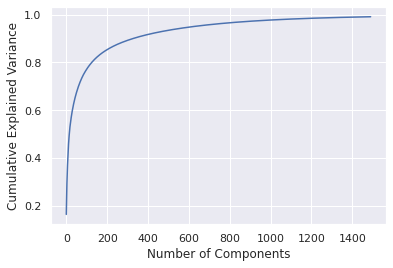

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(music_scaled, labels, test_size=0.25, random_state=42)

#initialize search values for optimal k
i = 1490
variance_explained = 0
target_variance_percentile = 0.99

#find the optimal k
while variance_explained <= target_variance_percentile:
    i=i+1
    pca = PCA(n_components=i)
    forest = RandomForestClassifier(n_estimators=100)
    pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])
    pipe.fit(music_scaled_X_train, y_train)
    pca_variance_explained = np.cumsum(pca.explained_variance_ratio_)
    
    array_length = len(pca_variance_explained)
    variance_explained = pca_variance_explained[array_length - 1]
    
    if variance_explained > target_variance_percentile-0.19:
        print('PCs = '+ str(i))
        print('Cumulative Variance = '+ str(variance_explained))
        
    
#final PCA model
pca = PCA(n_components=i)
forest = RandomForestClassifier(n_estimators=100)
pipe = Pipeline(steps=[('pca', pca), ('forest', forest)])
pipe.fit(music_scaled_X_train, y_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [9]:
test_predictions = pipe.predict(music_scaled_X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

Accuracy with RandomForest: 26.655552%


In [11]:
from sklearn.model_selection import RepeatedStratifiedKFold

param_dict = {"pca__n_components":[1491],
              "forest__n_estimators":[100]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)

estimator = GridSearchCV(pipe,
                         param_dict,
                         cv=cv,
                         verbose=2)

estimator.fit(music_scaled_X_train, y_train)

Fitting 25 folds for each of 1 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=25.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.1min remaining:    0.0s


[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=30.4min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=42.7min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=27.7min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=37.4min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=25.0min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=37.2min
[CV] forest__n_estimators=100, pca__n_components=1491 ................
[CV] . forest__n_estimators=100, pca__n_components=1491, total=31.1min
[CV] f

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 791.5min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=1491,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('forest',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gin...
                                                               min_samples_leaf=1,
    

In [12]:
print("The best parameters: {0}".format(estimator.best_params_))

The best parameters: {'forest__n_estimators': 100, 'pca__n_components': 1491}


In [13]:
test_predictions = pipe.predict(music_scaled_X_test)
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

Accuracy with RandomForest: 26.655552%


In [14]:
pipe.set_params(**estimator.best_params_);
pipe.fit(music_scaled_X_train, y_train);

test_predictions = pipe.predict(music_scaled_X_train)
precision = accuracy_score(test_predictions, y_train) * 100
print("Accuracy with RandomForest: {0:.6f}%".format(precision))

#test_df = pd.read_csv("../input/sign_mnist_test.csv", header=0)
#test_labels = test_df["genre"].values
#test_df.drop(["genre"], inplace=True, axis=1)

Accuracy with RandomForest: 100.000000%


In [15]:
#create a PCA based training frame
pca = PCA(n_components=i)
new_dataframe_pipe = Pipeline(steps=[('pca', pca)])

principle_components = new_dataframe_pipe.fit_transform(music_scaled_X_train)

In [16]:
music_scaled_X_train_pca = pd.DataFrame(data = principle_components)
music_scaled_y_train = pd.DataFrame(data = y_train, columns = ['genre'])
music_scaled_X_train_pca = pd.concat([music_scaled_X_train_pca, music_scaled_y_train], axis=1)
music_scaled_X_train_pca

,0,1,2,3,4,5,6,7,8,9,...,1482,1483,1484,1485,1486,1487,1488,1489,1490,genre
0,-8.229566,-1.902976,3.037285,18.022181,21.257472,1.006087,0.183701,-2.782119,1.668758,1.340693,...,0.228574,0.010443,-0.001056,0.419442,-0.184098,-0.072992,0.123720,-0.102825,-0.326741,Dance
1,8.708711,-29.185892,22.037479,-9.259812,-8.090364,-3.166292,3.816111,-3.119004,14.542073,-4.394920,...,0.453821,0.308777,0.059496,0.552813,-0.621987,0.025122,-0.241435,0.073065,0.038185,Blues
2,-13.752665,19.815111,-20.657853,21.031589,-16.931611,7.285425,-4.522447,-1.378319,4.427535,-0.859046,...,0.280570,-0.103462,0.084399,-0.322019,-0.417513,0.784926,-0.529272,-0.652729,-0.321636,Lo-Fi
3,-9.348096,4.031171,0.986149,-14.371868,2.033340,-0.350750,-2.541646,13.540084,-1.586789,-2.249359,...,-0.193042,0.518493,-0.597468,-0.144503,-0.056426,0.191189,0.403946,-0.380171,-0.057189,Noise
4,-12.108964,12.803063,-11.596527,13.932410,-6.100534,-13.652660,-1.072243,-9.988401,-13.017333,4.815079,...,0.097341,0.150458,-0.057403,-0.222646,-0.524074,0.217973,-0.143639,-0.274314,0.019272,Noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44977,-9.777618,2.642785,5.614356,-30.916124,4.020509,-2.649198,2.593310,4.168512,-6.490480,0.873398,...,-0.175597,-0.313006,0.687264,-0.471401,-0.269720,-0.454850,0.160136,-0.196080,0.700888,Sound Effects
44978,-13.280689,18.285602,-15.121585,-10.902819,-22.151387,20.688480,-1.606905,1.863389,13.749705,-7.407014,...,-0.133297,-0.473519,0.104891,-0.035579,-0.088967,-0.254515,0.261747,0.003016,0.063559,Pop
44979,-11.713129,9.575915,-4.004367,-13.279178,0.218279,-5.343600,-1.719235,5.906451,-14.362502,2.131165,...,-0.408691,0.278011,-0.022812,-0.302458,0.209981,0.346577,0.381633,0.191565,-0.152279,Avant-Garde
44980,4.021504,-21.107037,13.970044,6.639637,-8.075200,-5.578126,1.501612,-6.407242,14.549367,-3.653486,...,0.121070,-0.031390,-0.281367,0.064026,0.046392,0.800515,0.121373,-0.219115,1.124192,Experimental


In [17]:
#create a PCA based test frame
pca = PCA(n_components=i)
new_dataframe_pipe = Pipeline(steps=[('pca', pca)])

principle_components = new_dataframe_pipe.fit_transform(music_scaled_X_test)

In [18]:
music_scaled_X_test_pca = pd.DataFrame(data = principle_components)
music_scaled_y_test = pd.DataFrame(data = y_test, columns = ['genre'])
music_scaled_X_test_pca = pd.concat([music_scaled_X_test_pca, music_scaled_y_test], axis=1)
music_scaled_X_test_pca

,0,1,2,3,4,5,6,7,8,9,...,1482,1483,1484,1485,1486,1487,1488,1489,1490,genre
0,-9.970117,6.818098,-7.727968,0.095977,9.599847,-5.789358,3.666374,13.480109,-3.578910,1.325185,...,0.001233,0.198882,0.387862,-0.026338,-0.028133,-0.123839,-0.151713,0.094398,-0.015197,Avant-Garde
1,2.741736,-14.142398,15.763048,-10.905533,4.526840,-8.195744,-4.857452,-7.094710,11.574013,-3.303492,...,0.174258,-0.379888,0.336483,0.081884,-0.042575,0.106668,0.100321,-0.081981,-0.259148,Field Recordings
2,-12.630795,10.135627,-11.454185,19.070447,7.868272,-12.412734,14.734534,-11.875378,-8.874652,7.573865,...,0.465060,-0.019583,0.041220,-0.246864,0.294334,-0.217686,0.431887,0.081434,-0.150288,Hardcore
3,-10.915803,3.424928,-2.428944,16.175840,-12.404964,-2.568919,10.324103,-21.658444,-2.300490,3.106268,...,0.234332,0.100599,0.019114,0.288785,-0.388499,0.556807,-0.227037,-0.074297,-0.103726,Psych-Rock
4,-13.008905,13.775277,-15.799405,-4.547360,10.197738,17.332156,-13.149110,-9.038606,-2.447433,-2.041262,...,-0.076114,-0.411103,-0.155054,-0.767226,-0.284188,0.576808,-0.264049,-0.016502,-0.072704,Experimental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14990,-10.161986,1.083542,1.128377,-1.998601,-29.240473,12.240181,6.925883,-0.761301,-15.977577,6.482080,...,-0.245610,0.386643,0.090495,0.097861,-0.040533,0.454216,0.185311,0.360890,0.039252,Electronic
14991,6.130013,-14.596104,12.506165,28.972567,15.379388,-11.309574,-8.480112,-10.311934,11.082353,-3.785830,...,0.041718,0.050411,-0.012143,-0.138870,0.251190,0.066301,-0.216829,0.271870,0.438329,International
14992,-11.357183,4.869451,-4.130611,2.305854,-20.027844,10.976603,6.156500,1.667980,-18.094796,6.776717,...,-0.180374,0.070330,-0.119262,0.113081,0.335141,0.017977,-0.101561,-0.416061,-0.035205,Hip-Hop
14993,-8.716091,1.455538,-1.104800,13.955678,-0.096473,-13.273280,11.526349,-12.164125,1.198580,0.769808,...,0.169462,0.100773,-0.055010,0.001553,-0.156574,-0.147824,0.047352,0.008533,-0.011205,Metal


In [19]:
#export pca training dataframe
music_scaled_X_train_pca.to_csv('music_scaled_train_pca_vif_75.csv', index=False)

In [20]:
#export PCA based testing dataframe
music_scaled_X_test_pca.to_csv('music_scaled_test_pca_vif_25.csv', index=False)

In [ ]:
##################################
#### EXPERIMENTAL
##################################

In [ ]:
from sklearn.inspection import permutation_importance

pipe.set_params(**estimator.best_params_)
result = permutation_importance(pipe, music_scaled_X_train, y_train, 
                                n_repeats=10,
                                random_state=42)

perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()